# QUBO models from GULP

- [Read the structures](#structures)
- [Geometry analysis](#geom_analysis)
    - [Li distribution](#li_distribution)
    - [Mn distribution](#mn_distribution) small std
    - [O distribution](#o_distribution) small std
- [Build the QUBO model](#build_qubo_ml)
- [Symmetry analysis](#symm_analysis)

- [Build the QUBO matrix](#build_qubo)
    - [Ewald](#ewald)
    - [Buckingham](#buckingham)
- [Calculate the energy of GULP structures](#calc_E)
- [Build the initial QUBO](#qubo)
- [Experiments](#experiments)    
- [Mgo/ZnO](#mgo_zno)

### IDEAS
- for a shorter project, use fixed lattice and only consider Li positions (no Tc). A next step considers the Tc too, but at fixed lattice positions. Build a simple model with the Li atoms in the high-concentration (octa) and low-concentration sites (tetra). This would be useful for practicing building the energy model, but it would require running more GULP calculations on fixed lattice. 
- first get the distribution analysis and then build the energy model
    - we will need to map the position of atoms in the geometry relaxed structures to positions in the QUBO model
        - we could use a scaling in the linear regression (LR) that is proportional to how much an atom has moved from the QUBO position
- for the energy model let's try both the manual IP method and the LR



## GLOSSARY
- coord_top (N_positions_final): these are the Li coordinates with the higher probability calculated by defining a grid and looking at random structures in the database. They are not symmetrised. They are given in fractional coordinates.
- symmetrised_coords (N_positions_final x N_symmops): symmetrised coord_top. These are obtained by applying the symmetry operators of the delithiated structure to the coord_top. They are folded back into the cell (fractional coordinates).
- averaged_symmetrised_coords: (depends on the threshold): we only keep the symmetrised_coords that are more than a "threshold" apart.

- mn_sites_coords: Mn3+ sites coordinates taken from the initial delithiated structure

- all_coordinates_final: these are all the coordinates (fractional) included in the final model for QUBO. It contains the Mn sites first and then the Li ones.

- averaged_li_indices: these are the indices where the Li atoms are found in each structure. It refers to the list of averaged_symmetrised_coords. So [1] means that the Li atom is in position 1 of the averaged_symmetrised_coords

- mn_indices: this tells us for each structure (one row in mn_indices) where the Mn3+ are.

- binary_compositions: each row is the composition for one of the structures in the train set. The first 24 elements are the Mn sites and the rest is Li. 


In [164]:
import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from pymatgen.io.cif import *

from ase.visualize import view


from pymatgen.io.ase import AseAtomsAdaptor
import sys

import re
import shutil as sh
import pickle
from tqdm import tqdm


import copy
from sklearn.metrics import mean_squared_error 

#import dataframe_image as dfi

from scipy import constants
from scipy.spatial import KDTree, distance_matrix

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error as mse


k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]
# print(k_b)
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns
# from QG_functions import *

### The cell below creates the smaller database (only use when needed)

In [ ]:
# import numpy as np
# import pickle
# from tqdm import tqdm

# num_samples = 400  # Select 500 structures
# M = 20  # Grid definition (not used in this code)
# N_positions_final = 100  # Not used here but kept for context

# for i in tqdm(range(1, 25), desc="Selecting Structures"):
#     # Load the original pickle file
#     with open(f'../QUBO_GULP_SAVE/data/database/config_size_{i}.pkl', 'rb') as file:
#         data = pickle.load(file)  # `data` is a dictionary

#     # Select 500 random structures
#     sampled_keys = np.random.choice(list(data.keys()), num_samples, replace=False)
#     sampled_data = {key: data[key] for key in sampled_keys}  # Keep only sampled structures

#     # Save the sampled structures back to the pickle file
#     with open(f'data/database/config_size_{i}.pkl', 'wb') as file:
#         pickle.dump(sampled_data, file)

# print("✅ Successfully saved 500 structures per file.")


Selecting Structures: 100%|██████████| 24/24 [01:02<00:00,  2.60s/it]

✅ Successfully saved 500 structures per file.


# <a id='structures'>Read the structures</a>

In [ ]:
fully_lithiated_structure_init = Structure.from_file('data/fully_lithiated_tmp.cif')
delithiated_structure_init = Structure.from_file('data/delithiated_tmp.cif')

In [190]:
n_sites = fully_lithiated_structure_init.num_sites
fully_lithiated_structure_init.translate_sites(np.arange(n_sites),[1,1,1],to_unit_cell=True)

vview(fully_lithiated_structure_init)

In [191]:
# I don't think we need these functions
def apply_periodic_boundary_conditions(coord):
    """
    Apply periodic boundary conditions to bring fractional coordinates within [0, 1).
    """
    return coord - np.floor(coord)

def distance_with_pbc(fixed_pos, atom_pos, lattice, tolerance):
    """
    Compute the minimum distance between a fixed lattice position and an atom, 
    accounting for periodic boundary conditions (PBC).
    
    Parameters:
    fixed_pos (np.array): Fractional coordinates of the fixed lattice position.
    atom_pos (np.array): Fractional coordinates of the atom.
    lattice (np.array): Lattice vectors (3x3 matrix).
    tolerance (float): Tolerance to determine whether two points are close enough.
    
    Returns:
    bool: True if the distance between fixed_pos and atom_pos is within the tolerance.
    """
    # Shift atom position using periodic boundary conditions
    delta = apply_periodic_boundary_conditions(atom_pos - fixed_pos)
    
    # Convert to Cartesian coordinates
    delta_cartesian = np.dot(delta, lattice)
    
    # Compute distance in Cartesian coordinates
    distance = np.linalg.norm(delta_cartesian)
    
    return distance < tolerance

def create_binary_vector(fixed_positions, atoms, lattice, tolerance=0.1):
    """
    Create a binary vector indicating whether an atom is present near each fixed lattice position.
    
    Parameters:
    fixed_positions (np.array): List of fixed lattice positions as fractional coordinates.
    atoms (np.array): List of atomic positions as fractional coordinates.
    lattice (np.array): Lattice vectors (3x3 matrix).
    tolerance (float): Distance threshold for determining a match (default 0.1).
    
    Returns:
    binary_vector (np.array): A binary vector where 1 indicates an atom is near a fixed lattice position.
    """
    num_fixed_positions = len(fixed_positions)
    binary_vector = np.zeros(num_fixed_positions, dtype=int)
    
    for i, fixed_pos in enumerate(fixed_positions):
        for atom_pos in atoms:
            if distance_with_pbc(fixed_pos, atom_pos, lattice, tolerance):
                binary_vector[i] = 1
                break  # Once we find a match, we don't need to check other atoms for this fixed position
    
    return binary_vector

# Example usage:
fixed_positions = np.array([[0.57385, 0.47843, 0.25002],  # Replace with full list
                            [0.89053, 0.22843, 0.41668],
                            [0.39053, 0.04394, 0.75002],
                            # Add all fixed positions
                            ])

# Example atom positions
atom_positions = np.array([[0.57385, 0.47843, 0.25002], 
                           [0.891, 0.2285, 0.4167], 
                           [0.390, 0.044, 0.750]])

# Lattice vectors (example)
lattice_vectors = np.array([[10, 0, 0], [0, 10, 0], [0, 0, 10]])

# Create binary vector
tolerance = 0.1  # Adjustable tolerance for distance comparison
binary_vector = create_binary_vector(fixed_positions, atom_positions, lattice_vectors, tolerance)

print(binary_vector)


[1 1 0]


## From database

the data in data/database/config_size_n.pkl are the pkl files for all (?) the structures that Kyu optimised. 

they contain both the initial and final structure (pre and post geometry relaxation)

data.keys() are int

In [12]:
with open('data/database/config_size_1.pkl', 'rb') as file:
    data = pickle.load(file)

# Print the loaded data to verify
data[0]


{'initial': {'energy': -2927.40820176,
  'energy_ip': 509.06685395,
  'energy_long': -3436.47505571,
  'energy_long_real': -2125.73113685,
  'energy_long_imag': -1310.74391886,
  'lattice_vectors': [[8.872874, 0.0, 0.0],
   [0.0, 9.432501, 0.0],
   [0.0, 0.0, 8.565761]],
  'config': [['Tc', 'core', 0.1203, 0.0065, 0.083331],
   ['Mn', 'core', 0.337391, 0.256497, 0.250004],
   ['Mn', 'core', 0.620302, 0.243497, 0.083331],
   ['Mn', 'core', 0.837392, 0.493495, 0.250004],
   ['Mn', 'core', 0.1203, 0.506495, 0.083331],
   ['Mn', 'core', 0.337391, 0.756492, 0.250004],
   ['Mn', 'core', 0.620302, 0.743492, 0.083331],
   ['Mn', 'core', 0.837392, 0.993489, 0.250004],
   ['Mn', 'core', 0.1203, 0.0065, 0.416677],
   ['Mn', 'core', 0.337391, 0.256497, 0.583339],
   ['Mn', 'core', 0.620302, 0.243497, 0.416677],
   ['Mn', 'core', 0.837392, 0.493495, 0.583339],
   ['Mn', 'core', 0.1203, 0.506495, 0.416677],
   ['Mn', 'core', 0.337391, 0.756492, 0.583339],
   ['Mn', 'core', 0.620302, 0.743492, 0.4166

In [5]:
def db_to_structure(db_entry, final=True):
    """
    Converts a database entry to a pymatgen Structure object.
    
    Parameters:
    db_entry (dict): The database entry containing structure information.
    final (bool): If True, return the final structure. If False, return the initial structure.
    
    Returns:
    structure (pymatgen.Structure): A pymatgen Structure object for the given state (initial or final).
    """
    # Select the correct state (initial or final)
    state = 'final' if final else 'initial'
    
    # Extract the lattice vectors
    lattice_vectors = db_entry[state]['lattice_vectors']
    lattice = Lattice(lattice_vectors)
    
    # Extract the atomic species and positions
    species = [site[0] for site in db_entry[state]['config']]
    coords = [[site[2], site[3], site[4]] for site in db_entry[state]['config']]
    
    # Create and return the pymatgen Structure object
    structure = Structure(lattice, species, coords)
    
    return structure

# db_to_structure(data[0], final=True)

# <a id='geom_analysis'>Geometry analysis</a>
- deviation around perfect lattice site per Li concentration (Mn and O)
- find grid of points where Li are more likely to sit (3D probability map) 
    - need to define a very dense grid
    - use symmetry?

#### Important variables in the functions below

M: grid definition. This defines the initial grid. Each atom will be assigned to a cube within the cell. M is the number of division along each lattice parameter, so the final number of cubes is M**3
N_positions_final: the final number of coordinates. These are the top N_positions_final in terms of probability. The coordinate that is returned is the center of the cube, so all the points within the cube now have the center as coordinate.


#### Considerations

There cannot be more N_positions_final than grid points.
Do the final positions converge with the grid size increase?
If the grid is too fine, I end up with a lot of positions that are very close (?)
At the end I could average the points that are too close, but wouldn'it be like using a smaller grid? -> the grid size could represent the minimum separation between sites that I want to use.
We could simmetrise after all the above and keep the average if two atoms are too close.

#### TO DO

plot mse and R vs:
- sample size
- grid size
- num coordinates

In [6]:
def compute_probability_grid(li_coords_all, M):
    """
    Compute a MxMxM grid of probabilities for the points in li_coords_all.
    
    Parameters:
    li_coords_all (ndarray): Nx3 array of fractional coordinates.
    M (int): Size of the grid along each dimension.
    
    Returns:
    ndarray: MxMxM array of probabilities.
    """
    # Initialize the grid
    grid = np.zeros((M, M, M))
    
    # Convert fractional coordinates to grid indices
    indices = (li_coords_all * M).astype(int)

    # Ensure indices are within bounds
    indices = np.clip(indices, 0, M-1)
    
    # Count the points in each grid cell
    for index in indices:
        grid[tuple(index)] += 1
    
    # Normalize the grid so that the sum of all values is 1
    total_points = len(li_coords_all)
    grid /= total_points
    
    return grid

def find_top_x_points(grid, centers, x):
    """
    Find the top x points in the grid in terms of probability.
    
    Parameters:
    grid (ndarray): MxMxM array of probabilities.
    centers (ndarray): MxMxM array of fractional coordinates of the centers.
    x (int): Number of top points to find.
    
    Returns:
    list: List of tuples (fractional_coordinate, probability) for the top x points.
    """
    # Flatten the grid and the coordinates
    flat_grid = grid.flatten()
    flat_centers = centers.reshape(-1, 3)
    
    # Get the indices of the top x values
    top_indices = np.argsort(flat_grid)[-x:]
    
    # Get the top x values and their corresponding fractional coordinates
    top_points = [(flat_centers[i], flat_grid[i]) for i in top_indices]
    
    # Sort the top points by probability in descending order
    top_points.sort(key=lambda x: x[1], reverse=True)
    
    
    return top_points

def find_fractional_centers(M):
    """
    Find the fractional coordinates of the centers of the grid cells.
    
    Parameters:
    M (int): Size of the grid along each dimension.
    
    Returns:
    ndarray: MxMxM array of fractional coordinates of the centers.
    """
    centers = np.zeros((M, M, M, 3))
    for i in range(M):
        for j in range(M):
            for k in range(M):
                centers[i, j, k] = [(i + 0.5) / M, (j + 0.5) / M, (k + 0.5) / M]
    return centers


def plot_probability_grid(grid):
    """
    Plot the 3D grid of probabilities.
    
    Parameters:
    grid (ndarray): MxMxM array of probabilities.
    """
    M = grid.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a meshgrid for the coordinates
    x, y, z = np.meshgrid(np.arange(M), np.arange(M), np.arange(M), indexing='ij')
    
    # Flatten the grid and the coordinates for plotting
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = grid.flatten()
    
    # Plot the grid points with a color map based on the values
    scatter = ax.scatter(x, y, z, c=values, cmap='viridis', marker='o')
    
    # Add a color bar to show the probability values
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Probability')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Probability Grid')
    plt.show()
    
def plot_top_points(top_centers):
    """
    Plot the top points on a 3D plot with an inverted color scale.

    Parameters:
    top_centers (ndarray): Coordinates of the top points.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates
    x = top_centers[:, 0]
    y = top_centers[:, 1]
    z = top_centers[:, 2]

    # Scatter plot with inverted colormap
    sc = ax.scatter(x, y, z, c=z, cmap='viridis_r', marker='o')

    # Add color bar
    cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
    cbar.set_label('Z-Value (Inverted Scale)')

    # Labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Top 10 Points in the Grid')

    plt.show()

### <a id='li_distribution'>Li distribution</a>

In [241]:
vview(Structure.from_sites(fully_lithiated_structure_init[0:24]))

Computing Li positions: 100%|██████████| 24/24 [00:02<00:00, 11.64it/s]


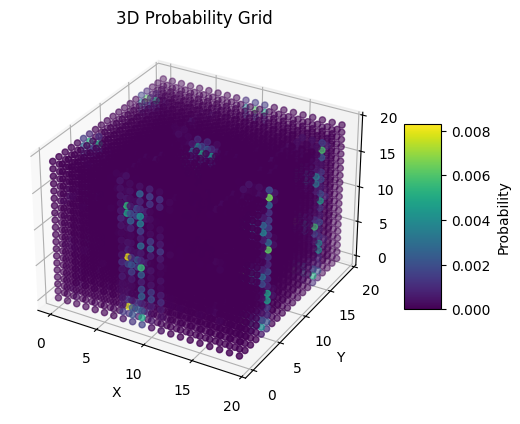

In [189]:
li_coords_all = []
num_samples = 100
M = 20 #grid definition
N_positions_final = 100

for i in tqdm(range(1,25), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)
    
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])#[-48:])[:,2:]
        li_index = np.where(coords_tmp[:,0] == 'Li')[0]

        li_coords = np.array(coords_tmp[li_index][:,2:])
        li_coords = np.array(li_coords,dtype='float').tolist()
        li_coords_all.extend(li_coords)
        

li_coords_all = np.array(li_coords_all)
grid = compute_probability_grid(li_coords_all, M)

plot_probability_grid(grid)

centers = find_fractional_centers(M)
top_centers = find_top_x_points(grid,centers,N_positions_final)

coord_top = []
for line in top_centers:
    coord_top.append(line[0])
coord_top = np.array(coord_top)
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N_positions_final,coord_top))



In [ ]:
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N_positions_final,coord_top))

## Apply symmetry operators to the Li top centers

In [194]:
symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()
num_symmops = len(symmops)

symmetrised_coords = []
for symmop in symmops:
    for coord in coord_top:
        symmetrised_coords.append(symmop.operate(coord)%1)


symmetrised_coords = np.array(symmetrised_coords)
len(symmetrised_coords)

4800

<!-- ## New approach for symmetry

This doesn't works as expected -->

In [ ]:
# # all symmetrised in the supercell
# vview(Structure(delithiated_structure_init.lattice,[1]*len(symmetrised_coords),symmetrised_coords))

In [ ]:
# # FOLD TO PRIMITIVE CELL
# symmetrised_coords_folded = symmetrised_coords%[1,0.5,1/3]
# vview(Structure(delithiated_structure_init.lattice,[1]*len(symmetrised_coords_folded),symmetrised_coords_folded))

In [ ]:
# #   AVERAGE COORDINATES IN THE PRIMITIVE CELL
# threshold = 0.05  # THIS IS AN IMPORTANT PARAMETER

# averaged_symmetrised_coords = average_close_points(symmetrised_coords_folded, threshold)
# print(len(symmetrised_coords_folded),len(averaged_symmetrised_coords))

480 13


In [ ]:
# # VIEW SYMMETRISED FOLDED AVERAGED

# vview(Structure(delithiated_structure_init.lattice,[1]*len(averaged_symmetrised_coords),averaged_symmetrised_coords))

In [ ]:
# # APPLY SYMMETRY AGAIN

# symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()
# num_symmops = len(symmops)

# symmetrised_coords_new = []
# for symmop in symmops:
#     for coord in averaged_symmetrised_coords:
#         symmetrised_coords_new.append(symmop.operate(coord)%1)


# symmetrised_coords_new = np.array(symmetrised_coords_new)

In [ ]:
# # VIEW SYMMETRISED FOLDED AVERAGED IN SUPERCELL

# vview(Structure(delithiated_structure_init.lattice,[1]*len(symmetrised_coords_new),symmetrised_coords_new))

In [198]:

from scipy.spatial.distance import pdist, squareform

def average_close_points(symmetrised_coords, threshold):
    """
    Averages the coordinates of points that are closer than the given threshold.

    Parameters:
    symmetrised_coords (np.array): (N,3) array of 3D coordinates.
    threshold (float): Distance threshold for grouping points.

    Returns:
    np.array: New array with averaged coordinates.
    """
    # Compute pairwise distances
    distances = squareform(pdist(symmetrised_coords))
    
    # Track processed points
    visited = np.zeros(len(symmetrised_coords), dtype=bool)
    averaged_coords = []

    for i in range(len(symmetrised_coords)):
        if visited[i]:  # Skip if already processed
            continue

        # Find all close points (including itself)
        close_points = np.where(distances[i] < threshold)[0]
        visited[close_points] = True  # Mark as processed

        # Compute the average of these points
        avg_coord = np.mean(symmetrised_coords[close_points], axis=0)
        averaged_coords.append(avg_coord)

    return np.array(averaged_coords)


threshold = 0.1  # THIS IS AN IMPORTANT PARAMETER

averaged_symmetrised_coords = average_close_points(symmetrised_coords, threshold)

print(len(averaged_symmetrised_coords))

63


In [199]:
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*len(averaged_symmetrised_coords),averaged_symmetrised_coords))

## Define the model

 This is the final sites included in the model. We define it here, but we might only need it for generating images.

In [215]:
mn_sites = delithiated_structure_init[0:24]
mn_sites_coords = delithiated_structure_init.frac_coords[0:24]

li_sites = []

for coord in averaged_symmetrised_coords:   
    li_sites.append(PeriodicSite('Li',coord,delithiated_structure_init.lattice)) 

li_sites_coords = copy.deepcopy(averaged_symmetrised_coords)


all_sites = copy.deepcopy(mn_sites)
all_sites.extend(li_sites)

all_coordinates_final = np.vstack((np.array(mn_coords),averaged_symmetrised_coords))

final_model = Structure.from_sites(all_sites)

vview(Structure.from_sites(all_sites))

In [ ]:
# I DON'T THINK WE NEED THIS
# mn_sites = delithiated_structure_init[0:24]
# mn_sites_coords = delithiated_structure_init.frac_coords[0:24]

# li_sites = []

# for coord in symmetrised_coords:   
#     li_sites.append(PeriodicSite('Li',coord,delithiated_structure_init.lattice)) 

# li_sites_coords = copy.deepcopy(averaged_symmetrised_coords)


# all_sites = copy.deepcopy(mn_sites)
# all_sites.extend(li_sites)

# final_model_all_symmetrised = Structure.from_sites(all_sites)

# vview(Structure.from_sites(all_sites))

## Find if structures map to our grid
Now that we have defined the Li coordinates to keep, I need to ensure that the GULP optimised structures map to those coordinates.

This is a good test, but we actually do it later when building the train set anyway.

In [ ]:
from scipy.spatial import KDTree

def compute_closest_distances(li_coords, tree):
    """
    Computes the distance and closest point index from each point in li_coords 
    to the nearest point in averaged_symmetrised_coords.

    Parameters:
    li_coords (np.array): (M,3) array of 3D coordinates.
    tree (KDTree): Precomputed KDTree of averaged_symmetrised_coords.

    Returns:
    distances (np.array): Distances from each point in li_coords to the closest point in averaged_symmetrised_coords.
    indices (np.array): Indices of the closest points in averaged_symmetrised_coords.
    """
    # Query the closest distance and index for each point in li_coords
    distances, indices = tree.query(li_coords)

    return np.array(distances), indices

In [ ]:

tree_li = KDTree(li_sites_coords)  # Precompute KDTree
tree_mn = KDTree(mn_sites_coords)

In [ ]:
li_coords_map = []
num_samples = 1

all_distances = []


threshold_dist = 0.1

for i in tqdm(range(1,3), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    
    samples = np.random.choice(len(data), num_samples)
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])  # Extract structure data
        li_index = np.where(coords_tmp[:, 0] == 'Li')[0]  # Find Lithium positions

        li_coords = np.array(coords_tmp[li_index][:, 2:], dtype='float').tolist()

        # Compute closest distances and indices
        distances, indices = compute_closest_distances(li_coords, tree)
        print(indices)
        if np.any(distances > threshold_dist):
            break
        # Print results
        for i, (point, dist, idx) in enumerate(zip(li_coords, distances, indices)):
            closest_point = averaged_symmetrised_coords[idx]  # Retrieve the actual closest coordinate
            all_distances.append(dist)
            # print(f"Point {i}: {point} -> Closest Distance: {dist:.4f}, Closest Coord: {closest_point}, Index: {idx}")

Computing Li positions:  50%|█████     | 1/2 [00:02<00:02,  2.90s/it]

[16]


Computing Li positions: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]

[37 33]


In [210]:
np.sort(all_distances)[::-1]

array([0.08136985, 0.04110683, 0.00823109])

## K-means

I don't think we well need this

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans

# def find_probable_sites(coordinates, N):
#     """
#     Find the coordinates on N sites where there is the highest probability of finding an atom.
    
#     Args:
#         coordinates (list or np.ndarray): List or array of 3D coordinates (shape: X x 3).
#         N (int): Number of desired sites (clusters).
        
#     Returns:
#         np.ndarray: Coordinates of the N most probable sites (shape: N x 3).
#     """
#     coordinates = np.array(coordinates)
#     X = len(coordinates)

#     # If X == N, return the original coordinates
#     if X == N:
#         return coordinates
    
#     # Use K-means clustering to reduce the number of coordinates to N clusters
#     kmeans = KMeans(n_clusters=N, random_state=42)
#     kmeans.fit(coordinates)
    
#     # The cluster centers represent the most probable sites
#     probable_sites = kmeans.cluster_centers_
    
#     return probable_sites

In [ ]:
# li_coords_all = []
# num_samples = 100 #MAKE RANDOM
# M = 50 #grid definition
# N_positions_final = 50
# coord_top_all = []
# for i in tqdm(range(1,23), desc="Computing Li positions"):
#     with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
#         data = pickle.load(file)
#     samples = np.random.choice(len(data),num_samples)
    
#     structure_n = np.array(list(data.keys()))[samples]
#     li_coords_all = []
#     for j in structure_n:
#         coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
#         li_index = np.where(coords_tmp[:,0] == 'Li')[0]

#         li_coords = np.array(coords_tmp[li_index][:,2:])
#         li_coords = np.array(li_coords,dtype='float').tolist()
#         li_coords_all.extend(li_coords)
        

#     li_coords_all = np.array(li_coords_all)
#     grid = compute_probability_grid(li_coords_all, M)

#     centers = find_fractional_centers(M)
#     top_centers = find_top_x_points(grid,centers,N_positions_final)

#     coord_top = []
#     for line in top_centers:
#         coord_top.append(line[0])
#     coord_top_all.extend(coord_top)

# coord_top_all = np.array(coord_top_all)
# print(coord_top_all)
# N = 200
# sites = find_probable_sites(coord_top_all, N)
# vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N,sites))

Computing Li positions:  18%|█▊        | 4/22 [00:13<00:53,  2.95s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107ded990>>
Traceback (most recent call last):
  File "/Users/brunocamino/miniconda3/envs/numba_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Computing Li positions: 100%|██████████| 22/22 [01:07<00:00,  3.07s/it]

[[0.47 0.51 0.69]
 [0.49 0.49 0.51]
 [0.49 0.47 0.57]
 ...
 [0.05 0.33 0.57]
 [0.05 0.83 0.89]
 [0.37 0.57 0.09]]


NameError: name 'find_probable_sites' is not defined

### <a id='mn_distribution'>Mn distribution</a>

I fixed this by sorting the coordinates (lexsort)

I am using fractional coordinates.


In [ ]:
mn_coords_all = []
num_samples = 100 #MAKE RANDOM

for i in tqdm(range(1,25), desc="Computing Mn positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)

    structure_n = np.array(list(data.keys()))[samples]
    mn_coords_all = []
    for j in structure_n:
        coords_tmp = np.array(data[j]['initial']['config'])
        mn_coords_init = np.array(coords_tmp[0:24][:,2:]) 
        mn_coords_init = np.array(mn_coords_init,dtype='float')
        
        ordering = np.lexsort(mn_coords_init.T)
        
        coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
        mn_coords = np.array(coords_tmp[0:24][:,2:])

        mn_coords = np.array(mn_coords,dtype='float')
        mn_coords_ordered = np.array(mn_coords,dtype='float')[ordering]
        
        mn_coords_all.append(mn_coords_ordered.tolist())
        

    mn_coords_all = np.array(mn_coords_all)

Computing Mn positions: 100%|██████████| 24/24 [01:03<00:00,  2.66s/it]


#### Standard deviation of positions

In [127]:
np.std(mn_coords_all,axis=0)

array([[0.0342239 , 0.01394752, 0.00485789],
       [0.014846  , 0.01942766, 0.00410985],
       [0.04248935, 0.01291126, 0.00480627],
       [0.01109304, 0.01054564, 0.00285272],
       [0.02589296, 0.02867527, 0.00529204],
       [0.0429106 , 0.00912049, 0.004264  ],
       [0.04695055, 0.01351369, 0.00468466],
       [0.03058942, 0.47725788, 0.01598095],
       [0.02626342, 0.10379949, 0.01526773],
       [0.03621499, 0.02173029, 0.00382581],
       [0.09022168, 0.02801815, 0.01734458],
       [0.02020396, 0.07849185, 0.01554363],
       [0.01215161, 0.02960394, 0.00427007],
       [0.02705144, 0.00940826, 0.00417938],
       [0.043248  , 0.04051673, 0.00415479],
       [0.05069768, 0.46289384, 0.03881629],
       [0.04107416, 0.01462132, 0.00454678],
       [0.01168328, 0.02569037, 0.01657419],
       [0.02760512, 0.03603532, 0.02156675],
       [0.01095758, 0.02368162, 0.00335547],
       [0.02018747, 0.04428127, 0.00471028],
       [0.02568991, 0.00820178, 0.00507244],
       [0.

### <a id='o_distribution'>O distribution</a>

#### Same approach as Mn

In [138]:
o_coords_all = []
num_samples = 100 #MAKE RANDOM

for i in tqdm(range(1,25), desc="Computing Mn positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)

    structure_n = np.array(list(data.keys()))[samples]
    o_coords_all = []
    for j in structure_n:
        coords_tmp = np.array(data[j]['initial']['config'])
        o_coords_init = np.array(coords_tmp[-48:][:,2:]) 
        o_coords_init = np.array(o_coords_init,dtype='float')
        
        ordering = np.lexsort(o_coords_init.T)
        
        coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
        o_coords = np.array(coords_tmp[-48:][:,2:])

        o_coords = np.array(o_coords,dtype='float')
        o_coords_ordered = np.array(o_coords,dtype='float')[ordering]
        
        o_coords_all.append(o_coords_ordered.tolist())
        

    o_coords_all = np.array(o_coords_all)

Computing Mn positions: 100%|██████████| 24/24 [01:01<00:00,  2.55s/it]


In [139]:
np.std(o_coords_all,axis=0)

array([[1.52511142e-02, 1.12807808e-02, 4.94191033e-03],
       [1.61415027e-02, 1.72447097e-02, 5.33915480e-03],
       [1.04184638e-02, 1.20268361e-02, 6.02801964e-03],
       [1.13295274e-02, 1.31529363e-02, 6.32133233e-03],
       [1.63895750e-02, 1.02429269e-02, 5.90376334e-03],
       [1.51637772e-02, 1.83636060e-02, 4.89662363e-03],
       [9.30816301e-03, 9.88291403e-03, 5.02956916e-03],
       [9.96175218e-03, 1.06066233e-02, 6.84066659e-03],
       [3.83398099e-01, 1.08345278e-02, 5.30338444e-03],
       [1.25552059e-02, 1.22440871e-02, 6.36613407e-03],
       [1.41908540e-02, 1.22010536e-02, 4.43404695e-03],
       [1.24034059e-02, 1.82894160e-02, 5.28882822e-03],
       [3.73561032e-01, 1.30500548e-02, 6.98898496e-03],
       [1.25141945e-02, 1.06751745e-02, 5.53618951e-03],
       [1.09768592e-02, 9.45740082e-03, 4.69987341e-03],
       [1.46560475e-02, 1.45034090e-02, 4.49388762e-03],
       [1.31222068e-02, 1.30553639e-02, 5.41309027e-03],
       [1.45317315e-02, 1.69959

# <a id='build_qubo_ml'>Build the QUBO model</a>

In [46]:
def apply_symmops(coordinates, symmops):
    
    symmetrised_coords_all = []
    for symmop in symmops:
        symmetrised_coords = []
        for coord in coordinates:
            symmetrised_coords.append(symmop.operate(coord)%1)
        symmetrised_coords_all.append(symmetrised_coords)
    return np.array(symmetrised_coords_all)
        

In [ ]:
def compute_closest_distances(li_coords, tree):
    """
    Computes the distance and closest point index from each point in li_coords 
    to the nearest point in averaged_symmetrised_coords.

    Parameters:
    li_coords (np.array): (M,3) array of 3D coordinates.
    tree (KDTree): Precomputed KDTree of averaged_symmetrised_coords.

    Returns:
    distances (np.array): Distances from each point in li_coords to the closest point in averaged_symmetrised_coords.
    indices (np.array): Indices of the closest points in averaged_symmetrised_coords.
    """
    # Query the closest distance and index for each point in li_coords
    distances, indices = tree.query(li_coords)

    return np.array(distances), indices

In [38]:
len(symmetrised_coords)

4800

In [ ]:
tree_li = KDTree(symmetrised_coords)
tree_li_average = KDTree(averaged_symmetrised_coords)

mn_sites_coords = delithiated_structure_init.frac_coords[0:24]

tree_mn = KDTree(mn_sites_coords)

symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()

In [217]:
import pickle
import numpy as np
from tqdm import tqdm

# List to store lithium coordinates across all structures (not used in the loop)
li_coords_all = []

num_samples = 50  # Number of structures randomly sampled from each dataset
M = 20  # Grid definition parameter (not used in this snippet)

# Lists to store extracted data
all_li_indices = []       # Stores indices of Li atoms after filtering
mn_indices = []        # Stores indices of Mn (Tc in this case) atoms
all_li_coordinates = []   # Stores Li atom coordinates after symmetry operations
all_energies = []      # Stores final energy values of selected structures

# Loop over different dataset sizes/configurations (from 1 to 24)
for i in tqdm(range(1, 25), desc="Computing Li positions"):
    # Load the dataset for the given configuration size
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)

    # Randomly sample a subset of structures from the dataset
    samples = np.random.choice(len(data), num_samples)

    # Extract structure identifiers (keys) for the selected samples
    structure_n = np.array(list(data.keys()))[samples]

    # Iterate through selected structures
    for j in structure_n:
        # Extract final configuration coordinates
        coords_tmp = np.array(data[j]['final']['config'])  # Extracts coordinate data
        li_index = np.where(coords_tmp[:, 0] == 'Li')[0]  # Identify Li atom indices

        # Get coordinates of Li atoms in the structure
        li_coords = np.array(coords_tmp[li_index][:, 2:])  # Extract only coordinate values
        li_coords = np.array(li_coords, dtype='float').tolist()  # Convert to float and list format

        # Apply symmetry operations to Li coordinates
        li_symm_coords = apply_symmops(li_coords, symmops)

        # Compute the closest distances between symmetrized Li coordinates and a reference tree
        distances, indices = compute_closest_distances(li_symm_coords, tree_li)

        # Check if any distance is greater than a threshold (0.1), which may indicate an issue
        if np.any(distances > 0.5):
            print(f'Check distances structure {j} with conc {i}: max distance {np.max(distances)}')

        # Store indices and symmetrized coordinates of Li atoms
        all_li_indices.extend(indices)
        all_li_coordinates.extend(symmetrised_coords[indices])  # Ensure symmetrised_coords is defined correctly

        # Extract initial configuration coordinates for Mn (or Tc) atoms
        coords_tmp = np.array(data[j]['initial']['config'])  # Extract coordinate data
        mn_index = np.where(coords_tmp[:, 0] == 'Tc')[0]  # Identify Mn (Tc) atom indices

        # Get coordinates of Mn atoms in the structure
        mn_coords = np.array(coords_tmp[mn_index][:, 2:])  # Extract only coordinate values
        mn_coords = np.array(mn_coords, dtype='float').tolist()  # Convert to float and list format

        # Apply symmetry operations to Mn coordinates
        mn_symm_coords = apply_symmops(mn_coords, symmops)

        # Compute the closest distances between symmetrized Mn coordinates and a reference tree
        distances, indices = compute_closest_distances(mn_symm_coords, tree_mn)

        # Check if any Mn distance is greater than a threshold (0.01), which may indicate an issue
        if np.any(distances > 0.01):
            print(f'Check Mn distances structure {j} with conc {i}: max distance {np.max(distances)}')

        # Store Mn indices
        mn_indices.extend(indices)

        # Store the final energy of the structure
        all_energies.append(float(data[j]['final']['energy']))

Computing Li positions: 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


In [ ]:
# # SAVE - DO NOT REMOVE
# li_coords_all = []
# num_samples = 50
# M = 20 #grid definition



# all_indices = []
# mn_indices = []
# all_coordinates = []
# all_energies = []
# for i in tqdm(range(1,25), desc="Computing Li positions"):
#     with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
#         data = pickle.load(file)
#     samples = np.random.choice(len(data),num_samples)


#     structure_n = np.array(list(data.keys()))[samples]

#     for j in structure_n:
#         coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
#         li_index = np.where(coords_tmp[:,0] == 'Li')[0]

#         li_coords = np.array(coords_tmp[li_index][:,2:])
#         li_coords = np.array(li_coords,dtype='float').tolist()
        
#         li_symm_coords = apply_symmops(li_coords,symmops)

#         distances, indices = compute_closest_distances(li_symm_coords, tree_li)
#         if np.any(distances > 0.1):
#             print(f'Check distances structure {j} with conc {i}: max distance {np.max(distances)}')
#         all_indices.extend(indices)
#         all_coordinates.extend(symmetrised_coords[indices])

#         coords_tmp = np.array(data[j]['initial']['config'])#[-48:])[:,2:]
#         mn_index = np.where(coords_tmp[:,0] == 'Tc')[0]

#         mn_coords = np.array(coords_tmp[mn_index][:,2:])
#         mn_coords = np.array(mn_coords,dtype='float').tolist()

#         mn_symm_coords = apply_symmops(mn_coords,symmops)

#         distances, indices = compute_closest_distances(mn_symm_coords, tree_mn)
#         if np.any(distances > 0.01):
#             print(f'Check Mn distances structure {j} with conc {i}: max distance {np.max(distances)}')
#         mn_indices.extend(indices)

#         all_energies.append(float(data[j]['final']['energy']))



Computing Li positions:   8%|▊         | 2/24 [00:00<00:01, 15.75it/s]

Check distances structure 3406 with conc 1: max distance 0.21362595748670418
Check distances structure 16522 with conc 1: max distance 0.1800236191184337
Check distances structure 2981 with conc 1: max distance 0.18129218275412246
Check distances structure 14678 with conc 1: max distance 0.17911112105055288
Check distances structure 3136 with conc 2: max distance 0.17097384937632296
Check distances structure 12329 with conc 2: max distance 0.14646692337179748
Check distances structure 5419 with conc 2: max distance 0.16534108849721676
Check distances structure 4054 with conc 2: max distance 0.16955037646211357
Check distances structure 17389 with conc 2: max distance 0.11963284493853453
Check distances structure 15963 with conc 3: max distance 0.16591057805871745
Check distances structure 13174 with conc 3: max distance 0.19714633548690103
Check distances structure 7920 with conc 3: max distance 0.19119207553255047
Check distances structure 12186 with conc 3: max distance 0.15472387803

Computing Li positions:  17%|█▋        | 4/24 [00:00<00:03,  5.37it/s]

Check distances structure 11737 with conc 4: max distance 0.17343964335974899
Check distances structure 10367 with conc 4: max distance 0.14543425660761308
Check distances structure 18732 with conc 4: max distance 0.15123058156176555
Check distances structure 642 with conc 4: max distance 0.18784519650852158
Check distances structure 1999 with conc 4: max distance 0.2122064170642419
Check distances structure 15233 with conc 4: max distance 0.1739141413629151
Check distances structure 18134 with conc 4: max distance 0.14436607803128476
Check distances structure 2199 with conc 4: max distance 0.14366132892649963
Check distances structure 10733 with conc 4: max distance 0.15061132293322516
Check distances structure 6591 with conc 4: max distance 0.19778394755142747
Check distances structure 10047 with conc 4: max distance 0.15455337118326185
Check distances structure 1490 with conc 4: max distance 0.1746020464379276
Check distances structure 2933 with conc 4: max distance 0.21161052686002

Computing Li positions:  25%|██▌       | 6/24 [00:00<00:02,  6.74it/s]

Check distances structure 6345 with conc 5: max distance 0.15358110470186245
Check distances structure 154 with conc 5: max distance 0.19531319448389745
Check distances structure 2102 with conc 5: max distance 0.17246815624980422
Check distances structure 1968 with conc 5: max distance 0.1920838590862946
Check distances structure 10545 with conc 5: max distance 0.18426408025190644
Check distances structure 12519 with conc 5: max distance 0.1571079417346911
Check distances structure 6938 with conc 5: max distance 0.19678343425394765
Check distances structure 13776 with conc 5: max distance 0.20194062141739696
Check distances structure 6159 with conc 5: max distance 0.18002589347747575
Check distances structure 11314 with conc 5: max distance 0.2040090918364953
Check distances structure 19045 with conc 5: max distance 0.20559096519128092
Check distances structure 7509 with conc 6: max distance 0.22710821738137818
Check distances structure 3487 with conc 6: max distance 0.151815722061036


Computing Li positions:  29%|██▉       | 7/24 [00:01<00:02,  7.16it/s]

Check distances structure 13401 with conc 7: max distance 0.20695646888191127
Check distances structure 5862 with conc 7: max distance 0.183051484482558
Check distances structure 1307 with conc 7: max distance 0.1618268320051953
Check distances structure 13006 with conc 7: max distance 0.18320878107285946
Check distances structure 523 with conc 7: max distance 0.19430782219428971
Check distances structure 16128 with conc 7: max distance 0.203118123911924
Check distances structure 12104 with conc 7: max distance 0.13863528736220085
Check distances structure 11754 with conc 7: max distance 0.20567108177162663
Check distances structure 6280 with conc 7: max distance 0.1914959946061261
Check distances structure 3522 with conc 7: max distance 0.19786955448083576
Check distances structure 13673 with conc 7: max distance 0.20694045939942354
Check distances structure 3391 with conc 7: max distance 0.19972961643010678
Check distances structure 10763 with conc 7: max distance 0.1567121025212607


Computing Li positions:  33%|███▎      | 8/24 [00:01<00:03,  5.11it/s]

Check distances structure 18656 with conc 8: max distance 0.20808219294377878
Check distances structure 15287 with conc 8: max distance 0.2004038220484445
Check distances structure 3295 with conc 8: max distance 0.21001118129862614
Check distances structure 7866 with conc 8: max distance 0.15386675398294922
Check distances structure 12034 with conc 8: max distance 0.1830586317658609
Check distances structure 329 with conc 8: max distance 0.20872922633536845
Check distances structure 9203 with conc 8: max distance 0.1830877569401544
Check distances structure 12570 with conc 8: max distance 0.18038332309767455
Check distances structure 9903 with conc 8: max distance 0.16159734861723982
Check distances structure 9635 with conc 8: max distance 0.1818593497525365
Check distances structure 991 with conc 8: max distance 0.18506516764790543
Check distances structure 734 with conc 8: max distance 0.20389288725891788
Check distances structure 3309 with conc 8: max distance 0.21684001378232065
Ch

Computing Li positions:  38%|███▊      | 9/24 [00:01<00:02,  5.49it/s]

Check distances structure 12680 with conc 9: max distance 0.16184437758160705
Check distances structure 5210 with conc 9: max distance 0.14973656748550493
Check distances structure 352 with conc 9: max distance 0.1981725494330074
Check distances structure 2750 with conc 9: max distance 0.20455913633875758
Check distances structure 12567 with conc 9: max distance 0.19302873801036066
Check distances structure 1082 with conc 9: max distance 0.2070292861794952
Check distances structure 5584 with conc 9: max distance 0.1865288968063289
Check distances structure 18781 with conc 9: max distance 0.2003658128822574
Check distances structure 7674 with conc 9: max distance 0.14384349126410437
Check distances structure 1647 with conc 10: max distance 0.22041637264344177
Check distances structure 2988 with conc 10: max distance 0.15125356079520297
Check distances structure 19324 with conc 10: max distance 0.1823626744639684
Check distances structure 4230 with conc 10: max distance 0.192467721043757

Computing Li positions:  42%|████▏     | 10/24 [00:01<00:02,  5.33it/s]

Check distances structure 9006 with conc 10: max distance 0.18786966981926595
Check distances structure 7695 with conc 10: max distance 0.20682262260936385
Check distances structure 9263 with conc 10: max distance 0.20222296456537706
Check distances structure 5737 with conc 10: max distance 0.13754168552525503
Check distances structure 1894 with conc 10: max distance 0.169195547156814
Check distances structure 18110 with conc 10: max distance 0.17882319484337525
Check distances structure 11660 with conc 10: max distance 0.18626423967159814
Check distances structure 7807 with conc 10: max distance 0.19342991150916777
Check distances structure 7555 with conc 10: max distance 0.16795124301944836


Computing Li positions:  46%|████▌     | 11/24 [00:02<00:03,  3.77it/s]

Check distances structure 12139 with conc 11: max distance 0.15557907318550382
Check distances structure 11706 with conc 11: max distance 0.18396336799054647
Check distances structure 17769 with conc 11: max distance 0.1886351242631599
Check distances structure 10749 with conc 11: max distance 0.1456909764843759
Check distances structure 10522 with conc 11: max distance 0.1595472880907448
Check distances structure 14533 with conc 11: max distance 0.25058878934250034
Check distances structure 12898 with conc 11: max distance 0.2464540165613285
Check distances structure 18121 with conc 11: max distance 0.15800628518108775
Check distances structure 14724 with conc 11: max distance 0.1336848842945335
Check distances structure 2340 with conc 11: max distance 0.18361294161671454
Check distances structure 17769 with conc 11: max distance 0.1886351242631599
Check distances structure 3712 with conc 11: max distance 0.20962172798428938
Check distances structure 6844 with conc 11: max distance 0.

Computing Li positions:  50%|█████     | 12/24 [00:02<00:02,  4.01it/s]

Check distances structure 18622 with conc 12: max distance 0.133036099251911
Check distances structure 10424 with conc 12: max distance 0.1321820882044607
Check distances structure 7714 with conc 12: max distance 0.1814240531024238
Check distances structure 14659 with conc 12: max distance 0.1942019559924033
Check distances structure 5976 with conc 12: max distance 0.14692087268993761
Check distances structure 19159 with conc 12: max distance 0.205228438918684
Check distances structure 252 with conc 12: max distance 0.20382116446644186
Check distances structure 950 with conc 12: max distance 0.20743119885505285
Check distances structure 4740 with conc 12: max distance 0.1851691002643987
Check distances structure 8543 with conc 12: max distance 0.19882283226980263
Check distances structure 3940 with conc 12: max distance 0.2387013567594337
Check distances structure 12703 with conc 12: max distance 0.13601996673705838
Check distances structure 18790 with conc 12: max distance 0.155981405

Computing Li positions:  54%|█████▍    | 13/24 [00:02<00:02,  4.14it/s]

Check distances structure 8517 with conc 13: max distance 0.18106786502766342
Check distances structure 16411 with conc 13: max distance 0.14018129009526165
Check distances structure 3133 with conc 13: max distance 0.19760416750441048
Check distances structure 16411 with conc 13: max distance 0.14018129009526165
Check distances structure 18941 with conc 13: max distance 0.20628616118043075
Check distances structure 12566 with conc 13: max distance 0.16952851579601588
Check distances structure 6758 with conc 13: max distance 0.2079994130803977
Check distances structure 19854 with conc 13: max distance 0.14921916619467585
Check distances structure 4786 with conc 13: max distance 0.13372732894275705
Check distances structure 8331 with conc 13: max distance 0.1932539275722156
Check distances structure 14884 with conc 13: max distance 0.212230325623942
Check distances structure 15084 with conc 13: max distance 0.1978015649081507
Check distances structure 2525 with conc 13: max distance 0.20

Computing Li positions:  58%|█████▊    | 14/24 [00:02<00:02,  4.23it/s]

Check distances structure 2973 with conc 14: max distance 0.18603473460381295
Check distances structure 7177 with conc 14: max distance 0.20415160468902815
Check distances structure 4730 with conc 14: max distance 0.22353056858166945
Check distances structure 10213 with conc 14: max distance 0.19678177371009173
Check distances structure 4136 with conc 14: max distance 0.20957518175816178
Check distances structure 3001 with conc 14: max distance 0.20419343441969698
Check distances structure 16315 with conc 14: max distance 0.1792773079975825
Check distances structure 17698 with conc 14: max distance 0.1991424687766134
Check distances structure 17833 with conc 14: max distance 0.19100513173187078
Check distances structure 10170 with conc 14: max distance 0.20397612334475923
Check distances structure 18898 with conc 14: max distance 0.2428570735510452
Check distances structure 12376 with conc 14: max distance 0.12862762296020364
Check distances structure 6384 with conc 14: max distance 0.

Computing Li positions:  62%|██████▎   | 15/24 [00:03<00:02,  3.25it/s]

Check distances structure 1331 with conc 15: max distance 0.16595250566119174
Check distances structure 7351 with conc 15: max distance 0.20447578254938886
Check distances structure 13430 with conc 15: max distance 0.20447270227832368
Check distances structure 11012 with conc 15: max distance 0.19334006119973565
Check distances structure 1959 with conc 15: max distance 0.20101048603825603
Check distances structure 11942 with conc 15: max distance 0.2039353843494852
Check distances structure 3242 with conc 15: max distance 0.2275425759422717
Check distances structure 1829 with conc 15: max distance 0.14665729806744845
Check distances structure 5773 with conc 15: max distance 0.18837446635109964
Check distances structure 9357 with conc 15: max distance 0.22993103837428447
Check distances structure 3272 with conc 15: max distance 0.15802179059055244
Check distances structure 8012 with conc 15: max distance 0.19900910440094674
Check distances structure 14586 with conc 15: max distance 0.25

Computing Li positions:  67%|██████▋   | 16/24 [00:03<00:02,  3.53it/s]

Check distances structure 9077 with conc 16: max distance 0.20877575012066046
Check distances structure 2756 with conc 16: max distance 0.21231148262399757
Check distances structure 10860 with conc 16: max distance 0.22453324246558926
Check distances structure 1044 with conc 16: max distance 0.1955870846894984
Check distances structure 6639 with conc 16: max distance 0.19425343153067973
Check distances structure 19427 with conc 16: max distance 0.2044772895941693
Check distances structure 10427 with conc 16: max distance 0.21588729510505655
Check distances structure 13080 with conc 16: max distance 0.1890924766585308
Check distances structure 7762 with conc 16: max distance 0.15277464583127928
Check distances structure 7696 with conc 16: max distance 0.19478921287671694
Check distances structure 11778 with conc 16: max distance 0.20920848564078642
Check distances structure 19766 with conc 16: max distance 0.2035085885264148
Check distances structure 12808 with conc 16: max distance 0.2

Computing Li positions:  71%|███████   | 17/24 [00:03<00:01,  3.68it/s]

Check distances structure 3586 with conc 17: max distance 0.2115335136774352
Check distances structure 10754 with conc 17: max distance 0.2392505796867916
Check distances structure 372 with conc 18: max distance 0.19769007982810985
Check distances structure 14248 with conc 18: max distance 0.2090916801693164
Check distances structure 14778 with conc 18: max distance 0.24038582445934698
Check distances structure 6512 with conc 18: max distance 0.22371608496924797
Check distances structure 13705 with conc 18: max distance 0.14257235525585873
Check distances structure 19183 with conc 18: max distance 0.21138447041538583
Check distances structure 14287 with conc 18: max distance 0.20169431879015776
Check distances structure 9812 with conc 18: max distance 0.26479789703994583
Check distances structure 4174 with conc 18: max distance 0.20557134023830798
Check distances structure 5499 with conc 18: max distance 0.18119621062132069
Check distances structure 16872 with conc 18: max distance 0.2

Computing Li positions:  75%|███████▌  | 18/24 [00:04<00:01,  3.62it/s]

Check distances structure 12366 with conc 18: max distance 0.20808992125547823
Check distances structure 1767 with conc 18: max distance 0.13155437454604518
Check distances structure 7945 with conc 18: max distance 0.22415925662209893
Check distances structure 8753 with conc 18: max distance 0.20281543957780915
Check distances structure 5250 with conc 18: max distance 0.2126088970396575
Check distances structure 8419 with conc 18: max distance 0.18760002223067987
Check distances structure 13022 with conc 18: max distance 0.16833922134487853
Check distances structure 984 with conc 18: max distance 0.22247027271534933
Check distances structure 698 with conc 18: max distance 0.23418943849318258
Check distances structure 6756 with conc 18: max distance 0.20055304377693545
Check distances structure 18788 with conc 18: max distance 0.22122085226723087
Check distances structure 5669 with conc 18: max distance 0.21352212743237392
Check distances structure 4959 with conc 19: max distance 0.2237

Computing Li positions:  79%|███████▉  | 19/24 [00:04<00:01,  2.92it/s]

Check distances structure 8039 with conc 19: max distance 0.18584589898383844
Check distances structure 9705 with conc 19: max distance 0.18755783023377076
Check distances structure 2804 with conc 19: max distance 0.20538554556032199
Check distances structure 13957 with conc 19: max distance 0.15698306872221737
Check distances structure 17057 with conc 19: max distance 0.16894746437510622
Check distances structure 9784 with conc 19: max distance 0.20509642619923926
Check distances structure 12425 with conc 19: max distance 0.21323102762496832
Check distances structure 2523 with conc 19: max distance 0.19629950835621687
Check distances structure 1703 with conc 20: max distance 0.25174716576773504
Check distances structure 9598 with conc 20: max distance 0.19672055384429799
Check distances structure 4008 with conc 20: max distance 0.1948720539995409
Check distances structure 6144 with conc 20: max distance 0.18643508199848366
Check distances structure 2019 with conc 20: max distance 0.16

Computing Li positions:  83%|████████▎ | 20/24 [00:04<00:01,  3.04it/s]

Check distances structure 5381 with conc 20: max distance 0.21384584380992255
Check distances structure 11306 with conc 20: max distance 0.20909559861168242
Check distances structure 17518 with conc 20: max distance 0.2129247100894722
Check distances structure 18237 with conc 20: max distance 0.20152358630470799
Check distances structure 8769 with conc 20: max distance 0.19537082743280218
Check distances structure 11896 with conc 20: max distance 0.20662764641011838
Check distances structure 17518 with conc 20: max distance 0.2129247100894722
Check distances structure 12246 with conc 20: max distance 0.22917169647765068
Check distances structure 704 with conc 20: max distance 0.22187390962386225
Check distances structure 4270 with conc 20: max distance 0.23196500604617074
Check distances structure 5970 with conc 20: max distance 0.2178547865595118
Check distances structure 10860 with conc 20: max distance 0.22991818331262484
Check distances structure 13322 with conc 20: max distance 0.

Computing Li positions:  88%|████████▊ | 21/24 [00:05<00:01,  2.77it/s]

Check distances structure 3372 with conc 21: max distance 0.23665063116537535
Check distances structure 12718 with conc 21: max distance 0.2704571695296687
Check distances structure 3823 with conc 21: max distance 0.23469872365652106
Check distances structure 6478 with conc 21: max distance 0.19999414073778377
Check distances structure 16503 with conc 21: max distance 0.18975598863543944
Check distances structure 1399 with conc 21: max distance 0.19649807915593429
Check distances structure 5159 with conc 21: max distance 0.19906681459499975
Check distances structure 12079 with conc 21: max distance 0.16550937161415083
Check distances structure 361 with conc 21: max distance 0.17523830836565646
Check distances structure 6355 with conc 21: max distance 0.21505709828968164
Check distances structure 6928 with conc 21: max distance 0.26018260431431184
Check distances structure 18572 with conc 21: max distance 0.2156341840911398
Check distances structure 1758 with conc 21: max distance 0.174

Computing Li positions:  92%|█████████▏| 22/24 [00:05<00:00,  2.28it/s]

Check distances structure 6528 with conc 22: max distance 0.25094961307672065
Check distances structure 6351 with conc 22: max distance 0.22499486241676492
Check distances structure 5736 with conc 22: max distance 0.19891939158027613
Check distances structure 10246 with conc 22: max distance 0.19656091229311684
Check distances structure 17121 with conc 22: max distance 0.20862093767936785
Check distances structure 14412 with conc 22: max distance 0.19506062174437
Check distances structure 1524 with conc 22: max distance 0.20042412051775715
Check distances structure 13902 with conc 22: max distance 0.196017583557719
Check distances structure 16789 with conc 22: max distance 0.20040778923043895
Check distances structure 13064 with conc 22: max distance 0.21525213879426675
Check distances structure 16693 with conc 22: max distance 0.20095273598218366
Check distances structure 5589 with conc 22: max distance 0.22609564895970116
Check distances structure 5589 with conc 22: max distance 0.22

Computing Li positions:  96%|█████████▌| 23/24 [00:06<00:00,  2.46it/s]

Check distances structure 2818 with conc 23: max distance 0.2606040411974543
Check distances structure 835 with conc 23: max distance 0.22588447160193412
Check distances structure 7248 with conc 23: max distance 0.18827620278706636
Check distances structure 73 with conc 23: max distance 0.20283153588329844
Check distances structure 10868 with conc 23: max distance 0.20548495962993016
Check distances structure 3803 with conc 23: max distance 0.21098923958937998
Check distances structure 11849 with conc 23: max distance 0.1944375457415569
Check distances structure 10829 with conc 24: max distance 0.19094966015680678
Check distances structure 5527 with conc 24: max distance 0.26293295288723323
Check distances structure 12911 with conc 24: max distance 0.19582774359453456
Check distances structure 11454 with conc 24: max distance 0.21504574174114685
Check distances structure 12519 with conc 24: max distance 0.18701199531107124
Check distances structure 12183 with conc 24: max distance 0.25

Computing Li positions: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]

Check distances structure 2744 with conc 24: max distance 0.2058385932812406
Check distances structure 16427 with conc 24: max distance 0.22282701215991363
Check distances structure 14642 with conc 24: max distance 0.24674013282674423
Check distances structure 17593 with conc 24: max distance 0.18665921243914835
Check distances structure 7651 with conc 24: max distance 0.20683660274665555
Check distances structure 17341 with conc 24: max distance 0.2358373719722508
Check distances structure 7626 with conc 24: max distance 0.19076767142547538
Check distances structure 96 with conc 24: max distance 0.20768377440165997
Check distances structure 11076 with conc 24: max distance 0.20596159235708306
Check distances structure 17986 with conc 24: max distance 0.19314415713391503


In [214]:
# This has been defined above, but it's here too atm
threshold = 0.1  # THIS IS AN IMPORTANT PARAMETER

averaged_symmetrised_coords = average_close_points(symmetrised_coords, threshold)

print(len(averaged_symmetrised_coords))

63


In [ ]:
# This has been defined above, but it's here too atm
all_coordinates_final = np.vstack((np.array(mn_coords),averaged_symmetrised_coords))

The cell below maps the all_li_coordinates (that can be any of the symmetrised ones) to the reduced ones (the ones we kept in the definition of the model above)

In [218]:
averaged_li_indices = []
for coordinates in all_li_coordinates:
    distances, index = compute_closest_distances(coordinates, tree_li_average)
    if np.any(distances > 0.1):
        print(f'Check distances structure with conc : max distance {np.max(distances)}')
    averaged_li_indices.append(index)

## Build the binary vectors
TO DO: check the distances between points in symmetry equivalent points are constant

In [225]:
size_samples = len(mn_indices)
num_mn = 24
num_li = len(averaged_symmetrised_coords)
binary_compositions = np.zeros((size_samples,num_mn+num_li),dtype='int')

# Add Mn first
for i,index in enumerate(mn_indices):
    binary_compositions[i][index] = 1
for i,index in enumerate(averaged_li_indices):
    binary_compositions[i][index+num_mn] = 1

In [240]:
test_index = np.where(binary_compositions[1] ==1)[0]
all_coordinates_final[test_index[0]]

array([0.1203  , 0.506495, 0.083331])

In [243]:
test_index = np.where(binary_compositions[0] ==1)[0]
np.linalg.norm(all_coordinates_final[test_index[0]]- all_coordinates_final[test_index[1]])

np.float64(0.5469705962635355)

### Build the QUBO model for real

In [250]:
vview(Structure(delithiated_structure_init.lattice,['Mn']*25,all_coordinates_final[0:25]))

In [245]:
vview(delithiated_structure_init)

In [249]:
dist_matrix = distance_matrix(all_coordinates_final[0:24], all_coordinates_final[0:24])
np.sort(dist_matrix[0])

array([0.        , 0.32860897, 0.32861455, 0.333335  , 0.333346  ,
       0.37067941, 0.37068436, 0.499995  , 0.55332502, 0.56494993,
       0.57464392, 0.59969576, 0.60092198, 0.60092808, 0.60908023,
       0.60908324, 0.64597276, 0.64597843, 0.65595781, 0.6559634 ,
       0.7702016 , 0.79836879, 0.79837109, 0.92715937])

In [252]:
structure_tmp = Structure(delithiated_structure_init.lattice,[1]*len(all_coordinates_final),all_coordinates_final)
dist_matrix = structure_tmp.distance_matrix
vview(structure_tmp)

In [253]:
def build_ml_qubo(distance_matrix,X_train,y_train,threshold=0.4):
    
    #  X_train are binary vectors
    
    num_sites = distance_matrix.shape[0]
    # Compute the pairwise distance matrix
    dist_matrix = distance_matrix(all_coordinates_final, all_coordinates_final)

    # Build the adjacency matrix (1 if distance <= threshold, 0 otherwise)
    adj_matrix = (dist_matrix <= threshold).astype(int)

    # Ensure diagonal is 0 (no self-loops)
    np.fill_diagonal(adj_matrix, 1)
    
    upper_tri_indices = np.where(adj_matrix != 0)


    for config in X_train:
        matrix = np.outer(config,config)
        upper_tri_elements = matrix[upper_tri_indices]
        descriptor.append(upper_tri_elements)
    
    descriptor = np.array(descriptor)
    
    from sklearn.linear_model import LinearRegression
    
    
    reg = LinearRegression() #create the object
    reg.fit(descriptor, y_train)
    
    print('R2: ',reg.score(descriptor, y_train))

    Q = np.zeros((num_sites,num_sites))
    Q[upper_tri_indices] = reg.coef_
    
    return Q

In [ ]:
build_ml_qubo(distance_matrix,binary_compositions,y_train,threshold=0.4)

In [51]:
vview(Structure(delithiated_structure_init.lattice,[1]*len(indices[0]),symmetrised_coords[indices][1]))

In [ ]:
symmops = SpacegroupAnalyzer(delithiated_structure_init).get_symmetry_operations()
num_symmops = len(symmops)

## Cathy exercise 1

In [7]:
#  Read the structures for the training set
# TO DO: change name to Mn (not Li)

num_samples = 2
mn_coords_all = []
num_samples = 100 #MAKE RANDOM

for i in tqdm(range(1,2), desc="Computing Mn positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)

    structure_n = np.array(list(data.keys()))[samples]
    mn_coords_all = []
    for j in structure_n:
        coords_tmp = np.array(data[j]['initial']['config'])
        mn_coords_init = np.array(coords_tmp[0:24][:,2:]) 
        mn_coords_init = np.array(mn_coords_init,dtype='float')
        
        ordering = np.lexsort(mn_coords_init.T)
        
        coords_tmp = np.array(data[j]['final']['config'])#[-48:])[:,2:]
        mn_coords = np.array(coords_tmp[0:24][:,2:])

        mn_coords = np.array(mn_coords,dtype='float')
        mn_coords_ordered = np.array(mn_coords,dtype='float')[ordering]
        
        mn_coords_all.append(mn_coords_ordered.tolist())
        

    mn_coords_all = np.array(mn_coords_all)

Computing Mn positions: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


# <a id='symm_analysis'>Symmetry analysis</a>

In [195]:
SpacegroupAnalyzer(delithiated_structure_init).get_space_group_operations()

[SymmOp(self.affine_matrix=array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])),
 SymmOp(self.affine_matrix=array([[-1.        ,  0.        ,  0.        ,  0.95744681],
        [ 0.        , -1.        ,  0.        ,  0.0018797 ],
        [ 0.        ,  0.        , -1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])),
 SymmOp(self.affine_matrix=array([[-1.       ,  0.       ,  0.       ,  0.4574359],
        [ 0.       ,  1.       ,  0.       ,  0.75     ],
        [ 0.       ,  0.       , -1.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  1.       ]])),
 SymmOp(self.affine_matrix=array([[ 1.       ,  0.       ,  0.       ,  0.5      ],
        [ 0.       , -1.       ,  0.       ,  0.7518797],
        [ 0.       ,  0.       ,  1.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       ,  1.       ]])),
 SymmOp(self.affine_matrix=array([[ 1.        ,  0.        ,  0.    

# <a id='build_qubo'>Build the QUBO matrix</a>

# <a id='ewald'>Ewald</a>

### Ewald Summation Equations

#### Real Space Summation
The real space part of the Ewald summation for the interaction between particles $i$ and $j$ is given by:

$$
d_{ij}^{\text{real}} = \sum_{\mathbf{n} \neq 0} \frac{\text{erfc}(\alpha |\mathbf{r}_{ij} + \mathbf{n}|)}{|\mathbf{r}_{ij} + \mathbf{n}|} + \frac{\text{erfc}(\alpha |\mathbf{r}_{ij}|)}{|\mathbf{r}_{ij}|}
$$

#### Self-Interaction Correction
The self-interaction correction term for particle $i$ is:

$$
d_{ii}^{\text{self}} = -\frac{\alpha}{\sqrt{\pi}}
$$

#### Reciprocal Space Summation
The reciprocal space part of the Ewald summation for the interaction between particles $i$ and $j$ is given by:

$$
d_{ij}^{\text{reciprocal}} = \sum_{\mathbf{k} \neq 0} \frac{4 \pi}{V |\mathbf{k}|^2} \exp\left(-\frac{|\mathbf{k}|^2}{4 \alpha^2}\right) \cos(\mathbf{k} \cdot \mathbf{r}_{ij})
$$

#### Total Ewald Summation Matrix
The total Ewald summation matrix element $d_{ij}$ is the sum of the real space, reciprocal space, and self-interaction terms:

$$
d_{ij} = d_{ij}^{\text{real}} + d_{ij}^{\text{reciprocal}}
$$

$$
d_{ii} = d_{ii}^{\text{real}} + d_{ii}^{\text{self}}
$$

#### Potential Energy Calculation
The potential energy of the system is calculated as:

$$
E = \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} q_i q_j d_{ij}
$$


## From GULP

\documentclass{article}
\usepackage{amsmath}

\begin{document}

\begin{equation}
E_{\text{recip}} = \left(\frac{1}{2}\right) \frac{4\pi}{V} \sum_{\mathbf{G}} \frac{\exp\left(-\frac{G^2}{4\eta}\right)}{G^2} 
\times \sum_i \sum_j q_i q_j \exp\left(-i \mathbf{G} \cdot \mathbf{r}_{ij}\right)
\end{equation}

\begin{equation}
E_{\text{real}} = \frac{1}{2} \sum_i \sum_j q_i q_j \frac{\text{erfc}\left(\eta^{1/2} r_{ij}\right)}{r_{ij}}
\end{equation}


\begin{equation}
\text{Reci\_E} = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \sum_{rnx=-nx}^{nx} \sum_{rny=-ny}^{ny} \sum_{rnz=-nz}^{nz} \left\{
\begin{aligned}
& \text{TO\_EV} \cdot \frac{2 \cdot \pi}{V} \cdot q_i \cdot q_j \cdot \frac{\exp \left( -0.25 \cdot \Sigma^2 \cdot g^2 \right)}{g^2} \cdot \cos \left( \text{dp}(\mathbf{gr}, \mathbf{dr}) \right) & \text{if } \text{norm}(\mathbf{gr}) < \text{gcut} \\
& \mathbf{gr} = \frac{2 \cdot \pi}{L_x} \cdot rnx, \frac{2 \cdot \pi}{L_y} \cdot rny, \frac{2 \cdot \pi}{L_z} \cdot rnz \\
\end{aligned}
\right\}
\end{equation}
\end{document}


### Ewald Summation Equations

#### Ewald Parameter Calculation
The Ewald parameter \(\alpha\) is calculated as:

\[
\begin{equation}
\alpha = \left( \frac{N \cdot w \cdot \pi^3}{V^2} \right)^{\frac{1}{3}}
\end{equation}
\]

where:
- \(N\) is the number of particles,
- \(w\) is a parameter (set to 1 here),
- \(V\) is the volume of the unit cell.

#### Maximum Radii Calculations
The maximum radii \(R_{\text{max}}\) and \(G_{\text{max}}\) are calculated as:

\[
\begin{equation}
R_{\text{max}} = f \cdot \sqrt{\alpha}
\end{equation}
\]

\[
\begin{equation}
G_{\text{max}} = 2 \cdot f \cdot \sqrt{\alpha}
\end{equation}
\]

where:
- $$(f = \sqrt{-\ln(A)})$$,
- $$(A) is a small number (e.g., (10^{-8}))$$

#### Real Space Contribution
The real space contribution to the Ewald summation matrix is given by:

\[
\begin{equation}
E_{\text{real}}(i,j) = \sum_{\mathbf{n}} \frac{1}{\left\| \mathbf{r}_{ij} + \mathbf{n} \right\|} \cdot \text{erfc}\left( \frac{\left\| \mathbf{r}_{ij} + \mathbf{n} \right\|}{\Sigma} \right)
\end{equation}
\]

where:
- \(\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j\),
- \(\mathbf{n}\) are the lattice translations,
- \(\Sigma = \frac{1}{\alpha}\),
- \(\text{erfc}\) is the complementary error function.

#### Reciprocal Space Contribution
The reciprocal space contribution to the Ewald summation matrix is given by:

\[
\begin{equation}
E_{\text{reciprocal}}(i,j) = \sum_{\mathbf{G} \neq 0} \frac{4\pi}{V \cdot \left\| \mathbf{G} \right\|^2} \cdot \exp\left( -\frac{\left\| \mathbf{G} \right\|^2}{4\alpha^2} \right) \cdot \cos\left( \mathbf{G} \cdot \mathbf{r}_{ij} \right)
\end{equation}
\]

where:
- \(\mathbf{G}\) are the reciprocal lattice vectors.


### Ewald Summation Equations

#### Ewald Parameter Calculation
The Ewald parameter \(\alpha\) is calculated as:

$$
\alpha = \left( \frac{N \cdot w \cdot \pi^3}{V^2} \right)^{\frac{1}{6}}
$$

where:
- \(N\) is the number of particles,
- \(w\) is a parameter (set to 1 here),
- \(V\) is the volume of the unit cell.

#### Maximum Radii Calculations
The maximum radii \(R_{\text{max}}\) and \(G_{\text{max}}\) are calculated as:

$$
R_{\text{max}} = f \cdot \sqrt{\alpha}
$$

$$
G_{\text{max}} = 2 \cdot f \cdot \sqrt{\alpha}
$$

where:
- \( f = \sqrt{-\ln(A)} \),
- \( A \) is a small number (e.g., \(10^{-8}\)).

#### Real Space Contribution
The real space contribution to the Ewald summation matrix is given by:

$$
E_{\text{real}}(i,j) = \sum_{\mathbf{n}} \frac{1}{\left\| \mathbf{r}_{ij} + \mathbf{n} \right\|} \cdot \text{erfc}\left( \frac{\left\| \mathbf{r}_{ij} + \mathbf{n} \right\|}{\Sigma} \right)
$$

where:
- \(\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j\),
- \(\mathbf{n}\) are the lattice translations,
- \(\Sigma = \frac{1}{\alpha}\),
- \(\text{erfc}\) is the complementary error function.

#### Reciprocal Space Contribution
The reciprocal space contribution to the Ewald summation matrix is given by:

$$
E_{\text{reciprocal}}(i,j) = \sum_{\mathbf{G} \neq 0} \frac{4\pi}{V \cdot \left\| \mathbf{G} \right\|^2} \cdot \exp\left( -\frac{\left\| \mathbf{G} \right\|^2}{4\alpha^2} \right) \cdot \cos\left( \mathbf{G} \cdot \mathbf{r}_{ij} \right)
$$

where:
- \(\mathbf{G}\) are the reciprocal lattice vectors.


#### python only

In [485]:
def max_lattice_translation_old(lattice_vectors, R_max):
    # Calculate the maximum rnx, rny, and rnz
    norm_0 = np.linalg.norm(lattice_vectors[0])
    norm_1 = np.linalg.norm(lattice_vectors[1])
    norm_2 = np.linalg.norm(lattice_vectors[2])
    
    max_rnx = int(R_max / norm_0)
    max_rny = int(R_max / norm_1)
    max_rnz = int(R_max / norm_2)
    
    max_rnx, max_rny, max_rnz = np.meshgrid(np.arange(-max_rnx, max_rnx+1),
                                            np.arange(-max_rny, max_rny+1),
                                            np.arange(-max_rnz, max_rnz+1),
                                            indexing='ij')
    
    shifts = (max_rnx[..., np.newaxis] * lattice_vectors[0] + 
              max_rny[..., np.newaxis] * lattice_vectors[1] + 
              max_rnz[..., np.newaxis] * lattice_vectors[2])
    
    shift_norms = np.linalg.norm(shifts, axis=-1)
    
    valid_indices = np.where(shift_norms <= R_max)
    
    max_translation = np.array([max_rnx[valid_indices].max(),
                                max_rny[valid_indices].max(),
                                max_rnz[valid_indices].max()])
    
    return max_translation

def compute_ewald_matrix(frac_coords, lattice_vectors, sigma=None, R_max=None, G_max=None, 

                         max_shift = None,charge=None,w=1,print_info=False, triu=False, 
                         distance_analysis = False, distance_threshold = 0.1):
    """
    Parameters:
    frac_coords (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).
    sigma (float): Ewald parameter controlling the split between real and reciprocal sums. If None, it's calculated.
    max_shift (int): Depth of the real and reciprocal space summation.
    reciprocal_depth (int): Depth of the reciprocal space summation.
    charge (ndarray): charges of the system (Nx1).

    Returns:
    ndarray: Ewald summation matrix (NxN).
    """
    from numpy.linalg import norm
    
    TO_EV = 14.39964390675221758120
    
    t0 = time.time()
    
    N = len(frac_coords)
    V = np.linalg.det(lattice_vectors)
    
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
    
    
    # Calculate alpha if not provided
    if sigma is None:
        Sigma = ((N * w * np.pi**3) / V**2)**(-1/6)
        
    alpha = np.sqrt(1/Sigma)
    

    A = 1e-17 
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    if R_max == None:
        R_max = f * np.sqrt(alpha)
        R_max = np.sqrt(-np.log(A)*Sigma**2)
    
    if G_max == None:
        G_max = 2 * f * np.sqrt(alpha)
        G_max = 2/Sigma * np.sqrt(-np.log(A))

    
    
    cart_coords = frac_coords @ lattice_vectors
    
    
    if max_shift == None:
        real_space_max = max_lattice_translation_old(lattice_vectors,R_max)
        reci_space_max = max_lattice_translation_old(reciprocal_vectors,G_max)
    
        real_reci_space_max = np.maximum(real_space_max,reci_space_max)
        
        nx = real_reci_space_max[0]
        ny = real_reci_space_max[1]
        nz = real_reci_space_max[2]
        print(nx,ny,nz)
    else:
        nx = ny = nz = max_shift # To improve
    
    # Main computation
    

    
    Real_E = Reci_E = 0.
    
    Ewald_real = np.zeros((N,N))
    Ewald_recip = np.zeros((N,N))
    Ewald_recip_self = np.zeros((N,N))
    
    if print_info == True:
        print('reciprocal_vectors\n',reciprocal_vectors)

        print(f'Volume = {V}')
        print(f'w={w}')
        
        print(f'alpha= {alpha}, sigma={Sigma},R_max = {R_max}, G_max = {G_max}')
        print(f'Charge = {charge}')
        
        #print('Cart coords\n',cart_coords)
        print(f'Max vectors = {nx},{ny},{nz}')

    for i in tqdm(range(N), desc="Computing real space"):
        for j in range(i,N):
            dr = cart_coords[i]-cart_coords[j]
            if distance_analysis == True and np.linalg.norm(dr) < distance_threshold:
                Ewald_real[i,j] = 1e6
            else:    
                dr_init = cart_coords[i]-cart_coords[j]
                dr_frac = frac_coords[i]-frac_coords[j]

                for rnx in range(-nx, nx + 1):
                    for rny in range(-ny, ny + 1):
                        for rnz in range(-nz, nz + 1):

                            lattice_translation = np.array([rnx, rny, rnz])

                            shift = rnx*lattice_vectors[0]+rny*lattice_vectors[1]+rnz*lattice_vectors[2]
                            if np.linalg.norm(shift) < R_max:
                                dr = dr_init + shift

                                if np.all(lattice_translation == 0):

                                    if i != j:
                                        Ewald_real[i,j] += 0.5 / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
#                                         Real_E          += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
                                    else:
                                        Ewald_recip_self[i,j] += -1 / Sigma / math.sqrt(np.pi) * TO_EV


                                else:

                                    Ewald_real[i,j] += 0.5 / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
#                                     Real_E          += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV

                                # Reciprocal sum

                            gr = rnx*reciprocal_vectors[0]+rny*reciprocal_vectors[1]+rnz*reciprocal_vectors[2]
                            if np.linalg.norm(gr) < G_max:

                                if np.any(lattice_translation != 0):
                                    g_2 = np.dot(gr, gr)

#                                     Reci_E += TO_EV * (2 * np.pi / V) * (charge[i] * charge[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr))
                                    Ewald_recip[i,j] +=  TO_EV * (2 * np.pi / V) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr))

    Ewald_full = Ewald_real+Ewald_recip+Ewald_recip_self
    
    for i in np.arange(N):
        for j in np.arange(i):
            Ewald_full[i, j] = Ewald_full[j, i]
            
    if triu == True:
        Ewald_tmp = np.triu(Ewald_full)*2
        np.fill_diagonal(Ewald_tmp,Ewald_full.diagonal())
        Ewald_full = np.copy(Ewald_tmp)
    
#     Reci_self = sum(-(charge[i]**2) / Sigma / math.sqrt(np.pi) * TO_EV for i in range(N))
    
    if print_info == True:
        
        print(f"Real sum: {Real_E:.8f} eV")
        print(f"Reciprocal sum: {Reci_E:.8f} eV")
        print(f"Reciprocal self (eV): {Reci_self:.16f}")
        print(f"Reciprocal (eV): {Reci_self + Reci_E:.16f}")
        print(f"Total (eV): {Real_E + Reci_E + Reci_self:.16f}")
    
    return Ewald_full


def calculate_potential_energy(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
    
    charges = np.array(charges)
    
    
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

# Numba

In [534]:
import numpy as np
import math
from numba import njit, prange

# Keep this function outside Numba
def max_lattice_translation(lattice_vectors, R_max):
    norm_0 = np.linalg.norm(lattice_vectors[0])
    norm_1 = np.linalg.norm(lattice_vectors[1])
    norm_2 = np.linalg.norm(lattice_vectors[2])

    max_rnx = int(R_max / norm_0)
    max_rny = int(R_max / norm_1)
    max_rnz = int(R_max / norm_2)

    return np.array([max_rnx, max_rny, max_rnz])


# Custom norm function for Numba
@njit
def custom_norm(vec):
    return np.sqrt(np.dot(vec, vec))

# Use Numba to optimize the main function (without parallelization)
@njit
def compute_ewald_matrix_numba(frac_coords, cart_coords, reciprocal_vectors, sigma, R_max, 
                               G_max, nx, ny, nz, TO_EV, Sigma, alpha, V, N):
    
    Ewald_real = np.zeros((N, N))
    Ewald_recip = np.zeros((N, N))
    Ewald_recip_self = np.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            dr_init = cart_coords[i] - cart_coords[j]

            for rnx in range(-nx, nx + 1):
                for rny in range(-ny, ny + 1):
                    for rnz in range(-nz, nz + 1):
                        lattice_translation = np.array([rnx, rny, rnz])
                        shift = rnx * lattice_vectors[0] + rny * lattice_vectors[1] + rnz * lattice_vectors[2]

                        if custom_norm(shift) < R_max:
                            dr = dr_init + shift

                            if np.all(lattice_translation == 0):
                                if i != j:
                                    Ewald_real[i, j] += 0.5 / custom_norm(dr) * math.erfc(custom_norm(dr) / Sigma) * TO_EV
                                else:
                                    Ewald_recip_self[i, j] += -1 / Sigma / math.sqrt(np.pi) * TO_EV
                            else:
                                Ewald_real[i, j] += 0.5 / custom_norm(dr) * math.erfc(custom_norm(dr) / Sigma) * TO_EV

                        gr = rnx * reciprocal_vectors[0] + rny * reciprocal_vectors[1] + rnz * reciprocal_vectors[2]
                        if custom_norm(gr) < G_max:
                            if np.any(lattice_translation != 0):
                                g_2 = np.dot(gr, gr)
                                Ewald_recip[i, j] += TO_EV * (2 * np.pi / V) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr_init))

    Ewald_full = Ewald_real + Ewald_recip + Ewald_recip_self

    for i in range(N):
        for j in range(i):
            Ewald_full[i, j] = Ewald_full[j, i]

    return Ewald_full

# Call the function
def main_ewald_computation(frac_coords, lattice_vectors, sigma=None, R_max=None, 
                           G_max=None, max_shift=None, w=1, print_info=False, triu=False):
    TO_EV = 14.39964390675221758120
    
    N = len(frac_coords)
    V = np.linalg.det(lattice_vectors)
    
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T

    # Calculate alpha if not provided
    if sigma is None:
        Sigma = ((N * w * np.pi**3) / V**2)**(-1/6)
        
    alpha = np.sqrt(1 / Sigma)
    A = 1e-17
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    if R_max is None:
        R_max = np.sqrt(-np.log(A) * Sigma**2)
    
    if G_max is None:
        G_max = 2 / Sigma * np.sqrt(-np.log(A))

    cart_coords = frac_coords @ lattice_vectors

    # Precompute max lattice translation values outside Numba
    if max_shift is None:
        real_space_max = max_lattice_translation(lattice_vectors, R_max)
        reci_space_max = max_lattice_translation(reciprocal_vectors, G_max)
        real_reci_space_max = np.maximum(real_space_max, reci_space_max)
        nx, ny, nz = real_reci_space_max

    else:
        nx = ny = nz = max_shift

    # Call the Numba-optimized function
    Ewald_full = compute_ewald_matrix_numba(frac_coords, cart_coords, reciprocal_vectors, sigma, R_max, G_max, nx, ny, nz, TO_EV, Sigma, alpha, V, N)

    # Symmetrize the matrix
    if triu:
        Ewald_tmp = np.triu(Ewald_full) * 2
        np.fill_diagonal(Ewald_tmp, Ewald_full.diagonal())
        Ewald_full = np.copy(Ewald_tmp)

    return Ewald_full

def calculate_ewald_charges(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
    
    charges = np.array(charges)
    
    
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

import numpy as np
import math
from numba import njit, prange

# Keep this function outside Numba
def max_lattice_translation(lattice_vectors, R_max):
    norm_0 = np.linalg.norm(lattice_vectors[0])
    norm_1 = np.linalg.norm(lattice_vectors[1])
    norm_2 = np.linalg.norm(lattice_vectors[2])

    max_rnx = int(R_max / norm_0)
    max_rny = int(R_max / norm_1)
    max_rnz = int(R_max / norm_2)

    return np.array([max_rnx, max_rny, max_rnz])


# Use Numba to optimize the main function
@njit(parallel=False)
def compute_ewald_matrix_numba(frac_coords, cart_coords, reciprocal_vectors, sigma, R_max, 
                               G_max, nx, ny, nz, TO_EV, Sigma, alpha, V, N):
    
    Ewald_real = np.zeros((N, N))
    Ewald_recip = np.zeros((N, N))
    Ewald_recip_self = np.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            dr_init = cart_coords[i] - cart_coords[j]

            for rnx in range(-nx, nx + 1):
                for rny in range(-ny, ny + 1):
                    for rnz in range(-nz, nz + 1):
                        lattice_translation = np.array([rnx, rny, rnz])
                        shift = rnx * lattice_vectors[0] + rny * lattice_vectors[1] + rnz * lattice_vectors[2]

                        if np.linalg.norm(shift) < R_max:
                            dr = dr_init + shift

                            if np.all(lattice_translation == 0):
                                if i != j:
                                    Ewald_real[i, j] += 0.5 / np.linalg.norm(dr) * math.erfc(np.linalg.norm(dr) / Sigma) * TO_EV
                                else:
                                    Ewald_recip_self[i, j] += -1 / Sigma / math.sqrt(np.pi) * TO_EV
                            else:
                                Ewald_real[i, j] += 0.5 / np.linalg.norm(dr) * math.erfc(np.linalg.norm(dr) / Sigma) * TO_EV

                        gr = rnx * reciprocal_vectors[0] + rny * reciprocal_vectors[1] + rnz * reciprocal_vectors[2]
                        if np.linalg.norm(gr) < G_max:
                            if np.any(lattice_translation != 0):
                                g_2 = np.dot(gr, gr)
                                Ewald_recip[i, j] += TO_EV * (2 * np.pi / V) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(np.dot(gr, dr_init))

    Ewald_full = Ewald_real + Ewald_recip + Ewald_recip_self

    for i in range(N):
        for j in range(i):
            Ewald_full[i, j] = Ewald_full[j, i]

    return Ewald_full

# Call the function
def main_ewald_computation(frac_coords, lattice_vectors, sigma=None, R_max=None, G_max=None, max_shift=None, w=1, print_info=False, triu=False):
    TO_EV = 14.39964390675221758120
    
    N = len(frac_coords)
    V = np.linalg.det(lattice_vectors)
    
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T

    # Calculate alpha if not provided
    if sigma is None:
        Sigma = ((N * w * np.pi**3) / V**2)**(-1/6)
        
    alpha = np.sqrt(1 / Sigma)
    A = 1e-17
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    if R_max is None:
        R_max = np.sqrt(-np.log(A) * Sigma**2)
    
    if G_max is None:
        G_max = 2 / Sigma * np.sqrt(-np.log(A))

    cart_coords = frac_coords @ lattice_vectors

    # Precompute max lattice translation values outside Numba
    if max_shift is None:
        real_space_max = max_lattice_translation(lattice_vectors, R_max)
        reci_space_max = max_lattice_translation(reciprocal_vectors, G_max)
        real_reci_space_max = np.maximum(real_space_max, reci_space_max)
        nx, ny, nz = real_reci_space_max

    else:
        nx = ny = nz = max_shift

    # Call the Numba-optimized function
    Ewald_full = compute_ewald_matrix_numba(frac_coords, cart_coords, reciprocal_vectors, sigma, R_max, G_max, nx, ny, nz, TO_EV, Sigma, alpha, V, N)

    # Symmetrize the matrix
    if triu:
        Ewald_tmp = np.triu(Ewald_full) * 2
        np.fill_diagonal(Ewald_tmp, Ewald_full.diagonal())
        Ewald_full = np.copy(Ewald_tmp)

    return Ewald_full

def calculate_ewald_charges(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
    
    charges = np.array(charges)
    
    
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

### LiMnO2

In [ ]:
atomic_numbers

In [26]:
#python
frac_coords = delithiated_structure_init.frac_coords
lattice_vectors = copy.deepcopy(delithiated_structure_init.lattice.matrix)

atomic_numbers = np.array(delithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
[1]*len(atomic_numbers)   
time_init = time.time()
ewald_matrix = compute_ewald_matrix(frac_coords, lattice_vectors,sigma=None,max_shift = None,charge=charges,
                                    w=0.123,triu=True)#,R_max=15, G_max=15,max_shift = 5)
print(f'Total time: {time.time()-time_init}')
#                                     R_max=15, G_max=15, max_shift = 10)
#np.sum(calculate_potential_energy(ewald_matrix,charges))

Computing real space:  31%|█████▊             | 22/72 [00:13<00:30,  1.66it/s]


KeyboardInterrupt: 

#### Delithiated

In [34]:
#numba
frac_coords = delithiated_structure_init.frac_coords
lattice_vectors = copy.deepcopy(delithiated_structure_init.lattice.matrix)

atomic_numbers = np.array(delithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
    
time_init = time.time()
ewald_matrix_numba = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123, triu=True)#,R_max=15, G_max=15,max_shift = 5)
print(f'Total time: {time.time()-time_init}')
ewald_charge_del = calculate_ewald_matrix_charges(ewald_matrix_numba,charges)
np.sum(ewald_charge_del)

Total time: 0.28803586959838867


np.float64(-3479.407504229469)

#### Lithiated

In [37]:
#numba
frac_coords = fully_lithiated_structure_init.frac_coords
lattice_vectors = copy.deepcopy(fully_lithiated_structure_init.lattice.matrix)

atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
    
time_init = time.time()
ewald_matrix_numba = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123, triu=True)#,R_max=15, G_max=15,max_shift = 5)
print(f'Total time: {time.time()-time_init}')
ewald_charge_lit = calculate_ewald_matrix_charges(ewald_matrix_numba,charges)
np.sum(ewald_charge_lit)

Total time: 0.4966299533843994


np.float64(-2831.0129865999024)

In [22]:
charges

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2.])

In [33]:
ewald_charge = calculate_ewald_matrix_charges(ewald_matrix_numba,charges)
np.sum(Ewald_charge)

np.float64(-3479.407504229469)

# <a id='buckingham'>Buckingham</a>

WIP

- Use the distance matrix
- All atom QUBO:
    - Qii = 0
    - Qij = Li-other BP or (Mn3+-other - Mn4+-other) or just take Mn4+-other as the 0 energy

In [354]:
def buckingham_potential(param, r):
    """
    Calculate the Buckingham potential for a given distance.

    Parameters:
    A (float): Constant A in the Buckingham potential equation.
    Rho (float): Constant Rho in the Buckingham potential equation.
    C (float): Constant C in the Buckingham potential equation.
    r (float): Distance between two atoms.

    Returns:
    float: Potential energy at distance r.
    """
    A = param[0]
    Rho = param[1]
    C = param[2]
    
    V = A * np.exp(-r / Rho) - C / r**6
    return V
buckingham_potential([3087.826, 0.2642, 0.0],r=2.5)

np.float64(0.23995453161841193)

In [384]:
#python
def compute_buckingham_matrix(structure, buckingham_dict, R_max, max_shift=None):
    """
    Compute the Ewald summation matrix for a system of particles.

    Parameters:
    positions (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).

    """
    frac_coords = structure.frac_coords
    lattice_vectors = structure.lattice.matrix
    sites = structure.sites
    
    TO_EV = 14.39964390675221758120
    
    t0 = time.time()
    
    N = structure.num_sites
    V = np.linalg.det(lattice_vectors)
    
    cart_coords = frac_coords @ lattice_vectors
    
    if max_shift == None:
        max_real = max_lattice_translation(lattice_vectors, R_max)
        nx = max_real[0]
        ny = max_real[1]
        nz = max_real[2]
    else:
        ny = nz = nx = max_shift
    #print(f'Max vectors = {nx},{ny},{nz}')
    buckingham_matrix = np.zeros((N,N))
    
    for i in tqdm(range(N), desc="Buckingham matrix"):
        for j in range(i+1,N):
            
            sites_label = f'{sites[i].specie}-{sites[j].specie}'
            if sites_label in buckingham_dict:
                dr_init = cart_coords[i]-cart_coords[j]

                for rnx in range(-nx, nx + 1):
                    for rny in range(-ny, ny + 1):
                        for rnz in range(-nz, nz + 1):

                            lattice_translation = np.array([rnx, rny, rnz])

                            shift = rnx*lattice_vectors[0]+rny*lattice_vectors[1]+rnz*lattice_vectors[2]
                            dr = dr_init + shift
                            if np.linalg.norm(dr) < R_max:
                                dr = dr_init + shift
#                                 print(dr,np.linalg.norm(dr), buckingham_dict[sites_label],buckingham_potential(buckingham_dict[sites_label],
#                                                                          np.linalg.norm(dr)))
                                buckingham_matrix[i][j] += buckingham_potential(buckingham_dict[sites_label],
                                                                         np.linalg.norm(dr))
    return buckingham_matrix


In [379]:
#numba
import numpy as np
from numba import njit, prange

# Numba-friendly Buckingham potential function
@njit
def buckingham_potential(buckingham_params, r):
    A, rho, C = buckingham_params
    return A * np.exp(-r / rho) - C / r**6

# Numba-compiled function to compute the Buckingham matrix
@njit(parallel=False)
def compute_buckingham_matrix_numba(cart_coords, lattice_vectors, buckingham_matrix, buckingham_params_array, R_max, nx, ny, nz, N):
    for i in range(N):
        for j in range(i + 1, N):
            dr_init = cart_coords[i] - cart_coords[j]

            for rnx in range(-nx, nx + 1):
                for rny in range(-ny, ny + 1):
                    for rnz in range(-nz, nz + 1):
                        shift = rnx * lattice_vectors[0] + rny * lattice_vectors[1] + rnz * lattice_vectors[2]
                        dr = dr_init + shift

                        if np.linalg.norm(dr) < R_max:
                            r = np.linalg.norm(dr)
                            buckingham_matrix[i][j] += buckingham_potential(buckingham_params_array[i, j], r)

# Main function that handles data preparation and non-Numba parts
def compute_buckingham_matrix(structure, buckingham_dict, R_max, max_shift=None):
    frac_coords = structure.frac_coords
    lattice_vectors = structure.lattice.matrix
    sites = structure.sites

    N = structure.num_sites
    cart_coords = frac_coords @ lattice_vectors
    
    if max_shift is None:
        max_real = max_lattice_translation(lattice_vectors, R_max)
        nx = max_real[0]
        ny = max_real[1]
        nz = max_real[2]
    else:
        ny = nz = nx = max_shift

    buckingham_matrix = np.zeros((N, N))
    
    # Preprocess buckingham parameters into a 2D array for Numba
    buckingham_params_array = np.zeros((N, N, 3))  # assuming 3 parameters: A, rho, and C
    
    for i in range(N):
        for j in range(i + 1, N):
            sites_label = f'{sites[i].specie}-{sites[j].specie}'
            if sites_label in buckingham_dict:
                buckingham_params_array[i, j] = buckingham_dict[sites_label]

    # Call the Numba-compiled function to compute the matrix
    compute_buckingham_matrix_numba(cart_coords, lattice_vectors, buckingham_matrix, buckingham_params_array, R_max, nx, ny, nz, N)
    
    return buckingham_matrix


In [351]:
a = 4.2
lattice_conventional = np.array([
    [a, 0, 0],
    [0, a, 0],
    [0, 0, a]
])

# Define the fractional coordinates
frac_coords_conventional = np.array([
    [0, 0, 0],           # Mg
    [0, 0.5, 0.5],       # Mg
    [0.5, 0, 0.5],       # Mg
    [0.5, 0.5, 0],       # Mg
    [0.5, 0.5, 0.5],     # O
    [0.5, 0, 0],         # O
    [0, 0.5, 0],         # O
    [0, 0, 0.5]          # O
])

MgO = Structure(lattice_conventional,[12,12,12,12,8,8,8,8],frac_coords_conventional)
buckingham_dict = {'Mg-O':[710.5,         0.3242,      0.0    ],
                   'O-O':[22764.3,   0.1490, 0.0 ]
                  }

Buckingham_matrix = compute_buckingham_matrix(MgO, buckingham_dict,
                                              R_max=25,max_shift=None)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'buckingham_dict': Cannot determine Numba type of <class 'dict'>

File "../../../../../var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_26177/389399525.py", line 18:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 3: Cannot determine Numba type of <class 'dict'>


In [335]:
mgo_supercell = copy.deepcopy(mgo)
frac_coords = mgo_supercell.frac_coords
lattice_vectors = copy.deepcopy(mgo_supercell.lattice.matrix)

atomic_numbers = np.array(mgo_supercell.atomic_numbers)

charges_dict = {12:+2,
                8:-2,
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)

for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

 
time_init = time.time()
ewald_matrix = compute_ewald_matrix(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_charges = calculate_ewald_charges(ewald_matrix, charges)
print(f'Total time: {time.time()-time_init}')

buckingham_dict = {'Mg-O':[710.5,         0.3242,      0.0    ],
                   'O-O':[22764.3,   0.1490, 0.0 ],
                   'Zn-O':[499.6,  0.3595,   0.0]
                  }

Buckingham_matrix = compute_buckingham_matrix(mgo_supercell, buckingham_dict,
                                              R_max=25,max_shift=None)

3 3 3


Computing real space: 100%|█████████████████| 8/8 [00:00<00:00, 45.68it/s]

Total time: 0.18176579475402832
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


ZeroDivisionError: division by zero

In [880]:
buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                   'Mn-O':[3087.826    ,   0.2642 ,    0.00], 
                   'Tc-O':[1686.125  ,    0.2962 ,    0.00],
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }
np.sum(compute_buckingham_matrix(delithiated_structure_init, buckingham_dict,R_max=25,max_shift=None))

Buckingham matrix: 100%|████████████████████████| 72/72 [00:02<00:00, 34.42it/s]


496.08851796324404

In [879]:
np.sum(compute_buckingham_matrix(fully_lithiated_structure_init, buckingham_dict,R_max=25,max_shift=None))

Buckingham matrix: 100%|████████████████████████| 96/96 [00:02<00:00, 33.23it/s]


422.49669225842774

# <a id='calc_E'>Calculate the energy of GULP structures</a>

In [119]:
buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                   'Mn-O':[3087.826    ,   0.2642 ,    0.00], 
                   'Tc-O':[1686.125  ,    0.2962 ,    0.00],
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }
for i in list(data.keys())[0:1]:
    structure = db_to_structure(data[i],final=False)
    print(np.sum(calculate_total_energy(structure, buckingham_dict, sigma=None,max_shift = None, w=0.123, triu=True,
                          buck_R_max=25)),data[i]['final']['energy'])

-3441.7118622197395 -3008.43579958


In [122]:
structure_0 = db_to_structure(data[0],final=False)

In [125]:
ew_python = compute_ewald_matrix(structure_0.frac_coords,structure_0.lattice.matrix,
                                 sigma=None,max_shift = None, w=0.123, triu=True)

Computing real space: 100%|██████████████████████| 73/73 [00:25<00:00,  2.83it/s]


In [130]:
ew_numba = main_ewald_computation(structure_0.frac_coords,structure_0.lattice.matrix,
                                 sigma=None,max_shift = None, w=0.123, triu=True)

In [129]:
np.sum(np.abs(ew_python-ew_numba))

np.float64(10.622964717138588)

array([[36, 70, 23, ..., 24, 25,  0],
       [28, 44, 17, ..., 45,  1,  0],
       [64, 59, 57, ...,  2,  1,  0],
       ...,
       [72, 71, 70, ..., 19, 35, 36],
       [72, 71, 69, ..., 19, 35, 36],
       [72, 51, 50, ..., 19, 35, 36]])

In [113]:

np.sum(compute_buckingham_matrix(delithiated_structure_init, buckingham_dict,R_max=25,max_shift=None))
def calculate_total_energy(structure, buckingham_dict, sigma=None,max_shift = None, w=0.123, triu=True,
                          buck_R_max=25):

    frac_coords = structure.frac_coords
    lattice_vectors = structure.lattice.matrix    
    atomic_numbers = np.array(structure.atomic_numbers)

    charges_dict = {3:+1,
                    25:+4,
                    43:+3,
                    8:-2
                    }

    n_sites = len(atomic_numbers)
    charges = np.zeros(n_sites)
    for atom_type in charges_dict.keys():
        index = np.where(atomic_numbers == atom_type)[0]
        charges[index] = charges_dict[atom_type]

    ewald = main_ewald_computation(frac_coords, lattice_vectors,sigma=sigma,max_shift = max_shift,w=0.123,triu=True)
    
    ewald = calculate_ewald_charges(ewald,charges)
    return ewald
    buckingham = compute_buckingham_matrix(structure, buckingham_dict,R_max=buck_R_max,max_shift=max_shift)

    return np.sum((ewald+buckingham))


# <a id='qubo'>Build initial QUBO</a>

In [575]:
def build_qubo_from_Ewald_IP(Ewald_matrix,IP_matrix):
    
    return Ewald_matrix + IP_matrix

In [575]:
def build_qubo_from_structure(structure,charges,buckingham_dict):
    
    
    
    return 

### Full QUBO - Ewald

In [628]:
fully_lithiated_structure_init

Structure Summary
Lattice
    abc : 9.8913 9.8682 8.9322
 angles : 90.0 90.0 90.0
 volume : 871.8660275924519
      A : 9.8913 0.0 6.056674442203107e-16
      B : -6.042529771672955e-16 9.8682 6.042529771672955e-16
      C : 0.0 0.0 8.9322
    pbc : True True True
PeriodicSite: Li (5.676, 4.721, 2.233) [0.5738, 0.4784, 0.25]
PeriodicSite: Li (8.808, 2.254, 3.722) [0.8905, 0.2284, 0.4167]
PeriodicSite: Li (3.863, 0.4336, 6.699) [0.3905, 0.04394, 0.75]
PeriodicSite: Li (8.808, 7.188, 3.722) [0.8905, 0.7284, 0.4167]
PeriodicSite: Li (0.7305, 7.835, 2.233) [0.07385, 0.7939, 0.25]
PeriodicSite: Li (0.7305, 2.901, 2.233) [0.07385, 0.2939, 0.25]
PeriodicSite: Li (8.808, 2.254, 0.7445) [0.8905, 0.2284, 0.08335]
PeriodicSite: Li (3.863, 5.368, 6.699) [0.3905, 0.5439, 0.75]
PeriodicSite: Li (8.808, 2.254, 6.699) [0.8905, 0.2284, 0.75]
PeriodicSite: Li (0.7305, 2.901, 5.211) [0.07385, 0.2939, 0.5834]
PeriodicSite: Li (8.808, 7.188, 6.699) [0.8905, 0.7284, 0.75]
PeriodicSite: Li (5.676, 4.721, 8.1

In [56]:
frac_coords = fully_lithiated_structure_init.frac_coords
lattice_vectors = fully_lithiated_structure_init.lattice.matrix

atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
    
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_fl = calculate_ewald_charges(ewald_matrix,charges)
ewald_matrix_fl

array([[-1.79873045,  0.30127545, -0.22626798, ...,  0.79418157,
        -0.9289175 , -0.25658734],
       [ 0.        , -1.79873045, -0.10765628, ...,  0.2874593 ,
        -0.17118414,  0.27971115],
       [ 0.        ,  0.        , -1.79873045, ..., -4.84346711,
         0.34571185, -1.19933476],
       ...,
       [-0.        , -0.        , -0.        , ..., -7.19492179,
        -0.5636727 ,  2.37384688],
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -7.19492179,  6.42706918],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        , -7.19492179]])

In [54]:
frac_coords = fully_lithiated_structure_init.frac_coords # I need them all
lattice_vectors = delithiated_structure_init.lattice.matrix # But the delithaited vectors

atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)

charges_dict = {3:0,
                43:+4,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
    
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_dl = calculate_ewald_matrix_charges(ewald_matrix,charges)

# Calcualte the differences between matrices

In [61]:
atomic_numbers

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

In [62]:
ewald_matrix_fl-ewald_matrix_dl

array([[-1.79873045,  0.30127545, -0.22626798, ...,  0.79418157,
        -0.9289175 , -0.25658734],
       [ 0.        , -1.79873045, -0.10765628, ...,  0.2874593 ,
        -0.17118414,  0.27971115],
       [ 0.        ,  0.        , -1.79873045, ..., -4.84346711,
         0.34571185, -1.19933476],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.51388121,
         0.20585596,  0.21989502],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.51388121,  0.06617097],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.51388121]])

In [60]:
ewald_matrix_dl

array([[-0.        ,  0.        , -0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -7.708803  ,
        -0.76952867,  2.15395185],
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -7.708803  ,  6.3608982 ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        , -7.708803  ]])

In [642]:
np.sum(calculate_ewald_matrix_charges(ewald_matrix,charges_fl))-\
np.sum(calculate_ewald_matrix_charges(ewald_matrix,charges_dl))

620.3009233967023

In [599]:
atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                8:-2
}

n_sites = len(atomic_numbers)
charges_fl = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges_fl[index] = charges_dict[atom_type]
    
charges_dict = {3:0,
                43:+4,
                8:-2
}

n_sites = len(atomic_numbers)
charges_dl = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges_dl[index] = charges_dict[atom_type]

In [656]:
charged_diff_matrix = np.outer(charges_fl,charges_fl)-np.outer(charges_dl,charges_dl)

In [669]:
Ewald_diff = ewald_matrix*charged_diff_matrix
Ewald_diff[0]

array([-1.80004047,  0.27955167, -0.24820496,  0.27955167, -0.15161951,
        0.13501258,  0.279533  ,  0.47431662, -0.1793856 , -0.18359207,
       -0.1793856 ,  1.69488208, -0.37250869,  0.09615214,  2.5168684 ,
        1.6949961 ,  0.279533  ,  2.51699033, -0.37250092, -0.02857055,
        0.09613881,  0.37959331, -0.18360306, -0.0285567 ,  1.64384461,
        4.38747012, -0.46235517, -0.9233622 ,  4.45729327,  0.15851002,
       -1.12798069,  5.36850993,  4.38765006,  5.94714216,  0.15845397,
        0.74381372,  0.99244918,  0.7543614 ,  5.36873976,  1.9454587 ,
        0.74376666, -1.12799906, -0.1643339 , -0.92338871,  1.13683116,
        1.64395664,  1.13673895, -1.62503394,  0.38735329, -6.31288236,
       -2.30903989, -0.94313208, -0.22658491, -1.60703019, -0.45255931,
       -8.47168109, -0.6015685 , -0.69000179, -8.85420653,  0.56269154,
       -0.94439882,  0.44353812, -4.24208442, -1.28895331,  0.80553691,
       -6.31322623, -0.56863748, -0.94317644, -0.22661458, -0.30

In [684]:
atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)
Li_range = np.where(atomic_numbers==3)[0]
Mn_range = np.where(atomic_numbers==43)[0]
O_range = np.where(atomic_numbers==8)[0]

Ewald_diff = ewald_matrix*charged_diff_matrix

Ewald_diff_no_oxygen = copy.deepcopy(Ewald_diff)

for i in Li_range:
    for j in O_range:
        #print(i,j)
        Ewald_diff_no_oxygen[i][i] += Ewald_diff_no_oxygen[i][j]

for i in Mn_range:
    for j in O_range:
        Ewald_diff_no_oxygen[i][i] += Ewald_diff_no_oxygen[i][j]
        
Ewald_diff_no_oxygen = Ewald_diff_no_oxygen[0:48,0:48]

In [685]:
Ewald_diff_no_oxygen

array([[-56.5399548 ,   0.27955167,  -0.24820496, ...,   1.64395664,
          1.13673895,  -1.62503394],
       [  0.        , -56.53995436,  -0.18360305, ...,   4.38747012,
         -0.46235517,   1.13673895],
       [  0.        ,   0.        , -56.53995149, ...,  -1.12799906,
          5.36873976,   5.94714216],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  70.45027235,
          1.54438785,   0.8901328 ],
       [  0.        ,   0.        ,   0.        , ...,  -0.        ,
         70.45091736,  -5.01099405],
       [  0.        ,   0.        ,   0.        , ...,  -0.        ,
         -0.        ,  70.45090373]])

### Full QUBO - Buckingham

In [690]:
#FULLY LITHIATED
buckingham_dict = {'Li-O':[426.480 ,    0.3000  ,   0.00],
                   'Mn-O':[3087.826    ,   0.2642 ,    0.00], 
                   'Tc-O':[1686.125  ,    0.2962 ,    0.00],
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }
Buckingham_fl = compute_buckingham_matrix(fully_lithiated_structure_init, buckingham_dict,R_max=25,max_shift=None)

Max vectors = 2,2,2


Buckingham matrix: 100%|████████████████████████| 96/96 [00:02<00:00, 33.74it/s]


In [689]:
#DELITHIATED
buckingham_dict = {'Li-O':[0. ,    0.000  ,   0.00],
                   'Tc-O':[3087.826    ,   0.2642 ,    0.00], # I replaced Mn with Tc
                   'O-O' : [22.410  ,     0.6937,   32.32]
                  }
Buckingham_dl = compute_buckingham_matrix(fully_lithiated_structure_init, buckingham_dict,R_max=25,max_shift=None)

Max vectors = 2,2,2


Buckingham matrix: 100%|████████████████████████| 96/96 [00:02<00:00, 33.69it/s]


In [697]:
Buckingham_diff = Buckingham_fl-Buckingham_dl

In [698]:
atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)
Li_range = np.where(atomic_numbers==3)[0]
Mn_range = np.where(atomic_numbers==43)[0]
O_range = np.where(atomic_numbers==8)[0]

Ewald_diff = ewald_matrix*charged_diff_matrix

Buckingham_diff_no_oxygen = copy.deepcopy(Buckingham_diff)

for i in Li_range:
    for j in O_range:
        #print(i,j)
        Buckingham_diff_no_oxygen[i][i] += Buckingham_diff_no_oxygen[i][j]

for i in Mn_range:
    for j in O_range:
        Buckingham_diff_no_oxygen[i][i] += Buckingham_diff_no_oxygen[i][j]
        
Buckingham_diff_no_oxygen = Buckingham_diff_no_oxygen[0:48,0:48]

### Full QUBO - Buckingham

In [702]:
Q_no_oxygen = Ewald_diff_no_oxygen+Buckingham_diff_no_oxygen

In [703]:
Q_no_oxygen

array([[-53.92417136,   0.27955167,  -0.24820496, ...,   1.64395664,
          1.13673895,  -1.62503394],
       [  0.        , -53.92417092,  -0.18360305, ...,   4.38747012,
         -0.46235517,   1.13673895],
       [  0.        ,   0.        , -53.92416806, ...,  -1.12799906,
          5.36873976,   5.94714216],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  72.66673114,
          1.54438785,   0.8901328 ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         72.66745668,  -5.01099405],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  72.66744305]])

# <a id='experiments'>Experiments</a>

In [884]:
with open(f'data/database/config_size_1.pkl', 'rb') as file:
    data = pickle.load(file)

In [889]:
data[0]['initial']['energy'] - data[0]['final']['energy']

81.02759782000021

## Li on a chosen points

Computing Li positions: 100%|███████████████████| 12/12 [00:31<00:00,  2.64s/it]


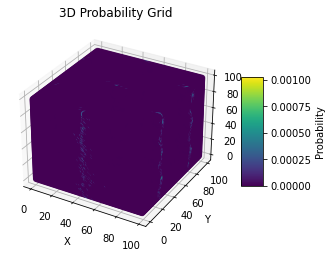

Computing Li positions: 100%|███████████████████| 12/12 [00:38<00:00,  3.23s/it]


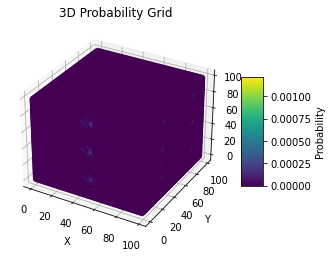

In [989]:
li_coords_all = []
num_samples = 100 #MAKE RANDOM
M = 100 #grid definition
N_positions_final = 50

for i in tqdm(range(1,13), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)
    
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])#[-48:])[:,2:]
        li_index = np.where(coords_tmp[:,0] == 'Li')[0]

        li_coords = np.array(coords_tmp[li_index][:,2:])
        li_coords = np.array(li_coords,dtype='float').tolist()
        li_coords_all.extend(li_coords)
        

li_coords_all = np.array(li_coords_all)
grid = compute_probability_grid(li_coords_all, M)

plot_probability_grid(grid)

centers = find_fractional_centers(M)
top_centers = find_top_x_points(grid,centers,N_positions_final)

coord_top = []
for line in top_centers:
    coord_top.append(line[0])
coord_top_low = np.array(coord_top)



li_coords_all = []
for i in tqdm(range(13,25), desc="Computing Li positions"):
    with open(f'data/database/config_size_{i}.pkl', 'rb') as file:
        data = pickle.load(file)
    samples = np.random.choice(len(data),num_samples)
    
    structure_n = np.array(list(data.keys()))[samples]

    for i in structure_n:
        coords_tmp = np.array(data[i]['final']['config'])#[-48:])[:,2:]
        li_index = np.where(coords_tmp[:,0] == 'Li')[0]

        li_coords = np.array(coords_tmp[li_index][:,2:])
        li_coords = np.array(li_coords,dtype='float').tolist()
        li_coords_all.extend(li_coords)
        

li_coords_all = np.array(li_coords_all)
grid = compute_probability_grid(li_coords_all, M)

plot_probability_grid(grid)

centers = find_fractional_centers(M)
top_centers = find_top_x_points(grid,centers,N_positions_final)

coord_top = []
for line in top_centers:
    coord_top.append(line[0])
coord_top_high = np.array(coord_top)

coord_top_all = np.append(coord_top_low,coord_top_high,axis=0)
vview(Structure(delithiated_structure_init.lattice.matrix,[1]*N_positions_final,coord_top))

In [990]:
li_structure = Structure(delithiated_structure_init.lattice.matrix,
                        [3]*len(coord_top_all),coord_top_all)

In [988]:
vview(li_structure)

In [991]:
structure_li_selected_positions = Structure.from_sites(li_structure.sites+delithiated_structure_init.sites)

In [965]:
vview(structure_li_selected_positions)

In [992]:
frac_coords = structure_li_selected_positions.frac_coords
lattice_vectors = structure_li_selected_positions.lattice.matrix

compute_ewald_matrix(frac_coords, lattice_vectors, sigma=None, R_max=None, G_max=None, 

                         max_shift = None,charge=None,w=1,print_info=False, triu=True, 
                         distance_analysis = True, distance_threshold = 1.0)

Computing real space:   8%|█▌                  | 13/172 [01:35<19:31,  7.37s/it]


KeyboardInterrupt: 

## Li on a grid

In [893]:
lattice_vectors = delithiated_structure_init.lattice.matrix
cart_coords_Mn = delithiated_structure_init.cart_coords[0:24]
cart_coords_O = delithiated_structure_init.cart_coords[24:]

grid_density = 5
x = np.arange(grid_density)/grid_density
y = np.arange(grid_density)/grid_density
z = np.arange(grid_density)/grid_density

# Use meshgrid to create a 3D grid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Stack the grids into a single NxNxN array
grid = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

cartesian_grid = grid @ lattice_vectors

threshold_Mn = 0.5
threshold_O = 0.5

# Check distances
keep_points = []
remove_points = []
for point in cartesian_grid:

    distances_Mn = np.linalg.norm(cart_coords_Mn - point, axis=1)
    distances_O = np.linalg.norm(cart_coords_O - point, axis=1)
#     print(distances_O)
    if np.all(distances_Mn >= threshold_Mn) and np.all(distances_O >= threshold_O):
        keep_points.append(point)
    else:
        remove_points.append(point)
#         print(np.where(distances_Mn < threshold_Mn)[0],np.where(distances_O < threshold_O)[0])

# vview(Structure(lattice_vectors,[1]*len(keep_points),keep_points,coords_are_cartesian=True))
sites_1 = Structure(lattice_vectors,[3]*len(keep_points),keep_points,coords_are_cartesian=True).sites

In [894]:
sites_2 = delithiated_structure_init.sites
grid_10 = Structure.from_sites(sites_1+sites_2)

In [895]:
vview(grid_10)

In [971]:
frac_coords = grid_10.frac_coords # I need them all
lattice_vectors = grid_10.lattice.matrix

atomic_numbers = np.array(grid_10.atomic_numbers)

charges_dict = {3:1,
                43:+3,
                8:-2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]
    
ewald_matrix = compute_ewald_matrix(frac_coords, lattice_vectors,sigma=None,max_shift = None,charge=charges,
                                    w=0.123,triu=True)
ewald_matrix_dl = calculate_ewald_matrix_charges(ewald_matrix,charges)

Computing real space:   1%|                     | 1/191 [00:05<18:22,  5.80s/it]


KeyboardInterrupt: 

## Concentration dependant QUBO

### Monte Carlo

In [734]:
def qubo_energy(x, q):
    # x is the binary vector
    # q is the qubo matrix
    
    # Efficient energy calculation
    E_classical = x @ q @ x
    
    return E_classical

In [738]:
num_sites = 48
N_Li = 10
N_structures = 1
Li_range = np.where(atomic_numbers==3)[0]
Mn_range = np.where(atomic_numbers==43)[0]

for conc in range(N_structures):   
    x = np.zeros(num_sites,dtype='int')
    ones = (np.random.choice(Li_range,N_Li, replace=False))
    x[ones] = 1
    ones = (np.random.choice(Mn_range,N_Li, replace=False))
    x[ones] = 1
    print(qubo_energy(x, Q_no_oxygen))

251.52468963930514


In [732]:
x

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Fully lithiated

In [674]:
Ewald_diff_no_oxygen.shape

(96, 96)

In [593]:
n_sites = fully_lithiated_structure_init.num_sites
cart_coords = fully_lithiated_structure_init.cart_coords
lattice = fully_lithiated_structure_init.lattice.matrix
atomic_numbers = np.array(fully_lithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}


charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

    
Q = np.zeros((n_sites,n_sites))

# Ewald
ewald_matrix_tmp_fl = compute_ewald_matrix(cart_coords, lattice)
ewald_matrix_fl = calculate_potential_energy(ewald_matrix_tmp_fl,charges)

Computing real space:   0%|                              | 0/96 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [219]:
ewald_matrix_tmp_fl

array([[-8.60554875e-02, -7.58630743e-04, -1.99648396e-04, ...,
        -1.51975546e-03,  9.35571132e-04, -9.80095954e-04],
       [-7.58630743e-04, -8.60554875e-02,  2.09211489e-03, ...,
         7.74569033e-04, -9.68266310e-04,  1.24631346e-03],
       [-1.99648396e-04,  2.09211489e-03, -8.60554875e-02, ...,
        -6.57879143e-06, -1.47023243e-03,  1.45460610e-03],
       ...,
       [-1.51975546e-03,  7.74569033e-04, -6.57879143e-06, ...,
        -8.60554875e-02, -1.95053182e-03,  2.17308715e-03],
       [ 9.35571132e-04, -9.68266310e-04, -1.47023243e-03, ...,
        -1.95053182e-03, -8.60554875e-02, -2.76386776e-03],
       [-9.80095954e-04,  1.24631346e-03,  1.45460610e-03, ...,
         2.17308715e-03, -2.76386776e-03, -8.60554875e-02]])

In [229]:
np.sum(ewald_matrix_fl)*0.5

-18.878428250027365

In [235]:
np.sum(np.triu(ewald_matrix_fl,1))

-4.182275604044863

### Delithiated

In [283]:
n_sites = delithiated_structure_init.num_sites
cart_coords = delithiated_structure_init.cart_coords
lattice = delithiated_structure_init.lattice.matrix
atomic_numbers = np.array(delithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                43:+3,
                25:+4,
                8:-2
}


charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

    
Q = np.zeros((n_sites,n_sites))

# Ewald
ewald_matrix_tmp_dl = compute_ewald_matrix(cart_coords, lattice)
ewald_matrix_dl = calculate_potential_energy(ewald_matrix_tmp_dl,charges)

Volume = 712.9853306128799
R_max = 10, G_max = 10
Begin real space t=-0.02750086784362793


KeyboardInterrupt: 

In [226]:
np.sum(np.triu(ewald_matrix_dl,1))

-0.35940969265687717

## Extra ideas
- start with a grid of points, do some MC, then remove some grid points (but which ones?)

## Extra functions

In [136]:
import numpy as np
from scipy.special import erfc
import math

def compute_ewald_matrix(positions, lattice_vectors, alpha=None, real_depth=5, reciprocal_depth=5):
    """
    Compute the Ewald summation matrix for a system of particles.

    Parameters:
    positions (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).
    alpha (float): Ewald parameter controlling the split between real and reciprocal sums. If None, it's calculated.
    real_depth (int): Depth of the real space summation.
    reciprocal_depth (int): Depth of the reciprocal space summation.

    Returns:
    ndarray: Ewald summation matrix (NxN).
    """
    N = len(positions)
    
    # Calculate alpha if not provided
    if alpha is None:
        alpha = 2 / (np.linalg.det(lattice_vectors) ** (1.0 / 3))
    
    # Convert relative positions to absolute positions using lattice vectors
    positions = positions @ lattice_vectors
    
    # Initialize the Ewald summation matrix
    ewald_matrix = np.zeros((N, N))
    
    # Real space summation
    for i in range(N):
        for j in range(i + 1, N):
            r_ij = positions[i] - positions[j]
            d_ij = np.linalg.norm(r_ij)
            ewald_matrix[i, j] = erfc(alpha * d_ij) / d_ij
            
            # Generate real space shifts for neighboring cells
            for shift in np.ndindex(2 * real_depth + 1, 2 * real_depth + 1, 2 * real_depth + 1):
                if shift != (real_depth, real_depth, real_depth):
                    shift_vector = (np.array(shift) - real_depth) @ lattice_vectors
                    r_shifted = r_ij + shift_vector
                    d_shifted = np.linalg.norm(r_shifted)
                    ewald_matrix[i, j] += erfc(alpha * d_shifted) / d_shifted

    # Self-interaction term correction
    for i in range(N):
        ewald_matrix[i, i] -= alpha / math.sqrt(math.pi)

    # Reciprocal space summation
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
    for i in range(N):
        for j in range(i, N):
            for shift in np.ndindex(2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1):
                if shift != (reciprocal_depth, reciprocal_depth, reciprocal_depth):
                    k = (np.array(shift) - reciprocal_depth) @ reciprocal_vectors
                    k_norm = np.linalg.norm(k)
                    if k_norm > 0:
                        k_dot_r = np.dot(k, positions[j] - positions[i])
                        term = (4 * math.pi / (np.linalg.det(lattice_vectors) * k_norm**2)) * \
                               math.exp(-k_norm**2 / (4 * alpha**2)) * math.cos(k_dot_r)
                        ewald_matrix[i, j] += term
    
    # Convert to electrostatic potential energy (unit conversion)
    ewald_matrix *= 14.399645351950543  # Convert to appropriate units, e.g., eV for electrostatic potential
    
    # Symmetry completion: Ensure the matrix is symmetric
    for i in range(N):
        for j in range(i):
            ewald_matrix[i, j] = ewald_matrix[j, i]
    
    return ewald_matrix

def calculate_potential_energy(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
    return charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix


n_sites = delithiated_structure_init.num_sites
cart_coords = delithiated_structure_init.cart_coords
lattice = delithiated_structure_init.lattice.matrix
atomic_numbers = np.array(delithiated_structure_init.atomic_numbers)

charges_dict = {3:+1,
                25:+4,
                8:-2
}


charges = np.zeros(n_sites)
for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

    
Q = np.zeros((n_sites,n_sites))

# Ewald
# ewald_matrix_tmp_dl = compute_ewald_matrix(cart_coords, lattice, alpha=0.5)
ewald_matrix_dl = calculate_potential_energy(ewald_matrix_tmp_dl,charges)

SyntaxError: invalid character '÷' (U+00F7) (1416449725.py, line 108)

In [135]:
ewald_matrix_dl

1649.773429867818

In [120]:
import numpy as np

# Sample arrays
array1 = np.array([[3, 1, 2], [6, 5, 4], [9, 8, 7]])
array2 = np.array([[9, 8, 7], [3, 1, 2], [6, 5, 4]])

def find_reordering_index(arr1, arr2):
    # Ensure that each row can be uniquely identified by sorting each row lexicographically
    arr1_sorted_indices = np.lexsort(arr1.T)
    arr2_sorted_indices = np.lexsort(arr2.T)
    
    # Get the sorted arrays
    arr1_sorted = arr1[arr1_sorted_indices]
    arr2_sorted = arr2[arr2_sorted_indices]
    
    # Create a mapping from sorted arr2 to sorted arr1 indices
    mapping = np.argsort(arr2_sorted_indices)
    
    # Reorder the indices to match the original arr2
    reordering_indices = arr1_sorted_indices[mapping]
    
    return reordering_indices

# Get the reordering indices
reordering_indices = find_reordering_index(array1, array2)

# Reorder array1 to match array2
reordered_array1 = array1[reordering_indices]

print("Reordered array1 to match array2:")
print(reordering_indices)


Reordered array1 to match array2:
[2 0 1]


\text{Unit Cell Information:}

\begin{equation}
L_x = L_y = L_z = 4.2112 \, \text{\AA}
\end{equation}

\begin{equation}
V = L_x \cdot L_y \cdot L_z \, \text{(\AA}^3\text{)}
\end{equation}

\text{Ewald Summation Cut-offs and Sigma:}

\begin{equation}
\text{rcut} = \text{gcut} = 100 \, \text{\AA}
\end{equation}

\begin{equation}
\Sigma = \frac{L_x + L_y + L_z}{5.6}
\end{equation}

\text{Ion Information:}

\begin{equation}
\text{Number of Ions} = 8
\end{equation}

\begin{equation}
\text{Charges:}
\end{equation}

\begin{equation}
q_0 = q_1 = q_2 = q_3 = +2
\end{equation}

\begin{equation}
q_4 = q_5 = q_6 = q_7 = -2
\end{equation}

\text{Fractional Coordinates:}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_0 = (0.0, 0.0, 0.0)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_1 = (0.5, 0.52, 0.0)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_2 = (0.5, 0.0, 0.5)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_3 = (0.0, 0.52, 0.5)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_4 = (0.5, 0.5, 0.5)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_5 = (0.5, 0.0, 0.0)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_6 = (0.0, 0.5, 0.0)
\end{equation}

\begin{equation}
(\text{frac\_x}, \text{frac\_y}, \text{frac\_z})_7 = (0.0, 0.0, 0.5)
\end{equation}

\text{Real Space Summation:}

\begin{equation}
\text{Real\_E} = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \sum_{rnx=-nx}^{nx} \sum_{rny=-ny}^{ny} \sum_{rnz=-nz}^{nz} \left\{
\begin{aligned}
& \frac{0.5 \cdot q_i \cdot q_j}{\text{norm}(\mathbf{dr})} \cdot \text{erfc} \left( \frac{\text{norm}(\mathbf{dr})}{\Sigma} \right) \cdot \text{TO\_EV} & \text{if } \text{norm}(rnx \cdot L_x, rny \cdot L_y, rnz \cdot L_z) < \text{rcut} \\
& \mathbf{dr} = \mathbf{r_i} - \mathbf{r_j} - rnx \cdot L_x - rny \cdot L_y - rnz \cdot L_z \\
\end{aligned}
\right\}
\end{equation}

\text{Reciprocal Space Summation:}

\begin{equation}
\text{Reci\_E} = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \sum_{rnx=-nx}^{nx} \sum_{rny=-ny}^{ny} \sum_{rnz=-nz}^{nz} \left\{
\begin{aligned}
& \text{TO\_EV} \cdot \frac{2 \cdot \pi}{V} \cdot q_i \cdot q_j \cdot \frac{\exp \left( -0.25 \cdot \Sigma^2 \cdot g^2 \right)}{g^2} \cdot \cos \left( \text{dp}(\mathbf{gr}, \mathbf{dr}) \right) & \text{if } \text{norm}(\mathbf{gr}) < \text{gcut} \\
& \mathbf{gr} = \frac{2 \cdot \pi}{L_x} \cdot rnx, \frac{2 \cdot \pi}{L_y} \cdot rny, \frac{2 \cdot \pi}{L_z} \cdot rnz \\
\end{aligned}
\right\}
\end{equation}

\text{Self-interaction Correction:}

\begin{equation}
\text{Reci\_self} = \sum_{i=0}^{N-1} -\frac{q_i^2}{\Sigma \cdot \sqrt{\pi}} \cdot \text{TO\_EV}
\end{equation}

\text{Total Energy:}

\begin{equation}
\text{Total\_E} = \text{Real\_E} + \text{Reci\_E} + \text{Reci\_self}
\end{equation}


In [139]:

import numpy as np
import math

def compute_ewald_matrix(positions, lattice_vectors, alpha=None, real_depth=5, reciprocal_depth=5):
    """
    Compute the Ewald summation matrix for a system of particles.

    Parameters:
    positions (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).
    alpha (float): Ewald parameter controlling the split between real and reciprocal sums. If None, it's calculated.
    real_depth (int): Depth of the real space summation.
    reciprocal_depth (int): Depth of the reciprocal space summation.

    Returns:
    ndarray: Ewald summation matrix (NxN).
    """
    N = len(positions)
    
    # Calculate alpha if not provided
    if alpha is None:
        # Other approach
        alpha = 2 / (np.linalg.det(lattice_vectors) ** (1.0 / 3))
        
        # GULP approach
        w = 1  
        V = np.linalg.det(lattice_vectors)

        # Calculate alpha (eta_opt)
        alpha = ((N * w * np.pi**3) / V**2)**(1/3)
    
    # Max radii
    # Calculate f
    A = 1e-8 
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    R_max = f * np.sqrt(alpha)
    G_max = 2 * f * np.sqrt(alpha)
    
    # Convert relative positions to absolute positions using lattice vectors
    positions = positions @ lattice_vectors
    
    # Initialize the Ewald summation matrix
    ewald_matrix = np.zeros((N, N))
    
    # Generate real space shifts for neighboring cells
    real_shifts = np.array([np.dot(np.array(shift) - real_depth, lattice_vectors)
                            for shift in np.ndindex(2 * real_depth + 1, 2 * real_depth + 1, 2 * real_depth + 1)
                            if shift != (real_depth, real_depth, real_depth)])
    
    # Real space summation
    for i in range(N):
        for j in range(i, N):
            if i != j:
                r_ij = positions[i] - positions[j]
                d_ij = np.linalg.norm(r_ij)
                ewald_matrix[i, j] += math.erfc(alpha * d_ij) / d_ij
                
                # Include contributions from neighboring cells
                for shift in real_shifts:
                    r_shifted = r_ij + shift
                    d_shifted = np.linalg.norm(r_shifted)
                    ewald_matrix[i, j] += math.erfc(alpha * d_shifted) / d_shifted
    
    # Self-interaction term correction
    for i in range(N):
        ewald_matrix[i, i] -= alpha / math.sqrt(math.pi)
    
    # Generate reciprocal space shifts for the Fourier transform contributions
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
    reciprocal_shifts = np.array([np.dot(np.array(shift) - reciprocal_depth, reciprocal_vectors)
                                  for shift in np.ndindex(2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1)
                                  if shift != (reciprocal_depth, reciprocal_depth, reciprocal_depth)])
    
    # Reciprocal space summation
    for i in range(N):
        for j in range(i, N):
            for k in reciprocal_shifts:
                k_norm = np.linalg.norm(k)
                if k_norm > 0: # within a sphere
                    k_dot_r = np.dot(k, positions[j] - positions[i])
                    term = (4 * math.pi / (np.linalg.det(lattice_vectors) * k_norm**2)) * \
                           math.exp(-k_norm**2 / (4 * alpha**2)) * math.cos(k_dot_r)
                    ewald_matrix[i, j] += term
    
    # Convert to electrostatic potential energy (unit conversion)
    ewald_matrix *= 14.399645351950543  # Convert to appropriate units, e.g., eV for electrostatic potential
    
    # Symmetry completion: Ensure the matrix is symmetric
    for i in range(N):
        for j in range(i):
            ewald_matrix[i, j] = ewald_matrix[j, i]
    
    return ewald_matrix

def calculate_potential_energy(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
#     return 0.5 * np.sum(charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix)
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

# Example usage:
positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])  # Example positions in fractional coordinates
lattice_vectors = np.eye(3)  # Example lattice vectors (unit cube)

# Compute the Ewald matrix once
ewald_matrix = compute_ewald_matrix(positions, lattice_vectors)

# Different sets of charges
charges_list = [
    np.array([1.0, -1.0]),
    np.array([1.0, 1.0]),
    np.array([-1.0, -1.0])
]

# Calculate potential energy for each set of charges
for charges in charges_list:
    potential_energy = calculate_potential_energy(ewald_matrix, charges)
    print(f"Charges: {charges},\n Potential Energy:\n {potential_energy}")


[[-31.41592654 -31.41592654 -31.41592654]
 [-31.41592654 -31.41592654 -25.13274123]
 [-31.41592654 -31.41592654 -18.84955592]
 ...
 [ 31.41592654  31.41592654  18.84955592]
 [ 31.41592654  31.41592654  25.13274123]
 [ 31.41592654  31.41592654  31.41592654]]
Charges: [ 1. -1.],
 Potential Energy:
 [[-13.71031325   0.23813855]
 [  0.23813855 -13.71031325]]
Charges: [1. 1.],
 Potential Energy:
 [[-13.71031325  -0.23813855]
 [ -0.23813855 -13.71031325]]
Charges: [-1. -1.],
 Potential Energy:
 [[-13.71031325  -0.23813855]
 [ -0.23813855 -13.71031325]]


## THIS WORKS, but i need to make it applicable to non cubic lattices

In [545]:
1/Sigma

0.4432624113475177

In [543]:
# KYU SAVE
import numpy as np
import math

TO_EV = 14.39964390675221758120

def dp(r1, r2):
    return r1[0]*r2[0] + r1[1]*r2[1] + r1[2]*r2[2]

def norm(r):
    return math.sqrt(dp(r, r))

def norm_xyz(x, y, z):
    return math.sqrt(x*x + y*y + z*z)

def get_cart(Lx, Ly, Lz, frac_x, frac_y, frac_z, index):
    return [Lx*frac_x[index], Ly*frac_y[index], Lz*frac_z[index]]

# UnitCell Info
Lx = Ly = Lz = 4.2112  # In Angstroms
V = Lx * Ly * Lz  # In Angstroms^3

lattice_vectors = np.zeros((3,3))
lattice_vectors[0][0] = Lx
lattice_vectors[1][1] = Lx
lattice_vectors[2][2] = Lx

Real_E = Reci_E = 0.0  # In eV

# Ion Info
NumberOfIons = 8

frac_coords = np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.52, 0.0],
    [0.5, 0.0, 0.5],
    [0.0, 0.52, 0.5],
    [0.5, 0.5, 0.5],
    [0.5, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5]
])
frac_x = [0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 0.0]
frac_y = [0.0, 0.52, 0.0, 0.52, 0.5, 0.0, 0.5, 0.0]
frac_z = [0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.5]

charge = [2, 2, 2, 2, -2, -2, -2, -2]
charge = [1]*8

cart_x = [Lx * frac for frac in frac_x]
cart_y = [Ly * frac for frac in frac_y]
cart_z = [Lz * frac for frac in frac_z]

print([2 * np.pi / Lx , 2 * np.pi / Ly , 2 * np.pi / Lz ])
# EwaldSum Info
rcut = gcut = 10
10.0  # cut offs, set to 50 Angstroms
Sigma = (Lx + Ly + Lz) / 5.6

nx = ny = nz = 30

# Main computation
iter = 1

Ewald_real = np.zeros((NumberOfIons,NumberOfIons))
Ewald_recip = np.zeros((NumberOfIons,NumberOfIons))
Ewald_recip_self = np.zeros((NumberOfIons,NumberOfIons))
for i in range(NumberOfIons):
    for j in range(NumberOfIons):
        dr = [cart_x[i] - cart_x[j], cart_y[i] - cart_y[j], cart_z[i] - cart_z[j]]
        dr_frac = frac_coords[i]-frac_coords[j]
        for rnx in range(-nx, nx + 1):
            for rny in range(-ny, ny + 1):
                for rnz in range(-nz, nz + 1):
                    lattice_translation = np.array([rnx, rny, rnz])
                    shift = lattice_translation @ lattice_vectors
                    if np.linalg.norm(shift) < rcut:
#                     if norm_xyz(rnx*Lx, rny*Ly, rnz*Lz) < rcut:

#                         print((np.array([rnx, rny, rnz])*lattice_vectors)) #THIS WORKS
                        if rnx == 0 and rny == 0 and rnz == 0:
                            if i != j:

                                dr = [cart_x[i] - cart_x[j] - rnx*Lx,
                                      cart_y[i] - cart_y[j] - rny*Ly,
                                      cart_z[i] - cart_z[j] - rnz*Lz]
                                # Apply periodic boundary conditions
                                
                                displacement_frac_shifted = dr_frac + lattice_translation

                                # Convert to Cartesian coordinates
                                ddr = displacement_frac_shifted @ lattice_vectors
#                                 print(dr-ddr)
                                Ewald_real[i,j] += 0.5 / norm(ddr) * math.erfc(norm(ddr)/Sigma) * TO_EV
                                Real_E          += 0.5 * charge[i] * charge[j] / norm(ddr) * math.erfc(norm(ddr)/Sigma) * TO_EV
                            else:
                                Ewald_recip_self[i,j] += -1 / Sigma / math.sqrt(np.pi) * TO_EV
                      
                        else:
                            dr = [cart_x[i] - cart_x[j] - rnx*Lx,
                                  cart_y[i] - cart_y[j] - rny*Ly,
                                  cart_z[i] - cart_z[j] - rnz*Lz]
                            Ewald_real[i,j] += 0.5 / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
                            Real_E          += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
                              # Reciprocal sum
                        gr = [2 * np.pi / Lx * rnx, 2 * np.pi / Ly * rny, 2 * np.pi / Lz * rnz]
                        if norm(gr) < gcut:
                            if not (rnx == 0 and rny == 0 and rnz == 0):
                                g_2 = dp(gr, gr)
#                                 print(gr,g_2)
                                Reci_E += TO_EV * (2 * np.pi / V) * (charge[i] * charge[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(dp(gr, dr))
                                Ewald_recip[i,j] +=  TO_EV * (2 * np.pi / V) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(dp(gr, dr))

Ewald_full = Ewald_real+Ewald_recip+Ewald_recip_self
print(f"Real sum: {Real_E:.8f} eV")
print(f"Reciprocal sum: {Reci_E:.8f} eV")

Reci_self = sum(-(charge[i]**2) / Sigma / math.sqrt(np.pi) * TO_EV for i in range(NumberOfIons))

print(f"Reciprocal self (eV): {Reci_self:.16f}")
print(f"Real (eV): {Real_E:.16f}")
print(f"Reciprocal (eV): {Reci_self + Reci_E:.16f}")
print(f"Total (eV): {Real_E + Reci_E + Reci_self:.16f}")

print(f"Cell Info (Angstroms): {Lx:.4f}\t{Ly:.4f}\t{Lz:.4f}")
for i in range(NumberOfIons):
    print(f"Ion {i+1}: {charge[i]:.6f}\t{frac_x[i]:.6f}\t{frac_y[i]:.6f}\t{frac_z[i]:.6f}")


[1.4920177876091343, 1.4920177876091343, 1.4920177876091343]
Real sum: 49.88952277 eV
Reciprocal sum: 0.00468543 eV
Reciprocal self (eV): -28.8089684361224201
Real (eV): 49.8895227723446695
Reciprocal (eV): -28.8042830105512273
Total (eV): 21.0852397617934386
Cell Info (Angstroms): 4.2112	4.2112	4.2112
Ion 1: 1.000000	0.000000	0.000000	0.000000
Ion 2: 1.000000	0.500000	0.520000	0.000000
Ion 3: 1.000000	0.500000	0.000000	0.500000
Ion 4: 1.000000	0.000000	0.520000	0.500000
Ion 5: 1.000000	0.500000	0.500000	0.500000
Ion 6: 1.000000	0.500000	0.000000	0.000000
Ion 7: 1.000000	0.000000	0.500000	0.000000
Ion 8: 1.000000	0.000000	0.000000	0.500000


In [512]:
np.linalg.norm(lattice_vectors)

7.2940123608340555

In [ ]:
np.charge

In [495]:
E_tot = 0
for i in range(8):
    for j in range(i,8):
        E_tot += charge[i]*charge[j]* Ewald_full[i,j]

In [496]:
E_tot

-148.55931754984687

In [636]:
import numpy as np
import math
import copy
import time

TO_EV = 14.39964390675221758120

def dp(r1, r2):
    return r1[0]*r2[0] + r1[1]*r2[1] + r1[2]*r2[2]

def norm(r):
    return math.sqrt(dp(r, r))

def norm_xyz(x, y, z):
    return math.sqrt(x*x + y*y + z*z)

def get_cart(Lx, Ly, Lz, frac_x, frac_y, frac_z, index):
    return [Lx*frac_x[index], Ly*frac_y[index], Lz*frac_z[index]]

# Start timing
start_time = time.time()

# UnitCell Info
Lx = Ly = Lz = 4.2112  # In Angstroms
Lx = s.lattice.a
Ly = s.lattice.b
Lz = s.lattice.c

lattice_vectors = s.lattice.matrix
V = Lx * Ly * Lz  # In Angstroms^3
V = np.linalg.det(lattice_vectors)

Real_E = Reci_E = 0.0  # In eV

# Print lattice info time
print(f"Time after lattice info: {time.time() - start_time:.2f} seconds")

# Ion Info
NumberOfIons = s.num_sites

frac_x = s.frac_coords[:, 0]
frac_y = s.frac_coords[:, 1]
frac_z = s.frac_coords[:, 2]

charge = copy.deepcopy(charges)  # check this

cart_x = s.cart_coords[:, 0]
cart_y = s.cart_coords[:, 1]
cart_z = s.cart_coords[:, 2]

# Print ion info time
print(f"Time after ion info: {time.time() - start_time:.2f} seconds")

# EwaldSum Info
rcut = gcut = 50.0  # cut offs, set to 50 Angstroms
Sigma = (Lx + Ly + Lz) / 5.6

nx = ny = nz = 10

# Main computation
iter = 1
computation_start_time = time.time()
for i in range(NumberOfIons):
    for j in range(NumberOfIons):
        dr = [cart_x[i] - cart_x[j], cart_y[i] - cart_y[j], cart_z[i] - cart_z[j]]

        for rnx in range(-nx, nx + 1):
            for rny in range(-ny, ny + 1):
                for rnz in range(-nz, nz + 1):
                    print(norm_xyz(rnx*Lx, rny*Ly, rnz*Lz),rnx*Lx, rny*Ly, rnz*Lz)
                    print()
                    if norm_xyz(rnx*Lx, rny*Ly, rnz*Lz) < rcut:
                        if rnx == 0 and rny == 0 and rnz == 0:
                            if i != j:
                                dr = [cart_x[i] - cart_x[j] - rnx*Lx,
                                      cart_y[i] - cart_y[j] - rny*Ly,
                                      cart_z[i] - cart_z[j] - rnz*Lz]
                                Real_E += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
#                                 print(dr)
#                                 print()
                        else:
                            dr = [cart_x[i] - cart_x[j] - rnx*Lx,
                                  cart_y[i] - cart_y[j] - rny*Ly,
                                  cart_z[i] - cart_z[j] - rnz*Lz]

                            Real_E += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
                            
                        # Reciprocal sum
                        gr = [2 * np.pi / Lx * rnx, 2 * np.pi / Ly * rny, 2 * np.pi / Lz * rnz]
#                         print(gr)
                        if norm(gr) < gcut:
#                             print('yes')
                            if not (rnx == 0 and rny == 0 and rnz == 0):
                                g_2 = dp(gr, gr)
                                Reci_E += TO_EV * (2 * np.pi / V) * (charge[i] * charge[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(dp(gr, dr))

# Print computation time
print(f"Time after computation: {time.time() - computation_start_time:.2f} seconds")
print(f"Total computation time: {time.time() - start_time:.2f} seconds")

print(f"Real sum: {Real_E:.8f} eV")
print(f"Reciprocal sum: {Reci_E:.8f} eV")

Reci_self = sum(-(charge[i]**2) / Sigma / math.sqrt(np.pi) * TO_EV for i in range(NumberOfIons))

print(f"Reciprocal self (eV): {Reci_self:.16f}")
print(f"Real (eV): {Real_E:.16f}")
print(f"Reciprocal (eV): {Reci_self + Reci_E:.16f}")
print(f"Total (eV): {Real_E + Reci_E + Reci_self:.16f}")

# print(f"Cell Info (Angstroms): {Lx:.4f}\t{Ly:.4f}\t{Lz:.4f}")
# for i in range(NumberOfIons):
#     print(f"Ion {i+1}: {charge[i]:.6f}\t{frac_x[i]:.6f}\t{frac_y[i]:.6f}\t{frac_z[i]:.6f}")


Time after lattice info: 0.00 seconds
Time after ion info: 0.01 seconds
154.98144832527538 -88.435 -94.19399999999999 -85.59200000000001

150.42377184753744 -88.435 -94.19399999999999 -77.03280000000001

146.22548600692014 -88.435 -94.19399999999999 -68.4736

142.41837728453444 -88.435 -94.19399999999999 -59.9144

139.03458356840574 -88.435 -94.19399999999999 -51.3552

136.105681281128 -88.435 -94.19399999999999 -42.79600000000001

133.66157763261663 -88.435 -94.19399999999999 -34.2368

131.7292602376556 -88.435 -94.19399999999999 -25.6776

130.3314945803968 -88.435 -94.19399999999999 -17.1184

129.48559288832098 -88.435 -94.19399999999999 -8.5592

129.2023949507129 -88.435 -94.19399999999999 0.0

129.48559288832098 -88.435 -94.19399999999999 8.5592

130.3314945803968 -88.435 -94.19399999999999 17.1184

131.7292602376556 -88.435 -94.19399999999999 25.6776

133.66157763261663 -88.435 -94.19399999999999 34.2368

136.105681281128 -88.435 -94.19399999999999 42.79600000000001

139.034583568

91.13446775907566 -79.59150000000001 -28.2582 -34.2368

88.27611161152264 -79.59150000000001 -28.2582 -25.6776

86.17640255922733 -79.59150000000001 -28.2582 -17.1184

84.89165238190385 -79.59150000000001 -28.2582 -8.5592

84.45905954656375 -79.59150000000001 -28.2582 0.0

84.89165238190385 -79.59150000000001 -28.2582 8.5592

86.17640255922733 -79.59150000000001 -28.2582 17.1184

88.27611161152264 -79.59150000000001 -28.2582 25.6776

91.13446775907566 -79.59150000000001 -28.2582 34.2368

94.68278806356518 -79.59150000000001 -28.2582 42.79600000000001

98.84679714856725 -79.59150000000001 -28.2582 51.3552

103.55224800481157 -79.59150000000001 -28.2582 59.9144

108.72886753962814 -79.59150000000001 -28.2582 68.4736

114.31266340755954 -79.59150000000001 -28.2582 77.03280000000001

120.24692596274552 -79.59150000000001 -28.2582 85.59200000000001

118.38791205900206 -79.59150000000001 -18.8388 -85.59200000000001

112.35550513228091 -79.59150000000001 -18.8388 -77.03280000000001

106.66930

76.66201977433154 -70.748 -28.2582 -8.5592

76.18271044823753 -70.748 -28.2582 0.0

76.66201977433154 -70.748 -28.2582 8.5592

78.08229626362176 -70.748 -28.2582 17.1184

80.39368453429661 -70.748 -28.2582 25.6776

83.52223563506907 -70.748 -28.2582 34.2368

87.38022080104857 -70.748 -28.2582 42.79600000000001

91.87579625929781 -70.748 -28.2582 51.3552

96.92028012031332 -70.748 -28.2582 59.9144

102.43260842231834 -70.748 -28.2582 68.4736

108.3413939686951 -70.748 -28.2582 77.03280000000001

114.58532120319776 -70.748 -28.2582 85.59200000000001

112.63290084802044 -70.748 -18.8388 -85.59200000000001

106.27432505210278 -70.748 -18.8388 -77.03280000000001

100.24377180852684 -70.748 -18.8388 -68.4736

94.60399154792572 -70.748 -18.8388 -59.9144

89.42894641266888 -70.748 -18.8388 -51.3552

84.80375879311012 -70.748 -18.8388 -42.79600000000001

80.82288267365871 -70.748 -18.8388 -34.2368

77.58555942441868 -70.748 -18.8388 -25.6776

75.18789469056838 -70.748 -18.8388 -17.1184

73.7118


84.16214278409267 -61.904500000000006 37.6776 42.79600000000001

88.82074773975954 -61.904500000000006 37.6776 51.3552

94.02927198149521 -61.904500000000006 37.6776 59.9144

99.70156748502002 -61.904500000000006 37.6776 68.4736

105.76304145517942 -61.904500000000006 37.6776 77.03280000000001

112.15060912010243 -61.904500000000006 37.6776 85.59200000000001

115.65589043905202 -61.904500000000006 47.096999999999994 -85.59200000000001

109.47304145354691 -61.904500000000006 47.096999999999994 -77.03280000000001

103.62880114239478 -61.904500000000006 47.096999999999994 -68.4736

98.18365371389476 -61.904500000000006 47.096999999999994 -59.9144

93.20756995164072 -61.904500000000006 47.096999999999994 -51.3552

88.77945790130732 -61.904500000000006 47.096999999999994 -42.79600000000001

84.985016346942 -61.904500000000006 47.096999999999994 -34.2368

81.91235359217802 -61.904500000000006 47.096999999999994 -25.6776

79.64505099383138 -61.904500000000006 47.096999999999994 -17.1184

78.

91.06554021719742 -44.2175 -75.3552 25.6776

93.83896817170358 -44.2175 -75.3552 34.2368

97.28869969986236 -44.2175 -75.3552 42.79600000000001

101.34569571683842 -44.2175 -75.3552 51.3552

105.94021333115202 -44.2175 -75.3552 59.9144

111.0055285571399 -44.2175 -75.3552 68.4736

116.48023759045995 -44.2175 -75.3552 77.03280000000001

122.30937796134032 -44.2175 -75.3552 85.59200000000001

116.74205536947687 -44.2175 -65.9358 -85.59200000000001

110.61993176516609 -44.2175 -65.9358 -77.03280000000001

104.83964386075527 -44.2175 -65.9358 -68.4736

99.46080813692396 -44.2175 -65.9358 -59.9144

94.55196240655188 -44.2175 -65.9358 -51.3552

90.18988105042605 -44.2175 -65.9358 -42.79600000000001

86.4573623361828 -44.2175 -65.9358 -34.2368

83.43893677204906 -44.2175 -65.9358 -25.6776

81.21426381153745 -44.2175 -65.9358 -17.1184

79.8497146678058 -44.2175 -65.9358 -8.5592

79.38965315385879 -44.2175 -65.9358 0.0

79.8497146678058 -44.2175 -65.9358 8.5592

81.21426381153745 -44.2175 -65.9


48.403361058918215 -35.374 28.2582 -17.1184

46.07717057155311 -35.374 28.2582 -8.5592

45.27522217769892 -35.374 28.2582 0.0

46.07717057155311 -35.374 28.2582 8.5592

48.403361058918215 -35.374 28.2582 17.1184

52.04983078742908 -35.374 28.2582 25.6776

56.762700935385375 -35.374 28.2582 34.2368

62.30042824282992 -35.374 28.2582 42.79600000000001

68.46314563529783 -35.374 28.2582 51.3552

75.0971442239983 -35.374 28.2582 59.9144

82.08824300836265 -35.374 28.2582 68.4736

89.35266095131135 -35.374 28.2582 77.03280000000001

96.8289017145191 -35.374 28.2582 85.59200000000001

99.98455821655664 -35.374 37.6776 -85.59200000000001

92.7629974375559 -35.374 37.6776 -77.03280000000001

85.7878506241997 -35.374 37.6776 -68.4736

79.12431197249049 -35.374 37.6776 -59.9144

72.85793014353345 -35.374 37.6776 -51.3552

67.10006731561452 -35.374 37.6776 -42.79600000000001

61.99257933011015 -35.374 37.6776 -34.2368

57.70840978159076 -35.374 37.6776 -25.6776

54.44227251245121 -35.374 37.6776

96.6901938543925 -17.687 -65.9358 -68.4736

90.83003367829387 -17.687 -65.9358 -59.9144

85.42667181671074 -17.687 -65.9358 -51.3552

80.57206281733143 -17.687 -65.9358 -42.79600000000001

76.37092486594621 -17.687 -65.9358 -34.2368

72.93626555013631 -17.687 -65.9358 -25.6776

70.38039008985388 -17.687 -65.9358 -17.1184

68.80130518587566 -17.687 -65.9358 -8.5592

68.26682716107436 -17.687 -65.9358 0.0

68.80130518587566 -17.687 -65.9358 8.5592

70.38039008985388 -17.687 -65.9358 17.1184

72.93626555013631 -17.687 -65.9358 25.6776

76.37092486594621 -17.687 -65.9358 34.2368

80.57206281733143 -17.687 -65.9358 42.79600000000001

85.42667181671074 -17.687 -65.9358 51.3552

90.83003367829387 -17.687 -65.9358 59.9144

96.6901938543925 -17.687 -65.9358 68.4736

102.92915994255468 -17.687 -65.9358 77.03280000000001

109.48219103872557 -17.687 -65.9358 85.59200000000001

104.08133311002508 -17.687 -56.5164 -85.59200000000001

97.16473492888251 -17.687 -56.5164 -77.03280000000001

90.52937277

74.60138910536453 -8.8435 28.2582 68.4736

82.52748412092787 -8.8435 28.2582 77.03280000000001

90.56888993186348 -8.8435 28.2582 85.59200000000001

93.9350812955948 -8.8435 37.6776 -85.59200000000001

86.20824386246365 -8.8435 37.6776 -77.03280000000001

78.65394415393294 -8.8435 37.6776 -68.4736

71.32702406080041 -8.8435 37.6776 -59.9144

64.30525329279094 -8.8435 37.6776 -51.3552

57.70014428066884 -8.8435 37.6776 -42.79600000000001

51.67172832652301 -8.8435 37.6776 -34.2368

46.445109277188706 -8.8435 37.6776 -25.6776

42.3184197787441 -8.8435 37.6776 -17.1184

39.63671200604308 -8.8435 37.6776 -8.5592

38.70153787654956 -8.8435 37.6776 0.0

39.63671200604308 -8.8435 37.6776 8.5592

42.3184197787441 -8.8435 37.6776 17.1184

46.445109277188706 -8.8435 37.6776 25.6776

51.67172832652301 -8.8435 37.6776 34.2368

57.70014428066884 -8.8435 37.6776 42.79600000000001

64.30525329279094 -8.8435 37.6776 51.3552

71.32702406080041 -8.8435 37.6776 59.9144

78.65394415393294 -8.8435 37.6776 

68.69335362646083 8.8435 -65.9358 17.1184

71.30972132640822 8.8435 -65.9358 25.6776

74.8190863893031 8.8435 -65.9358 34.2368

79.1026853519525 8.8435 -65.9358 42.79600000000001

84.04221427907525 8.8435 -65.9358 51.3552

89.52917145405736 8.8435 -65.9358 59.9144

95.46921551395508 8.8435 -65.9358 68.4736

101.78305109265492 8.8435 -65.9358 77.03280000000001

108.40538583433022 8.8435 -65.9358 85.59200000000001

102.94805207098385 8.8435 -56.5164 -85.59200000000001

95.94979539868754 8.8435 -56.5164 -77.03280000000001

89.22412710791852 8.8435 -56.5164 -68.4736

82.83746911011949 8.8435 -56.5164 -59.9144

76.87436196971004 8.8435 -56.5164 -51.3552

71.44094468307372 8.8435 -56.5164 -42.79600000000001

66.66685409894485 8.8435 -56.5164 -34.2368

62.70287156877267 8.8435 -56.5164 -25.6776

59.71055668615057 8.8435 -56.5164 -17.1184

57.840909967340586 8.8435 -56.5164 -8.5592

57.20411664565759 8.8435 -56.5164 0.0

57.840909967340586 8.8435 -56.5164 8.5592

59.71055668615057 8.8435 -56.5

48.90573230736863 17.687 37.6776 -25.6776

45.00523446578187 17.687 37.6776 -17.1184

42.49342790832484 17.687 37.6776 -8.5592

41.62248804144221 17.687 37.6776 0.0

42.49342790832484 17.687 37.6776 8.5592

45.00523446578187 17.687 37.6776 17.1184

48.90573230736863 17.687 37.6776 25.6776

53.894248162489475 17.687 37.6776 34.2368

59.6986526377271 17.687 37.6776 42.79600000000001

66.10437260726404 17.687 37.6776 51.3552

72.95318250851021 17.687 37.6776 59.9144

80.13155063843456 17.687 37.6776 68.4736

87.55845925209056 17.687 37.6776 77.03280000000001

95.1757425753012 17.687 37.6776 85.59200000000001

99.28216275847339 17.687 47.096999999999994 -85.59200000000001

92.00548708549941 17.687 47.096999999999994 -77.03280000000001

84.96817801365403 17.687 47.096999999999994 -68.4736

78.23485607681528 17.687 47.096999999999994 -59.9144

71.89098653544823 17.687 47.096999999999994 -51.3552

66.0488833667913 17.687 47.096999999999994 -42.79600000000001

60.853232060754166 17.687 47.0969

101.8797115268786 35.374 -56.5164 -77.03280000000001

95.5722618855492 35.374 -56.5164 -68.4736

89.63904658306 35.374 -56.5164 -59.9144

84.15925327615497 35.374 -56.5164 -51.3552

79.22702165902743 35.374 -56.5164 -42.79600000000001

74.95052914556373 35.374 -56.5164 -34.2368

71.44762058123419 35.374 -56.5164 -25.6776

68.83649441626149 35.374 -56.5164 -17.1184

67.22115180209276 35.374 -56.5164 -8.5592

66.67400801631771 35.374 -56.5164 0.0

67.22115180209276 35.374 -56.5164 8.5592

68.83649441626149 35.374 -56.5164 17.1184

71.44762058123419 35.374 -56.5164 25.6776

74.95052914556373 35.374 -56.5164 34.2368

79.22702165902743 35.374 -56.5164 42.79600000000001

84.15925327615497 35.374 -56.5164 51.3552

89.63904658306 35.374 -56.5164 59.9144

95.5722618855492 35.374 -56.5164 68.4736

101.8797115268786 35.374 -56.5164 77.03280000000001

108.49614651663902 35.374 -56.5164 85.59200000000001

103.90109599518188 35.374 -47.096999999999994 -85.59200000000001

96.97164307590133 35.374 -47

83.45372475432119 44.2175 37.6776 59.9144

89.79656310221456 44.2175 37.6776 68.4736

96.48233581257246 44.2175 37.6776 77.03280000000001

103.44457120608119 44.2175 37.6776 85.59200000000001

107.23481328024963 44.2175 47.096999999999994 -85.59200000000001

100.53540168065177 44.2175 47.096999999999994 -77.03280000000001

94.13792334766049 44.2175 47.096999999999994 -68.4736

88.10817239399532 44.2175 47.096999999999994 -59.9144

82.52679130009842 44.2175 47.096999999999994 -51.3552

77.49072416263769 44.2175 47.096999999999994 -42.79600000000001

73.11274300346007 44.2175 47.096999999999994 -34.2368

69.51729178420287 44.2175 47.096999999999994 -25.6776

66.83078881630831 44.2175 47.096999999999994 -17.1184

65.1657472901984 44.2175 47.096999999999994 -8.5592

64.60119747535644 44.2175 47.096999999999994 0.0

65.1657472901984 44.2175 47.096999999999994 8.5592

66.83078881630831 44.2175 47.096999999999994 17.1184

69.51729178420287 44.2175 47.096999999999994 25.6776

73.11274300346007

84.25871167926792 61.904500000000006 -56.5164 8.5592

85.5529672645549 61.904500000000006 -56.5164 17.1184

87.66760936041315 61.904500000000006 -56.5164 25.6776

90.54517691986692 61.904500000000006 -56.5164 34.2368

94.1157170998022 61.904500000000006 -56.5164 42.79600000000001

98.30374945163588 61.904500000000006 -56.5164 51.3552

103.03400369086897 61.904500000000006 -56.5164 59.9144

108.23541234813125 61.904500000000006 -56.5164 68.4736

113.84341379741738 61.904500000000006 -56.5164 77.03280000000001

119.80092258914371 61.904500000000006 -56.5164 85.59200000000001

115.65589043905202 61.904500000000006 -47.096999999999994 -85.59200000000001

109.47304145354691 61.904500000000006 -47.096999999999994 -77.03280000000001

103.62880114239478 61.904500000000006 -47.096999999999994 -68.4736

98.18365371389476 61.904500000000006 -47.096999999999994 -59.9144

93.20756995164072 61.904500000000006 -47.096999999999994 -51.3552

88.77945790130732 61.904500000000006 -47.096999999999994 -42.

91.62731790923492 70.748 47.096999999999994 -34.2368

88.78483009365958 70.748 47.096999999999994 -25.6776

86.69744247415838 70.748 47.096999999999994 -17.1184

85.42052925169688 70.748 47.096999999999994 -8.5592

84.99062838336943 70.748 47.096999999999994 0.0

85.42052925169688 70.748 47.096999999999994 8.5592

86.69744247415838 70.748 47.096999999999994 17.1184

88.78483009365958 70.748 47.096999999999994 25.6776

91.62731790923492 70.748 47.096999999999994 34.2368

95.1572620928114 70.748 47.096999999999994 42.79600000000001

99.30137702992845 70.748 47.096999999999994 51.3552

103.98625986331079 70.748 47.096999999999994 59.9144

109.14229615488215 70.748 47.096999999999994 68.4736

114.70596840984345 70.748 47.096999999999994 77.03280000000001

120.62088283958131 70.748 47.096999999999994 85.59200000000001

124.60085648565985 70.748 56.5164 -85.59200000000001

118.88412530190901 70.748 56.5164 -77.03280000000001

113.52540187077075 70.748 56.5164 -68.4736

108.5777062767491 70.7


126.38405322603006 88.435 -47.096999999999994 -77.03280000000001

121.35695501684278 88.435 -47.096999999999994 -68.4736

116.7416462165923 88.435 -47.096999999999994 -59.9144

112.58877919686313 88.435 -47.096999999999994 -51.3552

108.95124712457402 88.435 -47.096999999999994 -42.79600000000001

105.88217559268416 88.435 -47.096999999999994 -34.2368

103.43217959494038 88.435 -47.096999999999994 -25.6776

101.64603412115989 88.435 -47.096999999999994 -17.1184

100.5591196194557 88.435 -47.096999999999994 -8.5592

100.19419461226285 88.435 -47.096999999999994 0.0

100.5591196194557 88.435 -47.096999999999994 8.5592

101.64603412115989 88.435 -47.096999999999994 17.1184

103.43217959494038 88.435 -47.096999999999994 25.6776

105.88217559268416 88.435 -47.096999999999994 34.2368

108.95124712457402 88.435 -47.096999999999994 42.79600000000001

112.58877919686313 88.435 -47.096999999999994 51.3552

116.7416462165923 88.435 -47.096999999999994 59.9144

121.35695501684278 88.435 -47.09699

112.58877919686313 -88.435 47.096999999999994 51.3552

116.7416462165923 -88.435 47.096999999999994 59.9144

121.35695501684278 -88.435 47.096999999999994 68.4736

126.38405322603006 -88.435 47.096999999999994 77.03280000000001

131.77582137099355 -88.435 47.096999999999994 85.59200000000001

135.4283691032274 -88.435 56.5164 -85.59200000000001

130.187960156844 -88.435 56.5164 -77.03280000000001

125.31355310149019 -88.435 56.5164 -68.4736

120.84944361195876 -88.435 56.5164 -59.9144

116.84266883720176 -88.435 56.5164 -51.3552

113.34174125166774 -88.435 56.5164 -42.79600000000001

110.39479683481464 -88.435 56.5164 -34.2368

108.04717412186216 -88.435 56.5164 -25.6776

106.33857396316729 -88.435 56.5164 -17.1184

105.3001073057383 -88.435 56.5164 -8.5592

104.95166837149374 -88.435 56.5164 0.0

105.3001073057383 -88.435 56.5164 8.5592

106.33857396316729 -88.435 56.5164 17.1184

108.04717412186216 -88.435 56.5164 25.6776

110.39479683481464 -88.435 56.5164 34.2368

113.3417412516677

85.42052925169688 -70.748 -47.096999999999994 8.5592

86.69744247415838 -70.748 -47.096999999999994 17.1184

88.78483009365958 -70.748 -47.096999999999994 25.6776

91.62731790923492 -70.748 -47.096999999999994 34.2368

95.1572620928114 -70.748 -47.096999999999994 42.79600000000001

99.30137702992845 -70.748 -47.096999999999994 51.3552

103.98625986331079 -70.748 -47.096999999999994 59.9144

109.14229615488215 -70.748 -47.096999999999994 68.4736

114.70596840984345 -70.748 -47.096999999999994 77.03280000000001

120.62088283958131 -70.748 -47.096999999999994 85.59200000000001

117.26411006680604 -70.748 -37.6776 -85.59200000000001

111.17073950280263 -70.748 -37.6776 -77.03280000000001

105.42065709679484 -70.748 -37.6776 -68.4736

100.07305518030316 -70.748 -37.6776 -59.9144

95.19578568823307 -70.748 -37.6776 -51.3552

90.86461721572375 -70.748 -37.6776 -42.79600000000001

87.16099769965923 -70.748 -37.6776 -34.2368

84.16780968707693 -70.748 -37.6776 -25.6776

81.96292249743173 -70.74

84.985016346942 -61.904500000000006 -47.096999999999994 34.2368

88.77945790130732 -61.904500000000006 -47.096999999999994 42.79600000000001

93.20756995164072 -61.904500000000006 -47.096999999999994 51.3552

98.18365371389476 -61.904500000000006 -47.096999999999994 59.9144

103.62880114239478 -61.904500000000006 -47.096999999999994 68.4736

109.47304145354691 -61.904500000000006 -47.096999999999994 77.03280000000001

115.65589043905202 -61.904500000000006 -47.096999999999994 85.59200000000001

112.15060912010243 -61.904500000000006 -37.6776 -85.59200000000001

105.76304145517942 -61.904500000000006 -37.6776 -77.03280000000001

99.70156748502002 -61.904500000000006 -37.6776 -68.4736

94.02927198149521 -61.904500000000006 -37.6776 -59.9144

88.82074773975954 -61.904500000000006 -37.6776 -51.3552

84.16214278409267 -61.904500000000006 -37.6776 -42.79600000000001

80.14940508980713 -61.904500000000006 -37.6776 -34.2368

76.88372912242227 -61.904500000000006 -37.6776 -25.6776

74.463469436


77.99251947847307 -53.06100000000001 56.5164 -8.5592

77.52143697042774 -53.06100000000001 56.5164 0.0

77.99251947847307 -53.06100000000001 56.5164 8.5592

79.38899677234875 -53.06100000000001 56.5164 17.1184

81.66340876867682 -53.06100000000001 56.5164 25.6776

84.7450981721067 -53.06100000000001 56.5164 34.2368

88.54982103855434 -53.06100000000001 56.5164 42.79600000000001

92.98886899516523 -53.06100000000001 56.5164 51.3552

97.97606094000719 -53.06100000000001 56.5164 59.9144

103.43213759233636 -53.06100000000001 56.5164 68.4736

109.28689521530018 -53.06100000000001 56.5164 77.03280000000001

115.47971100570005 -53.06100000000001 56.5164 85.59200000000001

120.3702201819038 -53.06100000000001 65.9358 -85.59200000000001

114.44235107022226 -53.06100000000001 65.9358 -77.03280000000001

108.86520720413846 -53.06100000000001 65.9358 -68.4736

103.69539416001079 -53.06100000000001 65.9358 -59.9144

98.99674747020732 -53.06100000000001 65.9358 -51.3552

94.8393223227581 -53.06100

79.12431197249049 -35.374 -37.6776 -59.9144

72.85793014353345 -35.374 -37.6776 -51.3552

67.10006731561452 -35.374 -37.6776 -42.79600000000001

61.99257933011015 -35.374 -37.6776 -34.2368

57.70840978159076 -35.374 -37.6776 -25.6776

54.44227251245121 -35.374 -37.6776 -17.1184

52.38493411659501 -35.374 -37.6776 -8.5592

51.68095798028516 -35.374 -37.6776 0.0

52.38493411659501 -35.374 -37.6776 8.5592

54.44227251245121 -35.374 -37.6776 17.1184

57.70840978159076 -35.374 -37.6776 25.6776

61.99257933011015 -35.374 -37.6776 34.2368

67.10006731561452 -35.374 -37.6776 42.79600000000001

72.85793014353345 -35.374 -37.6776 51.3552

79.12431197249049 -35.374 -37.6776 59.9144

85.7878506241997 -35.374 -37.6776 68.4736

92.7629974375559 -35.374 -37.6776 77.03280000000001

99.98455821655664 -35.374 -37.6776 85.59200000000001

96.8289017145191 -35.374 -28.2582 -85.59200000000001

89.35266095131135 -35.374 -28.2582 -77.03280000000001

82.08824300836265 -35.374 -28.2582 -68.4736

75.097144223998

99.15655891089605 -26.530500000000004 56.5164 77.03280000000001

105.94319875862728 -26.530500000000004 56.5164 85.59200000000001

111.25370832421723 -26.530500000000004 65.9358 -85.59200000000001

104.81149473092158 -26.530500000000004 65.9358 -77.03280000000001

98.69159563432947 -26.530500000000004 65.9358 -68.4736

92.95769187781075 -26.530500000000004 65.9358 -59.9144

87.68553882442646 -26.530500000000004 65.9358 -51.3552

82.96321334115501 -26.530500000000004 65.9358 -42.79600000000001

78.88951531179539 -26.530500000000004 65.9358 -34.2368

75.56941374425239 -26.530500000000004 65.9358 -25.6776

73.10565484591463 -26.530500000000004 65.9358 -17.1184

71.58671005521906 -26.530500000000004 65.9358 -8.5592

71.073181664324 -26.530500000000004 65.9358 0.0

71.58671005521906 -26.530500000000004 65.9358 8.5592

73.10565484591463 -26.530500000000004 65.9358 17.1184

75.56941374425239 -26.530500000000004 65.9358 25.6776

78.88951531179539 -26.530500000000004 65.9358 34.2368

82.9632133

46.445109277188706 -8.8435 -37.6776 25.6776

51.67172832652301 -8.8435 -37.6776 34.2368

57.70014428066884 -8.8435 -37.6776 42.79600000000001

64.30525329279094 -8.8435 -37.6776 51.3552

71.32702406080041 -8.8435 -37.6776 59.9144

78.65394415393294 -8.8435 -37.6776 68.4736

86.20824386246365 -8.8435 -37.6776 77.03280000000001

93.9350812955948 -8.8435 -37.6776 85.59200000000001

90.56888993186348 -8.8435 -28.2582 -85.59200000000001

82.52748412092787 -8.8435 -28.2582 -77.03280000000001

74.60138910536453 -8.8435 -28.2582 -68.4736

66.83164435243233 -8.8435 -28.2582 -59.9144

59.27975983866669 -8.8435 -28.2582 -51.3552

52.04066655501254 -8.8435 -28.2582 -42.79600000000001

45.26468638718267 -8.8435 -28.2582 -34.2368

39.19276082709663 -8.8435 -28.2582 -25.6776

34.2019440682836 -8.8435 -28.2582 -17.1184

30.821960744410795 -8.8435 -28.2582 -8.5592

29.609683542550737 -8.8435 -28.2582 0.0

30.821960744410795 -8.8435 -28.2582 8.5592

34.2019440682836 -8.8435 -28.2582 17.1184

39.19276082

68.12172443648208 0.0 65.9358 -17.1184

66.48901883980542 0.0 65.9358 -8.5592

65.9358 0.0 65.9358 0.0

66.48901883980542 0.0 65.9358 8.5592

68.12172443648208 0.0 65.9358 17.1184

70.75923164789172 0.0 65.9358 25.6776

74.29460408320378 0.0 65.9358 34.2368

78.6067893864137 0.0 65.9358 42.79600000000001

83.57563214645762 0.0 65.9358 51.3552

89.09132981946111 0.0 65.9358 59.9144

95.05873772883795 0.0 65.9358 68.4736

101.3981360651171 0.0 65.9358 77.03280000000001

108.0440659436695 0.0 65.9358 85.59200000000001

114.03682138256924 0.0 75.3552 -85.59200000000001

107.76111749086495 0.0 75.3552 -77.03280000000001

101.8186626508127 0.0 75.3552 -68.4736

96.27118724935306 0.0 75.3552 -59.9144

91.19080399952618 0.0 75.3552 -51.3552

86.65970103248684 0.0 75.3552 -42.79600000000001

82.76813783866349 0.0 75.3552 -34.2368

79.60995734705553 0.0 75.3552 -25.6776

77.2751304469944 0.0 75.3552 -17.1184

75.83973939617672 0.0 75.3552 -8.5592

75.3552 0.0 75.3552 0.0

75.83973939617672 0.0 7

61.226729483780204 17.687 -28.2582 51.3552

68.56450367063121 17.687 -28.2582 59.9144

76.15766365376501 17.687 -28.2582 68.4736

83.93692937009313 17.687 -28.2582 77.03280000000001

91.85502871503553 17.687 -28.2582 85.59200000000001

89.40761051744981 17.687 -18.8388 -85.59200000000001

81.25135463658438 17.687 -18.8388 -77.03280000000001

73.18718638805566 17.687 -18.8388 -68.4736

65.24925809386647 17.687 -18.8388 -59.9144

57.48988538412649 17.687 -18.8388 -51.3552

49.99227910827832 17.687 -18.8388 -42.79600000000001

42.89392531209985 17.687 -18.8388 -34.2368

36.428965071766726 17.687 -18.8388 -25.6776

30.996289665055077 17.687 -18.8388 -17.1184

27.221136256225606 17.687 -18.8388 -8.5592

25.84047899014258 17.687 -18.8388 0.0

27.221136256225606 17.687 -18.8388 8.5592

30.996289665055077 17.687 -18.8388 17.1184

36.428965071766726 17.687 -18.8388 25.6776

42.89392531209985 17.687 -18.8388 34.2368

49.99227910827832 17.687 -18.8388 42.79600000000001

57.48988538412649 17.687 -

98.69159563432947 26.530500000000004 65.9358 68.4736

104.81149473092158 26.530500000000004 65.9358 77.03280000000001

111.25370832421723 26.530500000000004 65.9358 85.59200000000001

117.08229610530366 26.530500000000004 75.3552 -85.59200000000001

110.97894337724613 26.530500000000004 75.3552 -77.03280000000001

105.21838002103055 26.530500000000004 75.3552 -68.4736

99.85994654840347 26.530500000000004 75.3552 -59.9144

94.97173350176357 26.530500000000004 75.3552 -51.3552

90.6298582879285 26.530500000000004 75.3552 -42.79600000000001

86.91623594892958 26.530500000000004 75.3552 -34.2368

83.91431784296408 26.530500000000004 75.3552 -25.6776

81.70259001922767 26.530500000000004 75.3552 -17.1184

80.34633471372543 26.530500000000004 75.3552 -8.5592

79.8891331614632 26.530500000000004 75.3552 0.0

80.34633471372543 26.530500000000004 75.3552 8.5592

81.70259001922767 26.530500000000004 75.3552 17.1184

83.91431784296408 26.530500000000004 75.3552 25.6776

86.91623594892958 26.5305

55.19739841740732 44.2175 -28.2582 17.1184

58.42133441860088 44.2175 -28.2582 25.6776

62.65677655074509 44.2175 -28.2582 34.2368

67.7141845516137 44.2175 -28.2582 42.79600000000001

73.42390442172086 44.2175 -28.2582 51.3552

79.64576888228275 44.2175 -28.2582 59.9144

86.2690388867872 44.2175 -28.2582 68.4736

93.2081833817718 44.2175 -28.2582 77.03280000000001

100.39772725261265 44.2175 -28.2582 85.59200000000001

98.16352762452051 44.2175 -18.8388 -85.59200000000001

90.79724647548515 44.2175 -18.8388 -77.03280000000001

83.65836233545336 44.2175 -18.8388 -68.4736

76.81030542218927 44.2175 -18.8388 -59.9144

70.3380711900035 44.2175 -18.8388 -51.3552

64.35514981483611 44.2175 -18.8388 -42.79600000000001

59.010559783228636 44.2175 -18.8388 -34.2368

54.492447489996266 44.2175 -18.8388 -25.6776

51.02085172015458 44.2175 -18.8388 -17.1184

48.81954113190742 44.2175 -18.8388 -8.5592

48.063371622161505 44.2175 -18.8388 0.0

48.81954113190742 44.2175 -18.8388 8.5592

51.020851720

95.67243610256823 53.06100000000001 75.3552 -25.6776

93.73854866915745 53.06100000000001 75.3552 -17.1184

92.55882341883998 53.06100000000001 75.3552 -8.5592

92.16222592819685 53.06100000000001 75.3552 0.0

92.55882341883998 53.06100000000001 75.3552 8.5592

93.73854866915745 53.06100000000001 75.3552 17.1184

95.67243610256823 53.06100000000001 75.3552 25.6776

98.31599240347423 53.06100000000001 75.3552 34.2368

101.61384504111632 53.06100000000001 75.3552 42.79600000000001

105.5046560824687 53.06100000000001 75.3552 51.3552

109.92548028278067 53.06100000000001 75.3552 59.9144

114.81511130944394 53.06100000000001 75.3552 68.4736

120.11631098181464 53.06100000000001 75.3552 77.03280000000001

125.77705018022964 53.06100000000001 75.3552 85.59200000000001

131.63659441872537 53.06100000000001 84.77459999999999 -85.59200000000001

126.23887991423244 53.06100000000001 84.77459999999999 -77.03280000000001

121.20576068454832 53.06100000000001 84.77459999999999 -68.4736

116.5844666


100.24377180852684 70.748 -18.8388 -68.4736

94.60399154792572 70.748 -18.8388 -59.9144

89.42894641266888 70.748 -18.8388 -51.3552

84.80375879311012 70.748 -18.8388 -42.79600000000001

80.82288267365871 70.748 -18.8388 -34.2368

77.58555942441868 70.748 -18.8388 -25.6776

75.18789469056838 70.748 -18.8388 -17.1184

73.71187010298952 70.748 -18.8388 -8.5592

73.21324941183802 70.748 -18.8388 0.0

73.71187010298952 70.748 -18.8388 8.5592

75.18789469056838 70.748 -18.8388 17.1184

77.58555942441868 70.748 -18.8388 25.6776

80.82288267365871 70.748 -18.8388 34.2368

84.80375879311012 70.748 -18.8388 42.79600000000001

89.42894641266888 70.748 -18.8388 51.3552

94.60399154792572 70.748 -18.8388 59.9144

100.24377180852684 70.748 -18.8388 68.4736

106.27432505210278 70.748 -18.8388 77.03280000000001

112.63290084802044 70.748 -18.8388 85.59200000000001

111.44503158221097 70.748 -9.4194 -85.59200000000001

105.01455554445775 70.748 -9.4194 -77.03280000000001

98.90722166414342 70.748 -9.

84.89165238190385 79.59150000000001 28.2582 8.5592

86.17640255922733 79.59150000000001 28.2582 17.1184

88.27611161152264 79.59150000000001 28.2582 25.6776

91.13446775907566 79.59150000000001 28.2582 34.2368

94.68278806356518 79.59150000000001 28.2582 42.79600000000001

98.84679714856725 79.59150000000001 28.2582 51.3552

103.55224800481157 79.59150000000001 28.2582 59.9144

108.72886753962814 79.59150000000001 28.2582 68.4736

114.31266340755954 79.59150000000001 28.2582 77.03280000000001

120.24692596274552 79.59150000000001 28.2582 85.59200000000001

122.80227554084658 79.59150000000001 37.6776 -85.59200000000001

116.9976952330686 79.59150000000001 37.6776 -77.03280000000001

111.54838551485182 79.59150000000001 37.6776 -68.4736

106.50889043347509 79.59150000000001 37.6776 -59.9144

101.94000677383734 79.59150000000001 37.6776 -51.3552

97.90764030457481 79.59150000000001 37.6776 -42.79600000000001

94.48051062653082 79.59150000000001 37.6776 -34.2368

91.72648230347657 79.5915

115.50081134295118 -88.435 -65.9358 -34.2368

113.25907508186707 -88.435 -65.9358 -25.6776

111.63027620318782 -88.435 -65.9358 -17.1184

110.64148792961888 -88.435 -65.9358 -8.5592

110.30992224927003 -88.435 -65.9358 0.0

110.64148792961888 -88.435 -65.9358 8.5592

111.63027620318782 -88.435 -65.9358 17.1184

113.25907508186707 -88.435 -65.9358 25.6776

115.50081134295118 -88.435 -65.9358 34.2368

118.32065146304765 -88.435 -65.9358 42.79600000000001

121.67841022005507 -88.435 -65.9358 51.3552

125.53092955124646 -88.435 -65.9358 59.9144

129.83417440566257 -88.435 -65.9358 68.4736

134.54490411189866 -88.435 -65.9358 77.03280000000001

139.62188012858158 -88.435 -65.9358 85.59200000000001

135.4283691032274 -88.435 -56.5164 -85.59200000000001

130.187960156844 -88.435 -56.5164 -77.03280000000001

125.31355310149019 -88.435 -56.5164 -68.4736

120.84944361195876 -88.435 -56.5164 -59.9144

116.84266883720176 -88.435 -56.5164 -51.3552

113.34174125166774 -88.435 -56.5164 -42.7960000000

122.80227554084658 -79.59150000000001 37.6776 -85.59200000000001

116.9976952330686 -79.59150000000001 37.6776 -77.03280000000001

111.54838551485182 -79.59150000000001 37.6776 -68.4736

106.50889043347509 -79.59150000000001 37.6776 -59.9144

101.94000677383734 -79.59150000000001 37.6776 -51.3552

97.90764030457481 -79.59150000000001 37.6776 -42.79600000000001

94.48051062653082 -79.59150000000001 37.6776 -34.2368

91.72648230347657 -79.59150000000001 37.6776 -25.6776

89.70756953886334 -79.59150000000001 37.6776 -17.1184

88.47411100796663 -79.59150000000001 37.6776 -8.5592

88.05911885778782 -79.59150000000001 37.6776 0.0

88.47411100796663 -79.59150000000001 37.6776 8.5592

89.70756953886334 -79.59150000000001 37.6776 17.1184

91.72648230347657 -79.59150000000001 37.6776 25.6776

94.48051062653082 -79.59150000000001 37.6776 34.2368

97.90764030457481 -79.59150000000001 37.6776 42.79600000000001

101.94000677383734 -79.59150000000001 37.6776 51.3552

106.50889043347509 -79.5915000000

104.00506434270402 -61.904500000000006 -65.9358 51.3552

108.48701382769276 -61.904500000000006 -65.9358 59.9144

113.43866509638592 -61.904500000000006 -65.9358 68.4736

118.80130099342348 -61.904500000000006 -65.9358 77.03280000000001

124.52183465517204 -61.904500000000006 -65.9358 85.59200000000001

119.80092258914371 -61.904500000000006 -56.5164 -85.59200000000001

113.84341379741738 -61.904500000000006 -56.5164 -77.03280000000001

108.23541234813125 -61.904500000000006 -56.5164 -68.4736

103.03400369086897 -61.904500000000006 -56.5164 -59.9144

98.30374945163588 -61.904500000000006 -56.5164 -51.3552

94.1157170998022 -61.904500000000006 -56.5164 -42.79600000000001

90.54517691986692 -61.904500000000006 -56.5164 -34.2368

87.66760936041315 -61.904500000000006 -56.5164 -25.6776

85.5529672645549 -61.904500000000006 -56.5164 -17.1184

84.25871167926792 -61.904500000000006 -56.5164 -8.5592

83.82285242826087 -61.904500000000006 -56.5164 0.0

84.25871167926792 -61.904500000000006 -56.

65.07742513929082 -53.06100000000001 37.6776 0.0

65.63787905927492 -53.06100000000001 37.6776 8.5592

67.2912392612887 -53.06100000000001 37.6776 17.1184

69.96006292535763 -53.06100000000001 37.6776 25.6776

73.53386795892081 -53.06100000000001 37.6776 34.2368

77.88818189404604 -53.06100000000001 37.6776 42.79600000000001

82.90010753792784 -53.06100000000001 37.6776 51.3552

88.45793684073804 -53.06100000000001 37.6776 59.9144

94.46536486840031 -53.06100000000001 37.6776 68.4736

100.84207226450674 -53.06100000000001 37.6776 77.03280000000001

107.52237779532223 -53.06100000000001 37.6776 85.59200000000001

111.17368211047074 -53.06100000000001 47.096999999999994 -85.59200000000001

104.72654585080137 -53.06100000000001 47.096999999999994 -77.03280000000001

98.6013743664864 -53.06100000000001 47.096999999999994 -68.4736

92.86189992327316 -53.06100000000001 47.096999999999994 -59.9144

87.58398082434938 -53.06100000000001 47.096999999999994 -51.3552

82.85586729978753 -53.0610000

79.22702165902743 -35.374 -56.5164 -42.79600000000001

74.95052914556373 -35.374 -56.5164 -34.2368

71.44762058123419 -35.374 -56.5164 -25.6776

68.83649441626149 -35.374 -56.5164 -17.1184

67.22115180209276 -35.374 -56.5164 -8.5592

66.67400801631771 -35.374 -56.5164 0.0

67.22115180209276 -35.374 -56.5164 8.5592

68.83649441626149 -35.374 -56.5164 17.1184

71.44762058123419 -35.374 -56.5164 25.6776

74.95052914556373 -35.374 -56.5164 34.2368

79.22702165902743 -35.374 -56.5164 42.79600000000001

84.15925327615497 -35.374 -56.5164 51.3552

89.63904658306 -35.374 -56.5164 59.9144

95.5722618855492 -35.374 -56.5164 68.4736

101.8797115268786 -35.374 -56.5164 77.03280000000001

108.49614651663902 -35.374 -56.5164 85.59200000000001

103.90109599518188 -35.374 -47.096999999999994 -85.59200000000001

96.97164307590133 -35.374 -47.096999999999994 -77.03280000000001

90.32209686427791 -35.374 -47.096999999999994 -68.4736

84.01894198548325 -35.374 -47.096999999999994 -59.9144

78.146041819403

119.88371431099388 -35.374 84.77459999999999 -77.03280000000001

114.57175296782361 -35.374 84.77459999999999 -68.4736

109.67127248518638 -35.374 84.77459999999999 -59.9144

105.23977027816052 -35.374 84.77459999999999 -51.3552

101.33878969654216 -35.374 84.77459999999999 -42.79600000000001

98.03168444640743 -35.374 84.77459999999999 -34.2368

95.38024859959215 -35.374 84.77459999999999 -25.6776

93.44031410328199 -35.374 84.77459999999999 -17.1184

92.25677528398658 -35.374 84.77459999999999 -8.5592

91.858873720289 -35.374 84.77459999999999 0.0

92.25677528398658 -35.374 84.77459999999999 8.5592

93.44031410328199 -35.374 84.77459999999999 17.1184

95.38024859959215 -35.374 84.77459999999999 25.6776

98.03168444640743 -35.374 84.77459999999999 34.2368

101.33878969654216 -35.374 84.77459999999999 42.79600000000001

105.23977027816052 -35.374 84.77459999999999 51.3552

109.67127248518638 -35.374 84.77459999999999 59.9144

114.57175296782361 -35.374 84.77459999999999 68.4736

119.88

106.80765273261086 -26.530500000000004 94.19399999999999 -42.79600000000001

103.67514427523118 -26.530500000000004 94.19399999999999 -34.2368

101.17171644293674 -26.530500000000004 94.19399999999999 -25.6776

99.34493789222478 -26.530500000000004 94.19399999999999 -17.1184

98.2325657350453 -26.530500000000004 94.19399999999999 -8.5592

97.85896518076409 -26.530500000000004 94.19399999999999 0.0

98.2325657350453 -26.530500000000004 94.19399999999999 8.5592

99.34493789222478 -26.530500000000004 94.19399999999999 17.1184

101.17171644293674 -26.530500000000004 94.19399999999999 25.6776

103.67514427523118 -26.530500000000004 94.19399999999999 34.2368

106.80765273261086 -26.530500000000004 94.19399999999999 42.79600000000001

110.51576192240633 -26.530500000000004 94.19399999999999 51.3552

114.74368127966785 -26.530500000000004 94.19399999999999 59.9144

119.43622132004177 -26.530500000000004 94.19399999999999 68.4736

124.54087418229406 -26.530500000000004 94.19399999999999 77.0328

71.44094468307372 -8.8435 -56.5164 42.79600000000001

76.87436196971004 -8.8435 -56.5164 51.3552

82.83746911011949 -8.8435 -56.5164 59.9144

89.22412710791852 -8.8435 -56.5164 68.4736

95.94979539868754 -8.8435 -56.5164 77.03280000000001

102.94805207098385 -8.8435 -56.5164 85.59200000000001

98.09345220375315 -8.8435 -47.096999999999994 -85.59200000000001

90.72148134311962 -8.8435 -47.096999999999994 -77.03280000000001

83.5761257669318 -8.8435 -47.096999999999994 -68.4736

76.72072880656178 -8.8435 -47.096999999999994 -59.9144

70.24024108934991 -8.8435 -47.096999999999994 -51.3552

64.24821022604443 -8.8435 -47.096999999999994 -42.79600000000001

58.893916285894925 -8.8435 -47.096999999999994 -34.2368

54.36611116320533 -8.8435 -47.096999999999994 -25.6776

50.88589706205443 -8.8435 -47.096999999999994 -17.1184

48.6784840138844 -8.8435 -47.096999999999994 -8.5592

47.92008870244294 -8.8435 -47.096999999999994 0.0

48.6784840138844 -8.8435 -47.096999999999994 8.5592

50.8858970620

47.86843755168952 0.0 47.096999999999994 -8.5592

47.096999999999994 0.0 47.096999999999994 0.0

47.86843755168952 0.0 47.096999999999994 8.5592

50.11154585083162 0.0 47.096999999999994 17.1184

53.64202224711517 0.0 47.096999999999994 25.6776

58.22616150185413 0.0 47.096999999999994 34.2368

63.63666415675793 0.0 47.096999999999994 42.79600000000001

69.68130291577503 0.0 47.096999999999994 51.3552

76.2093349686244 0.0 47.096999999999994 59.9144

83.106926943306 0.0 47.096999999999994 68.4736

90.28942177708306 0.0 47.096999999999994 77.03280000000001

97.69400121297112 0.0 47.096999999999994 85.59200000000001

102.5675091486578 0.0 56.5164 -85.59200000000001

95.54138236806081 0.0 56.5164 -77.03280000000001

88.78478116163828 0.0 56.5164 -68.4736

82.36406252923662 0.0 56.5164 -59.9144

76.36399698810952 0.0 56.5164 -51.3552

70.89147399342181 0.0 56.5164 -42.79600000000001

66.07769626129532 0.0 56.5164 -34.2368

62.07610337899762 0.0 56.5164 -25.6776

59.052037115750714 0.0 56.5

71.89098653544823 17.687 -47.096999999999994 -51.3552

66.0488833667913 17.687 -47.096999999999994 -42.79600000000001

60.853232060754166 17.687 -47.096999999999994 -34.2368

56.48270991869989 17.687 -47.096999999999994 -25.6776

53.14129276334929 17.687 -47.096999999999994 -17.1184

51.03153223880309 17.687 -47.096999999999994 -8.5592

50.308621308877065 17.687 -47.096999999999994 0.0

51.03153223880309 17.687 -47.096999999999994 8.5592

53.14129276334929 17.687 -47.096999999999994 17.1184

56.48270991869989 17.687 -47.096999999999994 25.6776

60.853232060754166 17.687 -47.096999999999994 34.2368

66.0488833667913 17.687 -47.096999999999994 42.79600000000001

71.89098653544823 17.687 -47.096999999999994 51.3552

78.23485607681528 17.687 -47.096999999999994 59.9144

84.96817801365403 17.687 -47.096999999999994 68.4736

92.00548708549941 17.687 -47.096999999999994 77.03280000000001

99.28216275847339 17.687 -47.096999999999994 85.59200000000001

95.1757425753012 17.687 -37.6776 -85.5920


82.53546431062226 26.530500000000004 37.6776 68.4736

89.76369671448475 26.530500000000004 37.6776 77.03280000000001

97.20833007520498 26.530500000000004 37.6776 85.59200000000001

101.23233328956714 26.530500000000004 47.096999999999994 -85.59200000000001

94.10657317685094 26.530500000000004 47.096999999999994 -77.03280000000001

87.23891755524022 26.530500000000004 47.096999999999994 -68.4736

80.6952920969371 26.530500000000004 47.096999999999994 -59.9144

74.56105824282538 26.530500000000004 47.096999999999994 -51.3552

68.94557603827819 26.530500000000004 47.096999999999994 -42.79600000000001

63.98557113513952 26.530500000000004 47.096999999999994 -34.2368

59.84424768522034 26.530500000000004 47.096999999999994 -25.6776

56.70127386408527 26.530500000000004 47.096999999999994 -17.1184

54.728920543803895 26.530500000000004 47.096999999999994 -8.5592

54.05547927130051 26.530500000000004 47.096999999999994 0.0

54.728920543803895 26.530500000000004 47.096999999999994 8.5592

5

105.45490297188651 44.2175 -94.19399999999999 -17.1184

104.40764745405384 44.2175 -94.19399999999999 -8.5592

104.05622010360551 44.2175 -94.19399999999999 0.0

104.40764745405384 44.2175 -94.19399999999999 8.5592

105.45490297188651 44.2175 -94.19399999999999 17.1184

107.17759133330995 44.2175 -94.19399999999999 25.6776

109.5438515686298 44.2175 -94.19399999999999 34.2368

112.51308616445465 44.2175 -94.19399999999999 42.79600000000001

116.03901718512613 44.2175 -94.19399999999999 51.3552

120.07261248765265 44.2175 -94.19399999999999 59.9144

124.56456494208133 44.2175 -94.19399999999999 68.4736

129.46717428788656 44.2175 -94.19399999999999 77.03280000000001

134.7356204062237 44.2175 -94.19399999999999 85.59200000000001

128.32735708106048 44.2175 -84.77459999999999 -85.59200000000001

122.78425138123374 44.2175 -84.77459999999999 -77.03280000000001

117.60337583747331 44.2175 -84.77459999999999 -68.4736

112.83463758425424 44.2175 -84.77459999999999 -59.9144

108.5323761761899

87.13683901955591 53.06100000000001 9.4194 -68.4736

80.58492504631373 53.06100000000001 9.4194 -59.9144

74.44159713762193 53.06100000000001 9.4194 -51.3552

68.81636748158103 53.06100000000001 9.4194 -42.79600000000001

63.846325592002565 53.06100000000001 9.4194 -34.2368

59.69534285955648 53.06100000000001 9.4194 -25.6776

56.544092847263904 53.06100000000001 9.4194 -17.1184

54.56605833299672 53.06100000000001 9.4194 -8.5592

53.89058189850988 53.06100000000001 9.4194 0.0

54.56605833299672 53.06100000000001 9.4194 8.5592

56.544092847263904 53.06100000000001 9.4194 17.1184

59.69534285955648 53.06100000000001 9.4194 25.6776

63.846325592002565 53.06100000000001 9.4194 34.2368

68.81636748158103 53.06100000000001 9.4194 42.79600000000001

74.44159713762193 53.06100000000001 9.4194 51.3552

80.58492504631373 53.06100000000001 9.4194 59.9144

87.13683901955591 53.06100000000001 9.4194 68.4736

94.01195186357957 53.06100000000001 9.4194 77.03280000000001

101.1443783972199 53.0610000

136.25866224559815 70.748 -94.19399999999999 68.4736

140.75454314458202 70.748 -94.19399999999999 77.03280000000001

145.61517642059155 70.748 -94.19399999999999 85.59200000000001

139.70684583498405 70.748 -84.77459999999999 -85.59200000000001

134.63307388973928 70.748 -84.77459999999999 -77.03280000000001

129.92554100760944 70.748 -84.77459999999999 -68.4736

125.62542591577551 70.748 -84.77459999999999 -59.9144

121.77589612152316 70.748 -84.77459999999999 -51.3552

118.42090155525756 70.748 -84.77459999999999 -42.79600000000001

115.60350679542555 70.748 -84.77459999999999 -34.2368

113.36380132529078 70.748 -84.77459999999999 -25.6776

111.73652906601315 70.748 -84.77459999999999 -17.1184

110.74868944506747 70.748 -84.77459999999999 -8.5592

110.41744567395136 70.748 -84.77459999999999 0.0

110.74868944506747 70.748 -84.77459999999999 8.5592

111.73652906601315 70.748 -84.77459999999999 17.1184

113.36380132529078 70.748 -84.77459999999999 25.6776

115.60350679542555 70.748 -8

81.95469228280955 79.59150000000001 9.4194 17.1184

84.15979509462937 79.59150000000001 9.4194 25.6776

87.15325836048818 79.59150000000001 9.4194 34.2368

90.85719335644262 79.59150000000001 9.4194 42.79600000000001

95.18869962159376 79.59150000000001 9.4194 51.3552

100.0663144917909 79.59150000000001 9.4194 59.9144

105.4142583599107 79.59150000000001 9.4194 68.4736

111.16467174624322 79.59150000000001 9.4194 77.03280000000001

117.25835762371057 79.59150000000001 9.4194 85.59200000000001

118.38791205900206 79.59150000000001 18.8388 -85.59200000000001

112.35550513228091 79.59150000000001 18.8388 -77.03280000000001

106.66930746306551 79.59150000000001 18.8388 -68.4736

101.38758595138756 79.59150000000001 18.8388 -59.9144

96.57672506732666 79.59150000000001 18.8388 -51.3552

92.31037251408968 79.59150000000001 18.8388 -42.79600000000001

88.66716264734087 79.59150000000001 18.8388 -34.2368

85.72657930566227 79.59150000000001 18.8388 -25.6776

83.5628319065959 79.59150000000001

134.54490411189866 88.435 65.9358 -77.03280000000001

129.83417440566257 88.435 65.9358 -68.4736

125.53092955124646 88.435 65.9358 -59.9144

121.67841022005507 88.435 65.9358 -51.3552

118.32065146304765 88.435 65.9358 -42.79600000000001

115.50081134295118 88.435 65.9358 -34.2368

113.25907508186707 88.435 65.9358 -25.6776

111.63027620318782 88.435 65.9358 -17.1184

110.64148792961888 88.435 65.9358 -8.5592

110.30992224927003 88.435 65.9358 0.0

110.64148792961888 88.435 65.9358 8.5592

111.63027620318782 88.435 65.9358 17.1184

113.25907508186707 88.435 65.9358 25.6776

115.50081134295118 88.435 65.9358 34.2368

118.32065146304765 88.435 65.9358 42.79600000000001

121.67841022005507 88.435 65.9358 51.3552

125.53092955124646 88.435 65.9358 59.9144

129.83417440566257 88.435 65.9358 68.4736

134.54490411189866 88.435 65.9358 77.03280000000001

139.62188012858158 88.435 65.9358 85.59200000000001

144.30920225695937 88.435 75.3552 -85.59200000000001

139.40304038248235 88.435 75.3552

101.94000677383734 -79.59150000000001 -37.6776 51.3552

106.50889043347509 -79.59150000000001 -37.6776 59.9144

111.54838551485182 -79.59150000000001 -37.6776 68.4736

116.9976952330686 -79.59150000000001 -37.6776 77.03280000000001

122.80227554084658 -79.59150000000001 -37.6776 85.59200000000001

120.24692596274552 -79.59150000000001 -28.2582 -85.59200000000001

114.31266340755954 -79.59150000000001 -28.2582 -77.03280000000001

108.72886753962814 -79.59150000000001 -28.2582 -68.4736

103.55224800481157 -79.59150000000001 -28.2582 -59.9144

98.84679714856725 -79.59150000000001 -28.2582 -51.3552

94.68278806356518 -79.59150000000001 -28.2582 -42.79600000000001

91.13446775907566 -79.59150000000001 -28.2582 -34.2368

88.27611161152264 -79.59150000000001 -28.2582 -25.6776

86.17640255922733 -79.59150000000001 -28.2582 -17.1184

84.89165238190385 -79.59150000000001 -28.2582 -8.5592

84.45905954656375 -79.59150000000001 -28.2582 0.0

84.89165238190385 -79.59150000000001 -28.2582 8.5592

86.

97.08794533967644 -70.748 65.9358 8.5592

98.21328242249112 -70.748 65.9358 17.1184

100.06072340034326 -70.748 65.9358 25.6776

102.59126522214258 -70.748 65.9358 34.2368

105.75588324835645 -70.748 65.9358 42.79600000000001

109.49961549101441 -70.748 65.9358 51.3552

113.76530469787352 -70.748 65.9358 59.9144

118.49659540510015 -70.748 65.9358 68.4736

123.64004812956036 -70.748 65.9358 77.03280000000001

129.14642732046443 -70.748 65.9358 85.59200000000001

134.20013463122905 -70.748 75.3552 -85.59200000000001

128.9098054721983 -70.748 75.3552 -77.03280000000001

123.9851586602203 -70.748 75.3552 -68.4736

119.47142335470855 -70.748 75.3552 -59.9144

115.41681956318152 -70.748 75.3552 -51.3552

111.8712799919622 -70.748 75.3552 -42.79600000000001

108.88454502490242 -70.748 75.3552 -34.2368

106.50363755665813 -70.748 75.3552 -25.6776

104.76986823319002 -70.748 75.3552 -17.1184

103.71569589835475 -70.748 75.3552 -8.5592

103.36191596057031 -70.748 75.3552 0.0

103.7156958983547


69.18203569193379 -53.06100000000001 -28.2582 -34.2368

65.37074827474441 -53.06100000000001 -28.2582 -25.6776

62.50628133875828 -53.06100000000001 -28.2582 -17.1184

60.72277573431571 -53.06100000000001 -28.2582 -8.5592

60.11651676735771 -53.06100000000001 -28.2582 0.0

60.72277573431571 -53.06100000000001 -28.2582 8.5592

62.50628133875828 -53.06100000000001 -28.2582 17.1184

65.37074827474441 -53.06100000000001 -28.2582 25.6776

69.18203569193379 -53.06100000000001 -28.2582 34.2368

73.79358511578091 -53.06100000000001 -28.2582 42.79600000000001

79.06549282259614 -53.06100000000001 -28.2582 51.3552

84.874795526116 -53.06100000000001 -28.2582 59.9144

91.11876582351191 -53.06100000000001 -28.2582 68.4736

97.71411292172694 -53.06100000000001 -28.2582 77.03280000000001

104.59438824449428 -53.06100000000001 -28.2582 85.59200000000001

102.45174752262649 -53.06100000000001 -18.8388 -85.59200000000001

95.41709690762973 -53.06100000000001 -18.8388 -77.03280000000001

88.65102370192

122.30937796134032 -44.2175 75.3552 -85.59200000000001

116.48023759045995 -44.2175 75.3552 -77.03280000000001

111.0055285571399 -44.2175 75.3552 -68.4736

105.94021333115202 -44.2175 75.3552 -59.9144

101.34569571683842 -44.2175 75.3552 -51.3552

97.28869969986236 -44.2175 75.3552 -42.79600000000001

93.83896817170358 -44.2175 75.3552 -34.2368

91.06554021719742 -44.2175 75.3552 -25.6776

89.03164095898715 -44.2175 75.3552 -17.1184

87.78868593349601 -44.2175 75.3552 -8.5592

87.37043821161708 -44.2175 75.3552 0.0

87.78868593349601 -44.2175 75.3552 8.5592

89.03164095898715 -44.2175 75.3552 17.1184

91.06554021719742 -44.2175 75.3552 25.6776

93.83896817170358 -44.2175 75.3552 34.2368

97.28869969986236 -44.2175 75.3552 42.79600000000001

101.34569571683842 -44.2175 75.3552 51.3552

105.94021333115202 -44.2175 75.3552 59.9144

111.0055285571399 -44.2175 75.3552 68.4736

116.48023759045995 -44.2175 75.3552 77.03280000000001

122.30937796134032 -44.2175 75.3552 85.59200000000001

128.

64.34088796814977 -26.530500000000004 -28.2582 51.3552

71.35915235518146 -26.530500000000004 -28.2582 59.9144

78.68308073817396 -26.530500000000004 -28.2582 68.4736

86.23482807618973 -26.530500000000004 -28.2582 77.03280000000001

93.9594793594026 -26.530500000000004 -28.2582 85.59200000000001

91.56832574471373 -26.530500000000004 -18.8388 -85.59200000000001

83.62308348494452 -26.530500000000004 -18.8388 -77.03280000000001

75.8116199051966 -26.530500000000004 -18.8388 -68.4736

68.17993211385591 -26.530500000000004 -18.8388 -59.9144

60.79575957852653 -26.530500000000004 -18.8388 -51.3552

53.761188897661114 -26.530500000000004 -18.8388 -42.79600000000001

47.23268243420016 -26.530500000000004 -18.8388 -34.2368

41.45005376896392 -26.530500000000004 -18.8388 -25.6776

36.766933979460404 -26.530500000000004 -18.8388 -17.1184

33.64561963064435 -26.530500000000004 -18.8388 -8.5592

32.53871256964541 -26.530500000000004 -18.8388 0.0

33.64561963064435 -26.530500000000004 -18.8388 8.

KeyboardInterrupt: 

In [462]:
import numpy as np
import math
import time

def compute_ewald_matrix(positions, lattice_vectors, alpha=None, real_depth=5, reciprocal_depth=5,vectors_kyu=None):
    """
    Compute the Ewald summation matrix for a system of particles.

    Parameters:
    positions (ndarray): Relative positions of particles (Nx3).
    lattice_vectors (ndarray): Lattice vectors of the unit cell (3x3).
    alpha (float): Ewald parameter controlling the split between real and reciprocal sums. If None, it's calculated.
    real_depth (int): Depth of the real space summation.
    reciprocal_depth (int): Depth of the reciprocal space summation.

    Returns:
    ndarray: Ewald summation matrix (NxN).
    """
    
    t0 = time.time()
    
    N = len(positions)
    V = np.linalg.det(lattice_vectors)
    print(f'Volume = {V}')
    # Calculate alpha if not provided
    if alpha is None:
        # Other approach
        alpha = 2 / (np.linalg.det(lattice_vectors) ** (1.0 / 3))
        
        # GULP approach
        w = 1  
        
        # Calculate alpha (eta_opt)
        alpha = ((N * w * np.pi**3) / V**2)**(1/3)
    
    # Max radii
    # Calculate f
    A = 1e-8 
    f = np.sqrt(-np.log(A))

    # Calculate R_max and G_max
    R_max = f * np.sqrt(alpha)

    G_max = 2 * f * np.sqrt(alpha)
#     R_max /= 2
#     G_max /= 2
    R_max = 5
    G_max = 50
    print(f'R_max = {R_max}, G_max = {G_max}')
    
    # Convert relative positions to absolute positions using lattice vectors
    positions = positions @ lattice_vectors
    
    # Initialize the Ewald summation matrix
    ewald_matrix = np.zeros((N, N))
    print('alpha',alpha)
#     # Generate real space shifts for neighboring cells
#     real_shifts = np.array([np.dot(np.array(shift) - real_depth, lattice_vectors)
#                             for shift in np.ndindex(2 * real_depth + 1, 2 * real_depth + 1, 2 * real_depth + 1)
#                             if shift != (real_depth, real_depth, real_depth)])

    # Generate real space shifts for neighboring cells within a sphere of radius G_max
    real_shifts = []
    max_depth = 1
    while True:
        new_shifts_found = False
        for shift in np.ndindex(2 * max_depth + 1, 2 * max_depth + 1, 2 * max_depth + 1):
            shift_vector = (np.array(shift) - max_depth) @ lattice_vectors
            if np.linalg.norm(shift_vector) <= R_max and np.any(shift_vector != 0) and not any(np.allclose(shift_vector, s) for s in real_shifts):
                real_shifts.append(shift_vector)
                new_shifts_found = True
        if not new_shifts_found:
            break
        max_depth += 1
    
    real_shifts = np.array(real_shifts)
    

    print(f'Begin real space t={t0-time.time()}')
    # Real space summation
    for i in range(N):
        for j in range(i, N):
            if i != j:
                r_ij = positions[i] - positions[j]
                d_ij = np.linalg.norm(r_ij)
                ewald_matrix[i, j] += math.erfc(alpha * d_ij) / d_ij
                # Include contributions from neighboring cells
                for shift in real_shifts:
                    r_shifted = r_ij + shift
                    d_shifted = np.linalg.norm(r_shifted)
                    ewald_matrix[i, j] += math.erfc(alpha * d_shifted) / d_shifted
                    #Real_E += 0.5 * charge[i] * charge[j] / norm(dr) * math.erfc(norm(dr)/Sigma) * TO_EV
    
    RS_save = 14.399645351950543*np.sum(ewald_matrix)
    print(f'Real_sum = {14.399645351950543*np.sum(ewald_matrix)}')
    # Self-interaction term correction
    for i in range(N):
        ewald_matrix[i, i] -= alpha / math.sqrt(math.pi)
    print(f'Self_term = {14.399645351950543*np.sum(ewald_matrix)-RS_save}')    
    RS_save = 14.399645351950543*np.sum(ewald_matrix)
    
#     # Generate reciprocal space shifts for the Fourier transform contributions
#     reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
#     reciprocal_shifts = np.array([np.dot(np.array(shift) - reciprocal_depth, reciprocal_vectors)
#                                   for shift in np.ndindex(2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1, 2 * reciprocal_depth + 1)
#                                   if shift != (reciprocal_depth, reciprocal_depth, reciprocal_depth)])
    
    reciprocal_vectors = 2 * np.pi * np.linalg.inv(lattice_vectors).T
    #OLD
#     print(reciprocal_vectors)
#     reciprocal_shifts = []
#     max_depth = 1
#     while True:
#         new_shifts_found = False
#         for shift in np.ndindex(2 * max_depth + 1, 2 * max_depth + 1, 2 * max_depth + 1):
#             shift_vector = (np.array(shift) - max_depth) @ reciprocal_vectors
#             if np.linalg.norm(shift_vector) <= G_max and np.any(shift_vector != 0) and not any(np.allclose(shift_vector, s) for s in reciprocal_shifts):
#                 reciprocal_shifts.append(shift_vector)
#                 new_shifts_found = True
#         if not new_shifts_found:
#             break
#         max_depth += 1
        #NEW
#     reciprocal_shifts = []
#     for rnx in range(-nx, nx + 1):
#         for rny in range(-ny, ny + 1):
#             for rnz in range(-nz, nz + 1):
#             #print(norm_xyz(rnx*Lx, rny*Ly, rnz*Lz),rnx*Lx, rny*Ly, rnz*Lz)
#                 shift = np.array([rnx, rny, rnz])@reciprocal_vectors
#                 if np.linalg.norm(shift) < G_max:
#                     reciprocal_shifts.append(shift)
    
#     reciprocal_shifts = np.array(reciprocal_shifts)

    #     ##############    PLOT    #################
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # Extract x, y, z coordinates
#     x = reciprocal_shifts[:, 0]
#     y = reciprocal_shifts[:, 1]
#     z = reciprocal_shifts[:, 2]

#     # Plot points
#     ax.scatter(x, y, z, c='b', marker='o')

#     # Labels
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('Real Space Shifts')

#     plt.show()
    #     ###############################
    reci_test = np.zeros((N,N))
    reci_test_2 = np.zeros((N,N))
    print(f'Begin reciprocal space t={t0-time.time()}')
    # Reciprocal space summation
    for i in range(N):
        print(i)
        for j in range(i, N):
            for k in vectors_kyu:
#             for k in reciprocal_shifts:
                k_norm = np.linalg.norm(k)
#                 k_norm_test = np.dot(k,k)
                #print(k,k_norm,k_norm_test)
                if k_norm > -1: 
#                     k_dot_r = np.dot(k, positions[j] - positions[i])
#                     k_dot_r_test = np.dot(k, k)
# #                     print(k_dot_r-k_dot_r_test)
#                     term = (4 * math.pi / (V * k_norm**2)) * math.exp(-k_norm**2 / (4 * alpha**2)) * math.cos(k_dot_r)
#                     ewald_matrix[i, j] += term
#                     reci_test_2[i,j] += term
                    term_test = np.exp(-np.dot(k,k))
                    
#                     term_test = (4 * math.pi / (V * k_norm_test)) * math.exp(-k_norm_test / (4 * alpha**2)) * math.cos(k_dot_r)
                    reci_test[i,j] += term_test
                    
#     TO_EV * (2 * np.pi / V) * (charge[i] * charge[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / 
#        g_2 * math.cos(dp(gr, dr))
#     gr = [2 * np.pi / Lx * rnx, 2 * np.pi / Ly * rny, 2 * np.pi / Lz * rnz]
#     print(f'Reci_test_2 = {14.399645351950543*np.sum(reci_test_2)}')    
    print(f'Reci_test = {np.sum(reci_test)}')
    # Convert to electrostatic potential energy (unit conversion)
    ewald_matrix *= 14.399645351950543  # Convert to appropriate units, e.g., eV for electrostatic potential
    
    # Symmetry completion: Ensure the matrix is symmetric
    for i in range(N):
        for j in range(i):
            ewald_matrix[i, j] = ewald_matrix[j, i]
    
    return reciprocal_shifts, ewald_matrix

def calculate_potential_energy(ewald_matrix, charges):
    """
    Calculate the potential energy of the system given the Ewald summation matrix and charges.

    Parameters:
    ewald_matrix (ndarray): Ewald summation matrix (NxN).
    charges (ndarray): Charges of the particles (N).

    Returns:
    float: Total potential energy of the system.
    """
#     return 0.5 * np.sum(charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix)
    return  charges[:, np.newaxis] * charges[np.newaxis, :] * ewald_matrix

# # Example usage:
# positions = np.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])  # Example positions in fractional coordinates
# lattice_vectors = np.eye(3)  # Example lattice vectors (unit cube)

# # Compute the Ewald matrix once
# ewald_matrix = compute_ewald_matrix(positions, lattice_vectors)

# # Different sets of charges
# charges_list = [
#     np.array([1.0, -1.0]),
#     np.array([1.0, 1.0]),
#     np.array([-1.0, -1.0])
# ]

# print(ewald_matrix)

# # Calculate potential energy for each set of charges
# for charges in charges_list:
#     potential_energy = calculate_potential_energy(ewald_matrix, charges)
#     print(f"Charges: {charges},\n Potential Energy:\n {potential_energy}")

lattice_vectors = np.zeros((3,3))
lattice_vectors[0,0] = 4.2112
lattice_vectors[1,1] = 4.2112
lattice_vectors[2,2] = 4.2112


Real_E = Reci_E = 0.0  # In eV

# Ion Info
NumberOfIons = 8

frac_x = [0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 0.0]
frac_y = [0.0, 0.52, 0.0, 0.52, 0.5, 0.0, 0.5, 0.0]
frac_z = [0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.5]
positions = np.array([frac_x, frac_y, frac_z]).T
charge = [2, 2, 2, 2, -2, -2, -2, -2]

reciprocal_shifts, ewald_matrix = compute_ewald_matrix(positions, lattice_vectors,alpha = 1/((4.2112*3) / 5.6),vectors_kyu=vectors_kyu)

Volume = 74.68228594892801
R_max = 5, G_max = 50
alpha 0.4432624113475177
Begin real space t=-0.0035750865936279297
Real_sum = 43.27614474669338
Self_term = -28.808971327490646
Begin reciprocal space t=-0.005571126937866211
0
1
2
3
4
5
6
7
Reci_test = 64.75601396446194


In [641]:
import numpy as np
import math

TO_EV = 14.39964390675221758120

def dp(r1, r2):
    return np.dot(r1, r2)

def norm(r):
    return np.linalg.norm(r)

def norm_xyz(x, y, z):
    return np.linalg.norm([x, y, z])

def get_cart(Lx, Ly, Lz, frac_x, frac_y, frac_z, index):
    return [Lx * frac_x[index], Ly * frac_y[index], Lz * frac_z[index]]

# UnitCell Info
Lx = Ly = Lz = 4.2  # In Angstroms
V = Lx * Ly * Lz  # In Angstroms^3

Real_E = Reci_E = 0.0  # In eV

# Ion Info
NumberOfIons = 8

frac_coords = np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.5, 0.0],
    [0.5, 0.0, 0.5],
    [0.0, 0.5, 0.5],
    
    [0.0, 0.5, 0.0],
    [0.5, 0.0, 0.0],
    [0.0, 0.0, 0.5],
    [0.5, 0.5, 0.5]
])

charges = np.array([2, 2, 2, 2, -2, -2, -2, -2])

cart_coords = np.array([get_cart(Lx, Ly, Lz, frac_coords[:, 0], frac_coords[:, 1], frac_coords[:, 2], i) for i in range(NumberOfIons)])

# EwaldSum Info
rcut = gcut = 100.0  # cut offs
Sigma = (Lx + Ly + Lz) / 5.6

# Working Variables
nx = ny = nz = 30

# Main computation
iter = 1
for i in tqdm(range(NumberOfIons), desc="Computing real space"):
    for j in range(NumberOfIons):
        dr = cart_coords[i] - cart_coords[j]

        for rnx in range(-nx, nx + 1):
            for rny in range(-ny, ny + 1):
                for rnz in range(-nz, nz + 1):
                    if norm_xyz(rnx * Lx, rny * Ly, rnz * Lz) < rcut:
                        if rnx == 0 and rny == 0 and rnz == 0:
                            if i != j:
                                dr = cart_coords[i] - cart_coords[j]
                                dr -= [rnx * Lx, rny * Ly, rnz * Lz]
                                Real_E += (0.5 * charges[i] * charges[j] / norm(dr)) * (math.erfc(norm(dr) / Sigma)) * TO_EV
                        else:
                            dr = cart_coords[i] - cart_coords[j]
                            dr -= [rnx * Lx, rny * Ly, rnz * Lz]
                            Real_E += (0.5 * charges[i] * charges[j] / norm(dr)) * (math.erfc(norm(dr) / Sigma)) * TO_EV

                        # Reciprocal sum
                        gr = [2. * np.pi / Lx * rnx, 2. * np.pi / Ly * rny, 2. * np.pi / Lz * rnz]
                        if norm(gr) < gcut:
                            if not (rnx == 0 and rny == 0 and rnz == 0):
                                g_2 = dp(gr, gr)
                                Reci_E += TO_EV * (2. * np.pi / V) * (charges[i] * charges[j]) * math.exp(-0.25 * Sigma * Sigma * g_2) / g_2 * math.cos(dp(gr, dr))

# Reciprocal self-interaction term
Reci_self = sum(-(charges[i] ** 2) / Sigma / math.sqrt(np.pi) * TO_EV for i in range(NumberOfIons))

print(f"Real sum: {Real_E:.8f} eV")
print(f"Reciprocal sum: {Reci_E:.8f} eV")
print(f"Reciprocal self (eV): {Reci_self:.16f}")
print(f"Real (eV): {Real_E:.16f}")
print(f"Reciprocal (eV): {Reci_self + Reci_E:.16f}")
print(f"Total (eV): {Real_E + Reci_E + Reci_self:.16f}")

print(f"Cell Info (Angstroms): {Lx:.4f}\t{Ly:.4f}\t{Lz:.4f}")
for i in range(NumberOfIons):
    print(f"Ion {i + 1}: {charges[i]:.6f}\t{frac_coords[i, 0]:.6f}\t{frac_coords[i, 1]:.6f}\t{frac_coords[i, 2]:.6f}")


Computing real space: 100%|███████████████████████| 8/8 [01:07<00:00,  8.44s/it]

Real sum: -76.26087862 eV
Reciprocal sum: 0.07598809 eV
Reciprocal self (eV): -115.5431694078082643
Real (eV): -76.2608786184237459
Reciprocal (eV): -115.4671813188416536
Total (eV): -191.7280599372654137
Cell Info (Angstroms): 4.2000	4.2000	4.2000
Ion 1: 2.000000	0.000000	0.000000	0.000000
Ion 2: 2.000000	0.500000	0.500000	0.000000
Ion 3: 2.000000	0.500000	0.000000	0.500000
Ion 4: 2.000000	0.000000	0.500000	0.500000
Ion 5: -2.000000	0.000000	0.500000	0.000000
Ion 6: -2.000000	0.500000	0.000000	0.000000
Ion 7: -2.000000	0.000000	0.000000	0.500000
Ion 8: -2.000000	0.500000	0.500000	0.500000


## Test

In [153]:
a = 4.2

# Lattice vectors for the primitive cell
lattice_primitive = np.array([
    [a / 2, a / 2, 0],
    [a / 2, 0, a / 2],
    [0, a / 2, a / 2]
])

# Fractional coordinates for the primitive cell
frac_coords_primitive = np.array([
    [0, 0, 0],           # Mg
    [0.5, 0.5, 0.5]      # O
])

ewald_matrix = compute_ewald_matrix(frac_coords_primitive, lattice_primitive,
                                    alpha=None,max_shift = 10,charge=[2,-2])
# np.sum(calculate_potential_energy(ewald_matrix,charges=[2,-2]))



reciprocal_vectors
 [[ 1.4959965  1.4959965 -1.4959965]
 [ 1.4959965 -1.4959965  1.4959965]
 [-1.4959965  1.4959965  1.4959965]]
Volume = -18.522
alpha= 0.7519413636831582, sigma=1.3298909307260358,R_max = 8.320479010473786, G_max = 9.409060832104625
Charge = [2, -2]
Cart coords
 [[0.  0.  0. ]
 [2.1 2.1 2.1]]



Computing real space:   0%|                               | 0/2 [00:00<?, ?it/s]

0 0 [-2 -1 -1] [-5.93969696 -2.96984848 -2.96984848]
0 0 [-2 -1  0] [-5.93969696 -2.96984848  0.        ]
0 0 [-2 -1  1] [-5.93969696 -2.96984848  2.96984848]
0 0 [-2  0 -1] [-5.93969696  0.         -2.96984848]
0 0 [-2  0  0] [-5.93969696  0.          0.        ]
0 0 [-2  0  1] [-5.93969696  0.          2.96984848]
0 0 [-2  1 -1] [-5.93969696  2.96984848 -2.96984848]
0 0 [-2  1  0] [-5.93969696  2.96984848  0.        ]
0 0 [-2  1  1] [-5.93969696  2.96984848  2.96984848]
0 0 [-1 -2 -1] [-2.96984848 -5.93969696 -2.96984848]
0 0 [-1 -2  0] [-2.96984848 -5.93969696  0.        ]
0 0 [-1 -2  1] [-2.96984848 -5.93969696  2.96984848]
0 0 [-1 -1 -2] [-2.96984848 -2.96984848 -5.93969696]
0 0 [-1 -1 -1] [-2.96984848 -2.96984848 -2.96984848]
0 0 [-1 -1  0] [-2.96984848 -2.96984848  0.        ]
0 0 [-1 -1  1] [-2.96984848 -2.96984848  2.96984848]
0 0 [-1 -1  2] [-2.96984848 -2.96984848  5.93969696]
0 0 [-1  0 -2] [-2.96984848  0.         -5.93969696]
0 0 [-1  0 -1] [-2.96984848  0.         -2.969

Computing real space: 100%|███████████████████████| 2/2 [00:00<00:00,  4.74it/s]

1 0 [-2 -1 -1] [-3.83969696 -0.86984848 -0.86984848]
1 0 [-2 -1  0] [-3.83969696 -0.86984848  2.1       ]
1 0 [-2 -1  1] [-3.83969696 -0.86984848  5.06984848]
1 0 [-2  0 -1] [-3.83969696  2.1        -0.86984848]
1 0 [-2  0  0] [-3.83969696  2.1         2.1       ]
1 0 [-2  0  1] [-3.83969696  2.1         5.06984848]
1 0 [-2  1 -1] [-3.83969696  5.06984848 -0.86984848]
1 0 [-2  1  0] [-3.83969696  5.06984848  2.1       ]
1 0 [-2  1  1] [-3.83969696  5.06984848  5.06984848]
1 0 [-1 -2 -1] [-0.86984848 -3.83969696 -0.86984848]
1 0 [-1 -2  0] [-0.86984848 -3.83969696  2.1       ]
1 0 [-1 -2  1] [-0.86984848 -3.83969696  5.06984848]
1 0 [-1 -1 -2] [-0.86984848 -0.86984848 -3.83969696]
1 0 [-1 -1 -1] [-0.86984848 -0.86984848 -0.86984848]
1 0 [-1 -1  0] [-0.86984848 -0.86984848  2.1       ]
1 0 [-1 -1  1] [-0.86984848 -0.86984848  5.06984848]
1 0 [-1 -1  2] [-0.86984848 -0.86984848  8.03969696]
1 0 [-1  0 -2] [-0.86984848  2.1        -3.83969696]
1 0 [-1  0 -1] [-0.86984848  2.1        -0.869

In [440]:
a = 4.2

# Lattice vectors for the conventional cell
lattice_conventional  = np.array([
    [a , 0, 0],
    [0, a, 0],
    [0, 0, a ]
])

# Fractional coordinates for the conventional cell
frac_coords_conventional = np.array([
    [0, 0, 0],           # Mg
    [0, 0.5, 0.5],       # Mg
    [0.5, 0, 0.5],       # Mg
    [0.5, 0.5, 0],       # Mg
    [0.5, 0.5, 0.5],     # O
    [0.5, 0, 0],         # O
    [0, 0.5, 0],         # O
    [0, 0, 0.5]          # O
])

charge=np.array([2,2,2,2,-2,-2,-2,-2])
#charge=np.array([1]*8)
ewald_matrix = compute_ewald_matrix(frac_coords_conventional, lattice_conventional,
                                    sigma=None,max_shift=None, charge=charge,w=1.0, print_info=True)
# np.sum(calculate_potential_energy(ewald_matrix,charges=[2,-2]))

print(np.sum(calculate_potential_energy(ewald_matrix, charges=charge)))

Computing real space: 100%|███████████████████████| 8/8 [00:00<00:00, 12.06it/s]

reciprocal_vectors
 [[1.4959965 0.        0.       ]
 [0.        1.4959965 0.       ]
 [0.        0.        1.4959965]]
Volume = 74.08800000000001
w=1.0
Real sum: -39.91879007 eV
Reciprocal sum: 3.34632409 eV
alpha= 0.7725388377709718, sigma=1.6755575776860172,R_max = 10.48314665050439, G_max = 7.467976531457832
Charge = [ 2  2  2  2 -2 -2 -2 -2]
Cart coords
 [[0.  0.  0. ]
 [0.  2.1 2.1]
 [2.1 0.  2.1]
 [2.1 2.1 0. ]
 [2.1 2.1 2.1]
 [2.1 0.  0. ]
 [0.  2.1 0. ]
 [0.  0.  2.1]]
Max vectors = 4,4,4
Reciprocal self (eV): -155.1555939525492249
Real (eV): -39.9187900729013663
Reciprocal (eV): -151.8092698643629319
Total (eV): -191.7280599372643053
-191.72805993726445


## Rotated lattice

In [ ]:
-109.4170387115819665

In [252]:
# Define the lattice matrix
a = 4.2
lattice_conventional = np.array([
    [a, 0, 0],
    [0, a, 0],
    [0, 0, a]
])

# Define the fractional coordinates
frac_coords_conventional = np.array([
    [0, 0, 0],           # Mg
    [0, 0.5, 0.5],       # Mg
    [0.5, 0, 0.5],       # Mg
    [0.5, 0.5, 0],       # Mg
    [0.5, 0.5, 0.5],     # O
    [0.5, 0, 0],         # O
    [0, 0.5, 0],         # O
    [0, 0, 0.5]          # O
])

# Define the rotation angle in radians
theta = np.radians(45)  # example: 45 degrees

# Define the rotation matrix around the z-axis
R_z = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

# Rotate the lattice
rotated_lattice = lattice_conventional @ R_z

# Convert fractional coordinates to Cartesian coordinates
cart_coords = frac_coords_conventional @ lattice_conventional

# Rotate the Cartesian coordinates
rotated_cart_coords = cart_coords @ R_z.T

# Convert the rotated Cartesian coordinates back to fractional coordinates
rotated_frac_coords = rotated_cart_coords @ np.linalg.inv(rotated_lattice)

charge=[2,2,2,2,-2,-2,-2,-2]
ewald_matrix = compute_ewald_matrix(rotated_frac_coords, rotated_lattice,
                                    alpha=None,max_shift = 3,charge=charge,w=0.123)

reciprocal_vectors
 [[ 1.05782927 -1.05782927  0.        ]
 [ 1.05782927  1.05782927  0.        ]
 [ 0.          0.          1.4959965 ]]
Volume = 74.08800000000001
w=0.123
alpha= 0.42087987747061884, sigma=2.375974841110832,R_max = 14.865315897811044, G_max = 5.266480288745539
Charge = [2, 2, 2, 2, -2, -2, -2, -2]
Cart coords
 [[ 0.          0.          0.        ]
 [-1.48492424  1.48492424  2.1       ]
 [ 1.48492424  1.48492424  2.1       ]
 [ 0.          2.96984848  0.        ]
 [ 0.          2.96984848  2.1       ]
 [ 1.48492424  1.48492424  0.        ]
 [-1.48492424  1.48492424  0.        ]
 [ 0.          0.          2.1       ]]


Computing real space: 100%|███████████████████████| 8/8 [00:00<00:00, 19.06it/s]

Real sum: -82.33959295 eV
Reciprocal sum: 0.02857172 eV
Reciprocal self (eV): -109.4170387115819665
Real (eV): -82.3395929478033395
Reciprocal (eV): -109.3884669894660675
Total (eV): -191.7280599372693928


# <a id='mgo_zno'>MgO/ZnO</a>

In [372]:
zno_mp

Structure Summary
Lattice
    abc : 3.23735102 3.2373510200000006 5.2220613
 angles : 90.0 90.0 119.99999999999999
 volume : 47.39714480647258
      A : np.float64(3.23735102) np.float64(0.0) np.float64(1.9823057821797097e-16)
      B : np.float64(-1.6186755099999997) np.float64(2.803628224287465) np.float64(1.9823057821797097e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(5.2220613)
    pbc : True True True
PeriodicSite: Zn0 (Zn2+) (1.619, 0.9345, 2.614) [0.6667, 0.3333, 0.5006]
PeriodicSite: Zn1 (Zn2+) (2.22e-16, 1.869, 0.00309) [0.3333, 0.6667, 0.0005917]
PeriodicSite: O2 (O2-) (1.619, 0.9345, 4.594) [0.6667, 0.3333, 0.8797]
PeriodicSite: O3 (O2-) (2.22e-16, 1.869, 1.983) [0.3333, 0.6667, 0.3797]

In [373]:
mgo_mp = Structure.from_file('data/MgO_ZnO/MgO.cif')
mgo = Structure(mgo_mp.lattice.matrix,[12,12,12,12,8,8,8,8],mgo_mp.frac_coords)
zno_mp = Structure.from_file('data/MgO_ZnO/ZnO.cif')
zno = Structure(zno_mp.lattice.matrix,[30,30,8,8],zno_mp.frac_coords)

In [444]:
scaling_matrix = np.eye(3)*3
mgo_supercell = copy.deepcopy(mgo)
mgo_supercell.make_supercell(scaling_matrix)

mgo_supercell = copy.deepcopy(mgo)

num_mgo = mgo_supercell.num_sites/2

scaling_matrix = np.eye(3)*4
zno_supercell = copy.deepcopy(zno)
zno_supercell.make_supercell(scaling_matrix)

zno_supercell = copy.deepcopy(zno)

num_zno = zno_supercell.num_sites/2

## Compute QUBO

### Pure materials

In [535]:
mgo_supercell = copy.deepcopy(mgo)
frac_coords = mgo_supercell.frac_coords
lattice_vectors = copy.deepcopy(mgo_supercell.lattice.matrix)

atomic_numbers = np.array(mgo_supercell.atomic_numbers)

charges_dict = {12:+2,
                8:-2,
                30:+2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)

for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

 
time_init = time.time()
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=.123,triu=True)
ewald_matrix_charges = calculate_ewald_charges(ewald_matrix, charges)
print(f'Total time: {time.time()-time_init}')

buckingham_dict = {'Mg-O':[710.5,         0.3242,      0.0    ],
                   'O-O':[22764.3,   0.1490, 0.0 ],
                   'Zn-O':[499.6,  0.3595,   0.0]
                  }
print(np.sum(ewald_matrix_charges))
Buckingham_matrix = compute_buckingham_matrix(mgo_supercell, buckingham_dict,
                                              R_max=25,max_shift=None)

print(np.sum(Buckingham_matrix))
Q_mgo = ewald_matrix_charges + Buckingham_matrix
E_mgo = np.sum(Q_mgo)


Total time: 0.6451351642608643
-192.0022212804791


Buckingham matrix: 100%|████████████████████████████| 8/8 [00:00<00:00, 38.14it/s]

26.811246304676004


In [528]:
zno_supercell = copy.deepcopy(zno)
frac_coords = zno_supercell.frac_coords
lattice_vectors = copy.deepcopy(zno_supercell.lattice.matrix)

atomic_numbers = np.array(zno_supercell.atomic_numbers)

charges_dict = {12:+2,
                8:-2,
                30:+2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)

for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

 
time_init = time.time()
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_charges = calculate_ewald_charges(ewald_matrix, charges)
print(f'Total time: {time.time()-time_init}')
print(np.sum(ewald_matrix_charges))
buckingham_dict = {'Mg-O':[710.5,         0.3242,      0.0    ],
                   'O-O':[22764.3,   0.1490, 0.0 ],
                   'Zn-O':[499.6,  0.3595,   0.0]
                  }

Buckingham_matrix = compute_buckingham_matrix(zno_supercell, buckingham_dict,
                                              R_max=25,max_shift=None)
print(np.sum(Buckingham_matrix))
Q_zno = ewald_matrix_charges + Buckingham_matrix



Total time: 0.007277965545654297
-95.78060655854983


Buckingham matrix: 100%|████████████████████████████| 4/4 [00:00<00:00, 38.53it/s]

16.841123936263557


### Cross materials

In [536]:
# ZnO in MgO positions
frac_coords = mgo_supercell.frac_coords
lattice_vectors = copy.deepcopy(mgo_supercell.lattice.matrix)

atomic_numbers = np.array(mgo_supercell.atomic_numbers)

charges_dict = {12:+2,
                8:-2,
                30:+2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)

for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

 
time_init = time.time()
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_charges = calculate_ewald_charges(ewald_matrix, charges)
print(f'Total time: {time.time()-time_init}')

buckingham_dict = {'Mg-O':[499.6,  0.3595,   0.0], # Here I replaced this with ZnO
                   'O-O':[22764.3,   0.1490, 0.0 ],
                   'Zn-O':[499.6,  0.3595,   0.0]
                  }
print(np.sum(ewald_matrix_charges))
Buckingham_matrix = compute_buckingham_matrix(mgo_supercell, buckingham_dict,
                                              R_max=25,max_shift=None)
print(np.sum(Buckingham_matrix))
Q_zno_mgo = ewald_matrix_charges + Buckingham_matrix
print(np.sum(Q_zno_mgo))


Total time: 0.011665105819702148
-192.0022212804791


Buckingham matrix: 100%|████████████████████████████| 8/8 [00:00<00:00, 33.90it/s]

35.88091378888365
-156.12130749159547


In [527]:
# MgO in ZnO positions
frac_coords = zno_supercell.frac_coords
lattice_vectors = copy.deepcopy(zno_supercell.lattice.matrix)

atomic_numbers = np.array(zno_supercell.atomic_numbers)

charges_dict = {12:+2,
                8:-2,
                30:+2
}

n_sites = len(atomic_numbers)
charges = np.zeros(n_sites)

for atom_type in charges_dict.keys():
    index = np.where(atomic_numbers == atom_type)[0]
    charges[index] = charges_dict[atom_type]

 
time_init = time.time()
ewald_matrix = main_ewald_computation(frac_coords, lattice_vectors,sigma=None,max_shift = None,
                                    w=0.123,triu=True)
ewald_matrix_charges = calculate_ewald_charges(ewald_matrix, charges)
print(np.sum(ewald_matrix_charges))
print(f'Total time: {time.time()-time_init}')

buckingham_dict = {'Mg-O':[710.5,         0.3242,      0.0    ],
                   'O-O':[22764.3,   0.1490, 0.0 ],
                   'Zn-O':[710.5,         0.3242,      0.0    ] # Here I replaced this with MgO
                  }

Buckingham_matrix = compute_buckingham_matrix(zno_supercell, buckingham_dict,
                                              R_max=25,max_shift=None)
print(np.sum(Buckingham_matrix))
Q_mgo_zno = ewald_matrix_charges + Buckingham_matrix



-95.78060655854983
Total time: 0.005717039108276367


Buckingham matrix: 100%|████████████████████████████| 4/4 [00:00<00:00, 40.03it/s]

13.050022389684756


In [542]:
-82.73129569/2
    

-41.365647845

# THESE SHOULD BE FORMATION ENERGIES

In [541]:
np.sum(Q_zno)/num_zno


np.float64(-39.46974131114313)

In [549]:
-82.76345500/num_zno

-41.3817275

In [514]:
np.sum(Q_mgo)/num_mgo


np.float64(-41.29774418649191)

In [551]:
-165.36554598/num_mgo

-41.341386495

In [537]:
np.sum(Q_zno_mgo)/num_mgo


np.float64(-39.03032687289887)

In [543]:
np.sum(Q_mgo_zno)/num_zno


np.float64(-41.36529208443254)

In [538]:
for site in zno.sites:
    print(site.specie,' core ', ' '.join([str(x) for x in site.coords]))
#     print(line[0],line[1],line[2])

Zn  core  1.61867551 0.9345427414291549 2.61412054367121
Zn  core  2.220446049250313e-16 1.8690854828583099 0.0030898936712101983
O  core  1.61867551 0.9345427414291549 4.59394288933179
O  core  2.220446049250313e-16 1.8690854828583099 1.9829122393317904


In [550]:
mgo.lattice.matrix


array([[ 4.19400279e+00,  0.00000000e+00,  2.56808605e-16],
       [-2.56808605e-16,  4.19400279e+00,  2.56808605e-16],
       [ 0.00000000e+00,  0.00000000e+00,  4.19400279e+00]])

## Build grids

In [307]:
def generate_spherical_grid(center, radius, num_points_theta=10, num_points_phi=10):
    x_0, y_0, z_0 = center
    
    # Create evenly spaced angles for theta and phi
    theta = np.linspace(0, np.pi, num_points_theta,endpoint=True)
    phi = np.linspace(0, 2 * np.pi, num_points_phi,endpoint=False)
    
    # Create a grid of theta and phi
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # Calculate the coordinates of points on the sphere
    x = radius * np.sin(theta_grid) * np.cos(phi_grid) + x_0
    y = radius * np.sin(theta_grid) * np.sin(phi_grid) + y_0
    z = radius * np.cos(theta_grid) + z_0
    
    # Flatten the arrays and return them as a list of 3D points
    points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
    return points

# Example usage
center = (0, 0, 0)  # Center point
radius = 1  # Distance from center
points = generate_spherical_grid(center, radius)

vview(Structure(np.eye(3)*5,[1]*len(points),points,coords_are_cartesian=True))

In [306]:
def generate_tetrahedron(center, scale=1):
    """
    Generates the vertices of a tetrahedron centered around a given point.
    """
    tetrahedron_vertices = np.array([
        [1, 1, 1],
        [-1, -1, 1],
        [-1, 1, -1],
        [1, -1, -1]
    ]) * (scale / np.sqrt(3))  # Scaling for unit edge length
    return tetrahedron_vertices + np.array(center)

def generate_cube(center, scale=1):
    """
    Generates the vertices of a cube centered around a given point.
    """
    cube_vertices = np.array([
        [-1, -1, -1],
        [-1, -1, 1],
        [-1, 1, -1],
        [-1, 1, 1],
        [1, -1, -1],
        [1, -1, 1],
        [1, 1, -1],
        [1, 1, 1]
    ]) * (scale / np.sqrt(2))  # Scaling for unit edge length
    return cube_vertices + np.array(center)

def generate_octahedron(center, scale=1):
    """
    Generates the vertices of an octahedron centered around a given point.
    """
    octahedron_vertices = np.array([
        [1, 0, 0],
        [-1, 0, 0],
        [0, 1, 0],
        [0, -1, 0],
        [0, 0, 1],
        [0, 0, -1]
    ]) * scale  # No need for extra scaling; already unit length
    return octahedron_vertices + np.array(center)

def generate_dodecahedron(center, scale=1):
    """
    Generates the vertices of a dodecahedron centered around a given point.
    """
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    dodecahedron_vertices = np.array([
        [1, 1, 1],
        [1, 1, -1],
        [1, -1, 1],
        [1, -1, -1],
        [-1, 1, 1],
        [-1, 1, -1],
        [-1, -1, 1],
        [-1, -1, -1],
        [0, 1/phi, phi],
        [0, 1/phi, -phi],
        [0, -1/phi, phi],
        [0, -1/phi, -phi],
        [1/phi, phi, 0],
        [1/phi, -phi, 0],
        [-1/phi, phi, 0],
        [-1/phi, -phi, 0],
        [phi, 0, 1/phi],
        [phi, 0, -1/phi],
        [-phi, 0, 1/phi],
        [-phi, 0, -1/phi]
    ]) * scale  # Scaling for unit edge length
    return dodecahedron_vertices + np.array(center)

def generate_icosahedron(center, scale=1):
    """
    Generates the vertices of an icosahedron centered around a given point.
    """
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    icosahedron_vertices = np.array([
        [0, 1, phi],
        [0, 1, -phi],
        [0, -1, phi],
        [0, -1, -phi],
        [1, phi, 0],
        [1, -phi, 0],
        [-1, phi, 0],
        [-1, -phi, 0],
        [phi, 0, 1],
        [phi, 0, -1],
        [-phi, 0, 1],
        [-phi, 0, -1]
    ]) * scale / np.sqrt(1 + phi**2)  # Scaling for unit edge length
    return icosahedron_vertices + np.array(center)

# Example usage
center = [0, 0, 0]
scale = 1

tetrahedron_vertices = generate_tetrahedron(center, scale)
cube_vertices = generate_cube(center, scale)
octahedron_vertices = generate_octahedron(center, scale)
dodecahedron_vertices = generate_dodecahedron(center, scale)
icosahedron_vertices = generate_icosahedron(center, scale)


points = icosahedron_vertices
vview(Structure(np.eye(3)*5,[1]*len(points),points,coords_are_cartesian=True))

In [318]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_tetrahedron(scale=1):
    vertices = np.array([
        [1, 1, 1],
        [-1, -1, 1],
        [-1, 1, -1],
        [1, -1, -1]
    ]) * (scale / np.sqrt(3))  # Scaling for unit edge length
    return vertices

def generate_cube(scale=1):
    vertices = np.array([
        [-1, -1, -1],
        [-1, -1, 1],
        [-1, 1, -1],
        [-1, 1, 1],
        [1, -1, -1],
        [1, -1, 1],
        [1, 1, -1],
        [1, 1, 1]
    ]) * (scale / np.sqrt(2))  # Scaling for unit edge length
    return vertices

def generate_octahedron(scale=1):
    vertices = np.array([
        [1, 0, 0],
        [-1, 0, 0],
        [0, 1, 0],
        [0, -1, 0],
        [0, 0, 1],
        [0, 0, -1]
    ]) * scale  # No need for extra scaling; already unit length
    return vertices

def generate_dodecahedron(scale=1):
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    vertices = np.array([
        [1, 1, 1],
        [1, 1, -1],
        [1, -1, 1],
        [1, -1, -1],
        [-1, 1, 1],
        [-1, 1, -1],
        [-1, -1, 1],
        [-1, -1, -1],
        [0, 1/phi, phi],
        [0, 1/phi, -phi],
        [0, -1/phi, phi],
        [0, -1/phi, -phi],
        [1/phi, phi, 0],
        [1/phi, -phi, 0],
        [-1/phi, phi, 0],
        [-1/phi, -phi, 0],
        [phi, 0, 1/phi],
        [phi, 0, -1/phi],
        [-phi, 0, 1/phi],
        [-phi, 0, -1/phi]
    ]) * scale  # Scaling for unit edge length
    return vertices

def generate_icosahedron(scale=1):
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    vertices = np.array([
        [0, 1, phi],
        [0, 1, -phi],
        [0, -1, phi],
        [0, -1, -phi],
        [1, phi, 0],
        [1, -phi, 0],
        [-1, phi, 0],
        [-1, -phi, 0],
        [phi, 0, 1],
        [phi, 0, -1],
        [-phi, 0, 1],
        [-phi, 0, -1]
    ]) * scale / np.sqrt(1 + phi**2)  # Scaling for unit edge length
    return vertices

def rotate_vertices(vertices, angle, axis='z'):
    """
    Rotate the vertices by a given angle around the specified axis.
    """
    rot = R.from_euler(axis, angle, degrees=True)
    return rot.apply(vertices)

def generate_nested_solid(center, scale_factors, angles, solid_type):
    """
    Generate nested Platonic solids of the same type with rotations.

    Parameters:
    - center: Coordinates of the center.
    - scale_factors: List of scale factors for each layer of the solid.
    - angles: List of rotation angles for each layer.
    - solid_type: Type of Platonic solid ('tetrahedron', 'cube', 'octahedron', 'dodecahedron', 'icosahedron').

    Returns:
    - List of nested Platonic solids' vertices.
    """
    if solid_type == 'tetrahedron':
        generate_solid = generate_tetrahedron
    elif solid_type == 'cube':
        generate_solid = generate_cube
    elif solid_type == 'octahedron':
        generate_solid = generate_octahedron
    elif solid_type == 'dodecahedron':
        generate_solid = generate_dodecahedron
    elif solid_type == 'icosahedron':
        generate_solid = generate_icosahedron
    else:
        raise ValueError("Invalid solid type!")

    solids = []
    
    for scale, angle in zip(scale_factors, angles):
        solid = generate_solid(scale)
        rotated_solid = rotate_vertices(solid, angle) + center
        solids.append(rotated_solid)
    
    return solids

# Example usage
center = np.array([0, 0, 0])
scales = [1, 2, 3]  # Scale factors for each nested solid
angles = [ 90,180,270]  # Rotation angles for each layer in degrees
solid_type = 'octahedron'  # Change this to cube, octahedron, etc.

nested_solids = generate_nested_solid(center, scales, angles, solid_type)

all_solids = []
for i, solid in enumerate(nested_solids):
    print(f"Vertices of {solid_type} {i+1}:\n", solid)
    all_solids.extend(solid.tolist())
vview(Structure(np.eye(3)*5,[1]*len(all_solids),all_solids,coords_are_cartesian=True))

Vertices of octahedron 1:
 [[ 2.22044605e-16  1.00000000e+00  0.00000000e+00]
 [-2.22044605e-16 -1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 1.00000000e+00 -2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
Vertices of octahedron 2:
 [[-2.0000000e+00  2.4492936e-16  0.0000000e+00]
 [ 2.0000000e+00 -2.4492936e-16  0.0000000e+00]
 [-2.4492936e-16 -2.0000000e+00  0.0000000e+00]
 [ 2.4492936e-16  2.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  2.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0000000e+00]]
Vertices of octahedron 3:
 [[-6.66133815e-16 -3.00000000e+00  0.00000000e+00]
 [ 6.66133815e-16  3.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00 -6.66133815e-16  0.00000000e+00]
 [-3.00000000e+00  6.66133815e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.00000000e+00]]


In [80]:
solid

NameError: name 'solid' is not defined